In [9]:
from helper_funcs_kdd import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import io
from tqdm import tqdm
import time
import jinja2
from scipy.stats import norm
dpi = 200


In [2]:
# daily highway incidents in california highway from start of 2017 to end of 2020
cal_data = pd.read_excel('../data/CalTransit_Dataset/pems_output.xlsx')
print(cal_data.head(10))
cal_data.rename({"Time": "x", "# Incidents": "y"}, axis=1, inplace=True)
print(len(cal_data))

        Time  # Incidents
0 2017-01-01          862
1 2017-01-02          887
2 2017-01-03         1483
3 2017-01-04         1570
4 2017-01-05         1532
5 2017-01-06         1535
6 2017-01-07         1311
7 2017-01-08         1296
8 2017-01-09         1495
9 2017-01-10         1676
1461


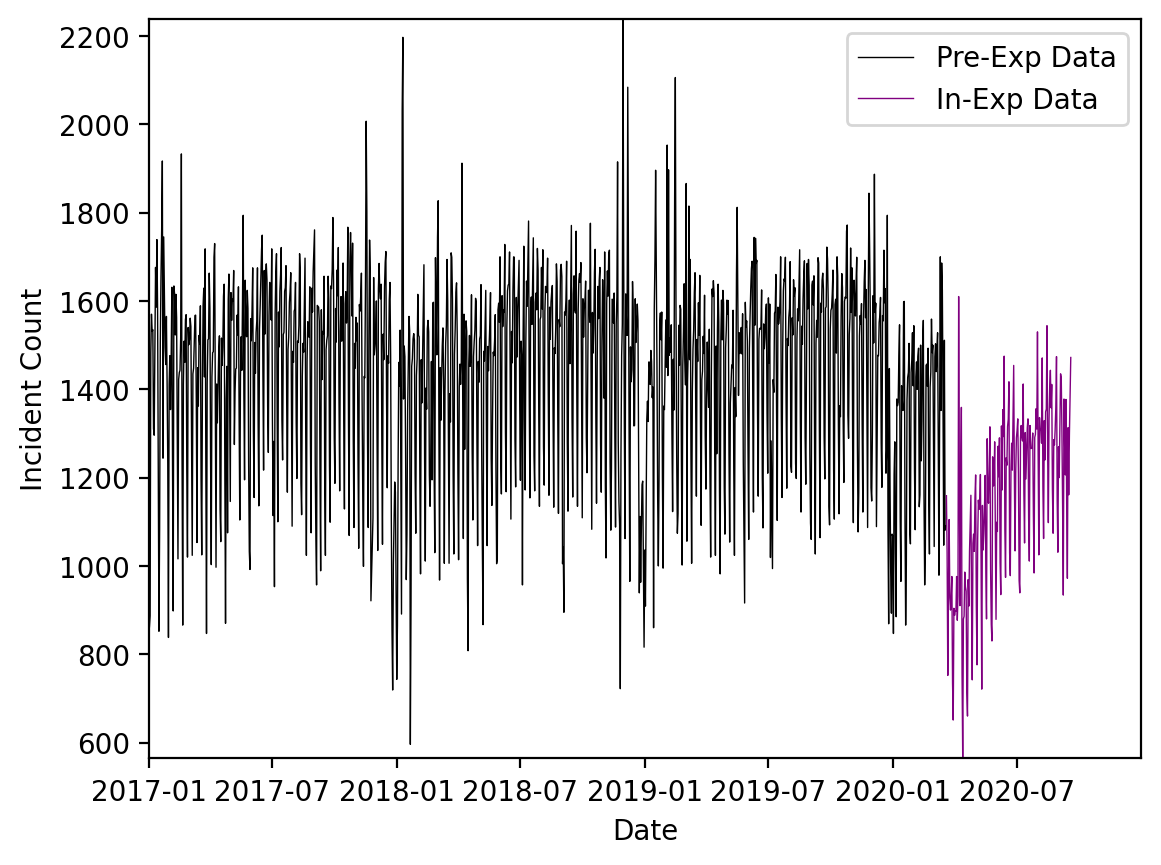

In [4]:
plt.figure(dpi=dpi)

# Separate train, validation, test data
n = cal_data.shape[0]
# pandemic lockdown started march 19 in california
train_df = cal_data[cal_data['x'] < '2020-03-19'].reset_index(drop=True)
test_df = cal_data[(cal_data['x'] >= '2020-03-19') & (cal_data['x'] < '2020-09-19')].reset_index(drop=True)
# plot
x_range = [min(cal_data['x']), max(cal_data['x'])]
y_range = [min(cal_data['y']), max(cal_data['y'])]
plt.plot(train_df['x'], train_df['y'], color='black',linewidth=0.5,label='Pre-Exp Data')
plt.plot(test_df['x'], test_df['y'], color='purple',linewidth=0.5,label='In-Exp Data')
ax = plt.gca()
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_xlabel("Date")
ax.set_ylabel("Incident Count")
ax.legend()
plt.show()

<Figure size 1280x960 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

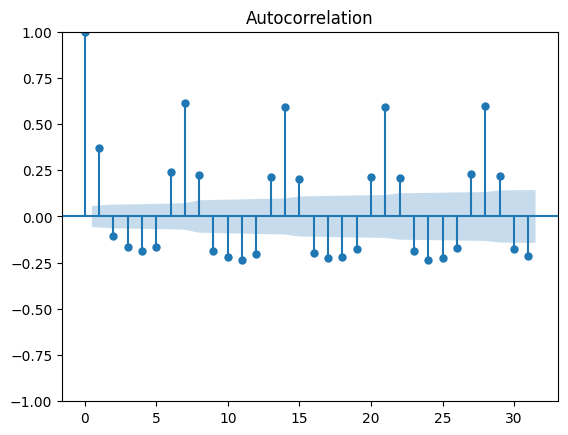

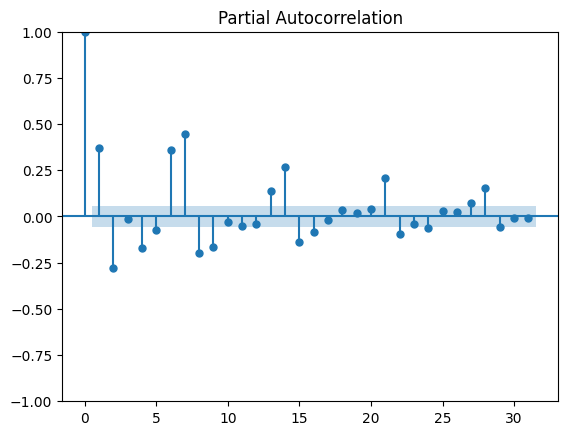

In [7]:
# plot autocorrelation and partial autocorrelation side by side
plt.figure(dpi=dpi)
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(train_df['y'])
plt.title('Autocorrelation')
sm.graphics.tsa.plot_pacf(train_df['y'])
plt.title('Partial Autocorrelation')
plt.show()

<Figure size 1280x960 with 0 Axes>

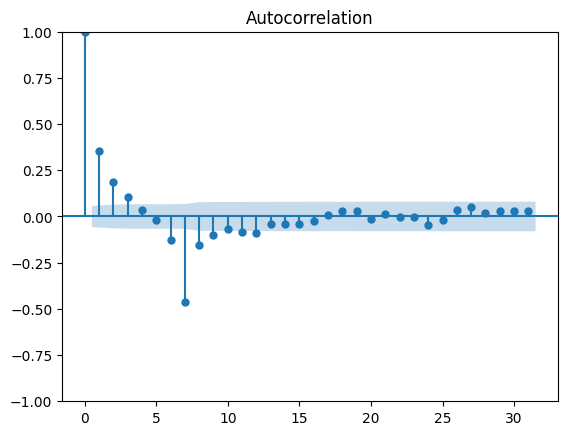

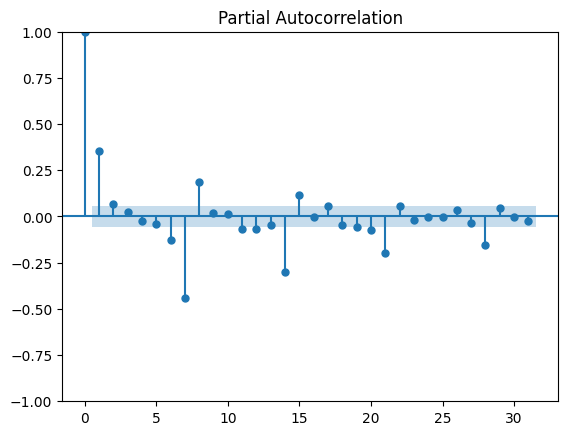

In [8]:
# seasonally differenced data, plot acf and pacf again
diff_y  = train_df['y'].diff(7).dropna()
plt.figure(dpi=dpi)
sm.graphics.tsa.plot_acf(diff_y)
plt.title('Autocorrelation')
sm.graphics.tsa.plot_pacf(diff_y)
plt.title('Partial Autocorrelation')
plt.show()

In [5]:
# Choose parameters to try fitting the model with
p = [0,1]
q = [0,1]
d = [0,1]
P = [0,1]
Q = [0,1]
D = [0,1] # dont need to test 0,1, just remove 1 if testing as run takes too long
S = [7]
#D = [0]
param1 = list(itertools.product(p,d,q))
param2 = list(itertools.product(P,D,Q,S))
best_param1 = param1[0]
best_param2 = param2[0]
for i in range(len(param1)):
    for j in range(len(param2)):
        #print(i,j)
        model = sm.tsa.statespace.SARIMAX(train_df['y'], order = param1[i], seasonal_order = param2[j])
        result = model.fit(disp=False)
        tb = result.summary().tables[0].as_html()
        readable_tb = pd.read_html(io.StringIO(tb),header=None,index_col=None)[0] 
        cur_aic = readable_tb[3][2]
        if i == 0 and j == 0:
            best_aic = cur_aic
        elif cur_aic < best_aic:
            best_aic = cur_aic
            best_param1 = param1[i]
            best_param2 = param2[j]
best_aic, best_param1, best_param2
opt_model = sm.tsa.statespace.SARIMAX(train_df['y'], order = best_param1, seasonal_order = best_param2)
opt_res = opt_model.fit(disp=False)


/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/Mast

<Figure size 2000x1200 with 0 Axes>

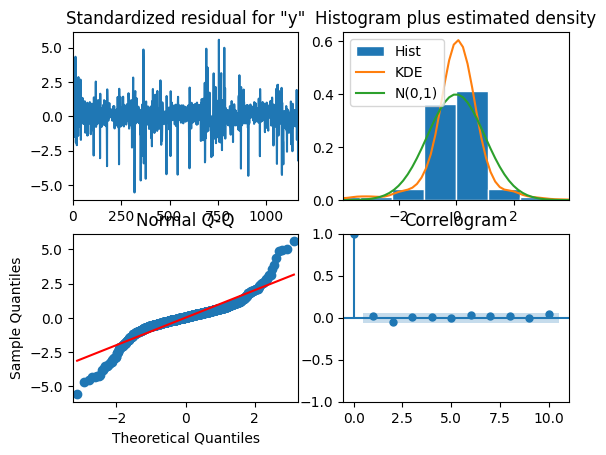

In [ ]:
# fit the best model and check residuals
plt.figure(figsize=(10, 6),dpi=dpi)
opt_res = opt_model.fit(disp=False)
opt_res.plot_diagnostics()
plt.show()

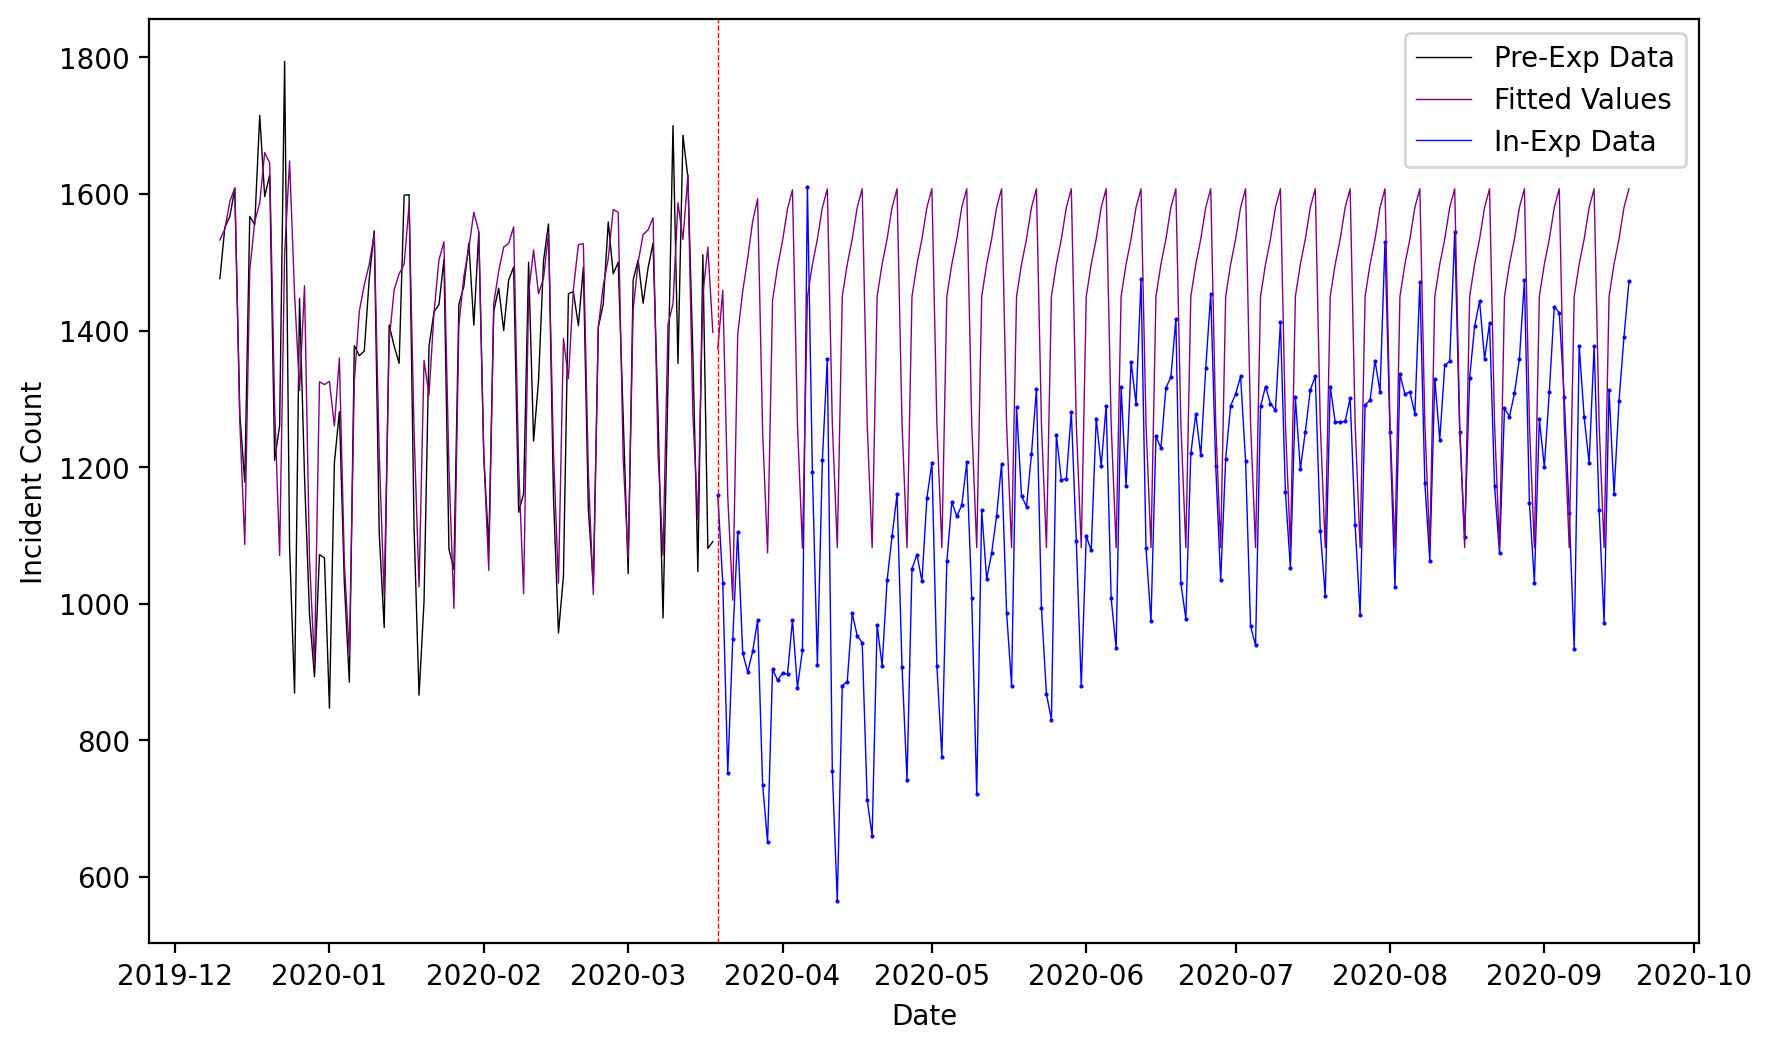

In [6]:
# predict values for test data and plot against actual test data
plt.figure(figsize=(10,6), dpi = dpi)
pred = opt_res.get_prediction(start=train_df.index[-1]+1, end=train_df.index[-1]+len(test_df)).predicted_mean.reset_index(drop=True) # watch index here as it is reset when train test split
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'], test_df['y'], 'o', color='blue', markersize = 0.5)
plt.plot(test_df['x'], test_df['y'], color='blue', linewidth = 0.5, label='In-Exp Data')
plt.plot(test_df['x'], pred, color='purple', ls = '-', linewidth=0.5)
# plot a vertical line to show the start of the test data
plt.axvline(x=test_df['x'].iloc[0], color='red', linestyle='--', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.legend()
plt.show()


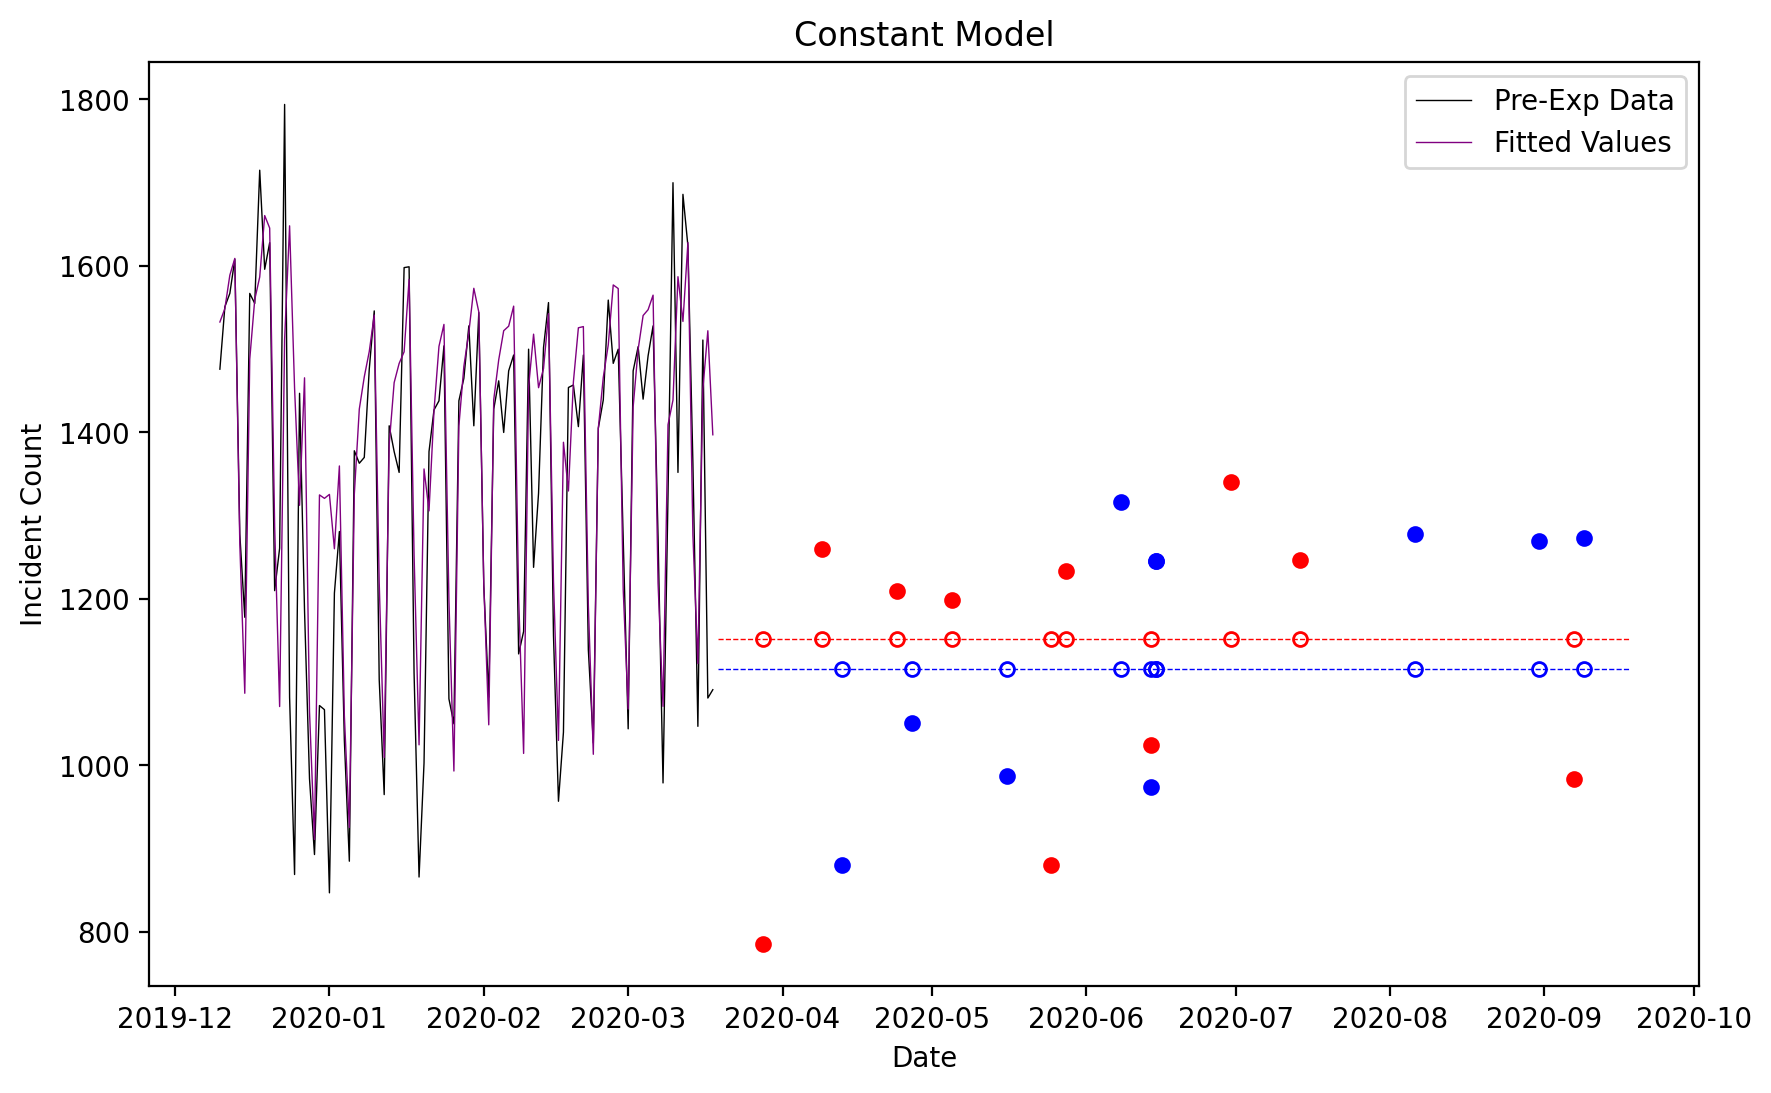

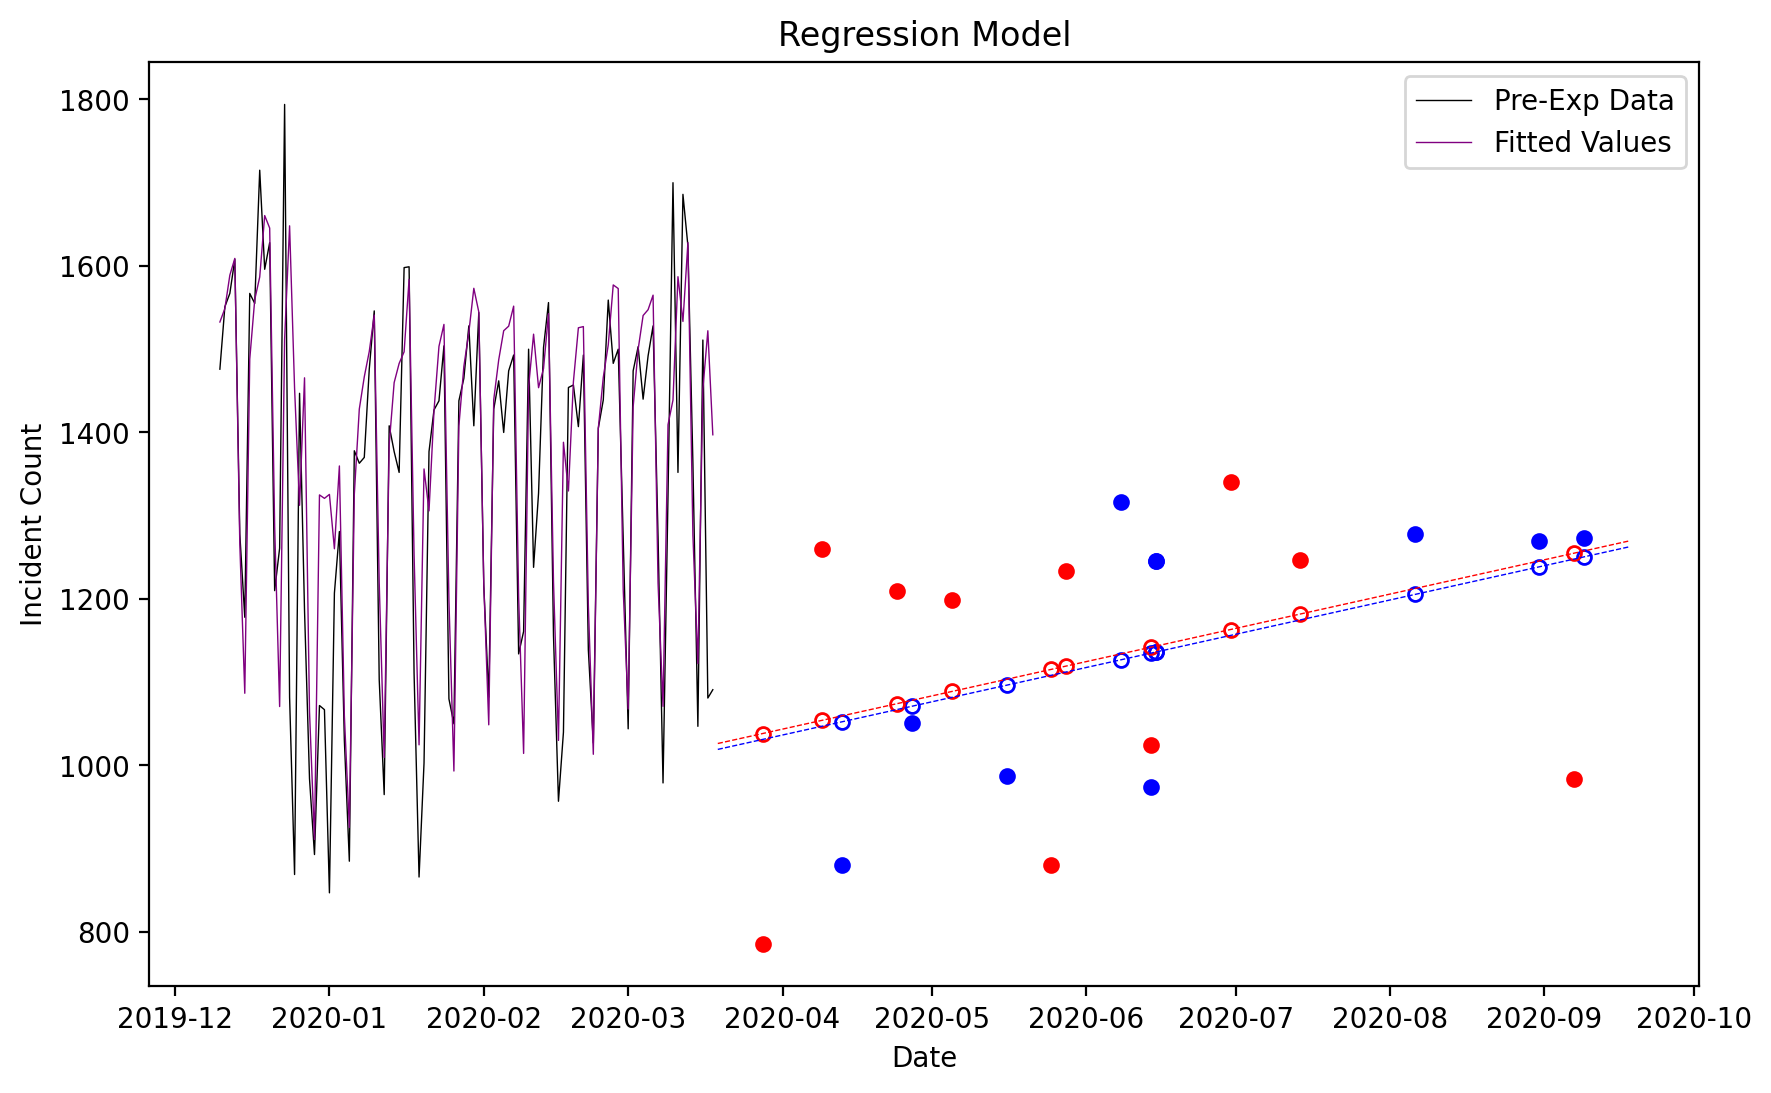

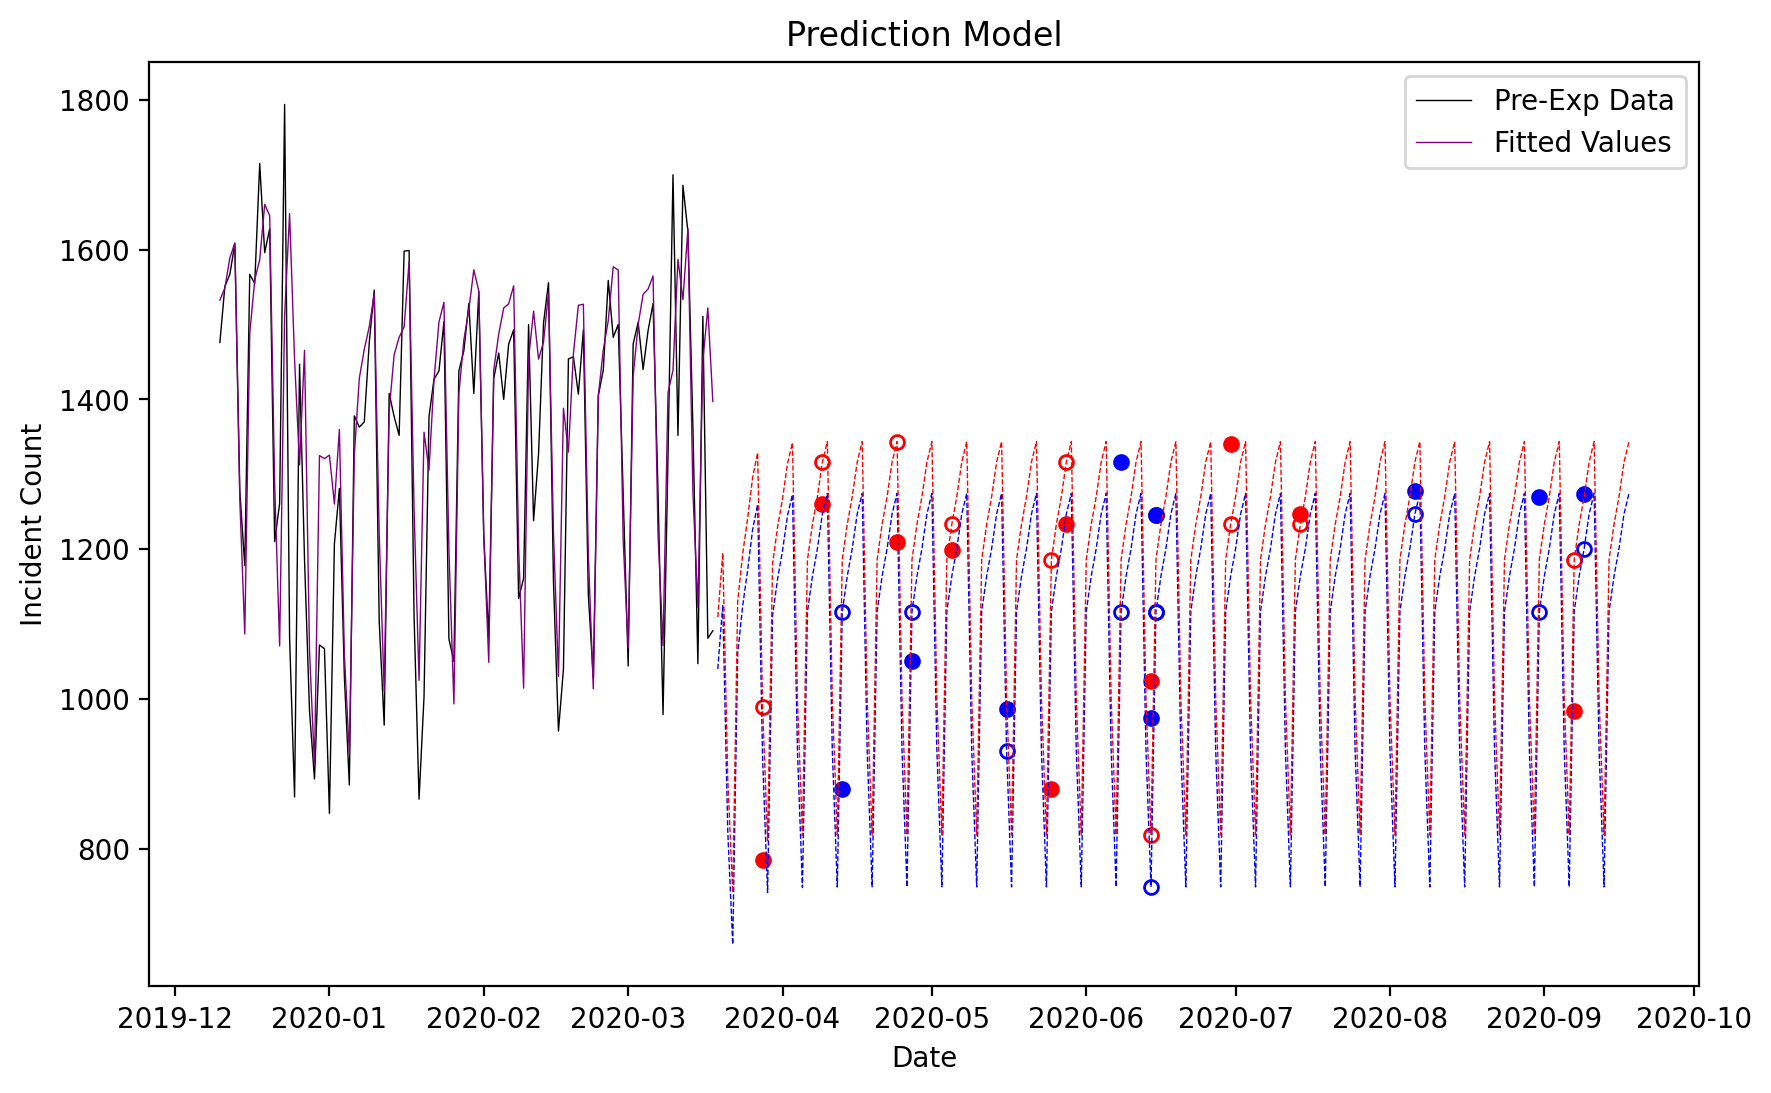

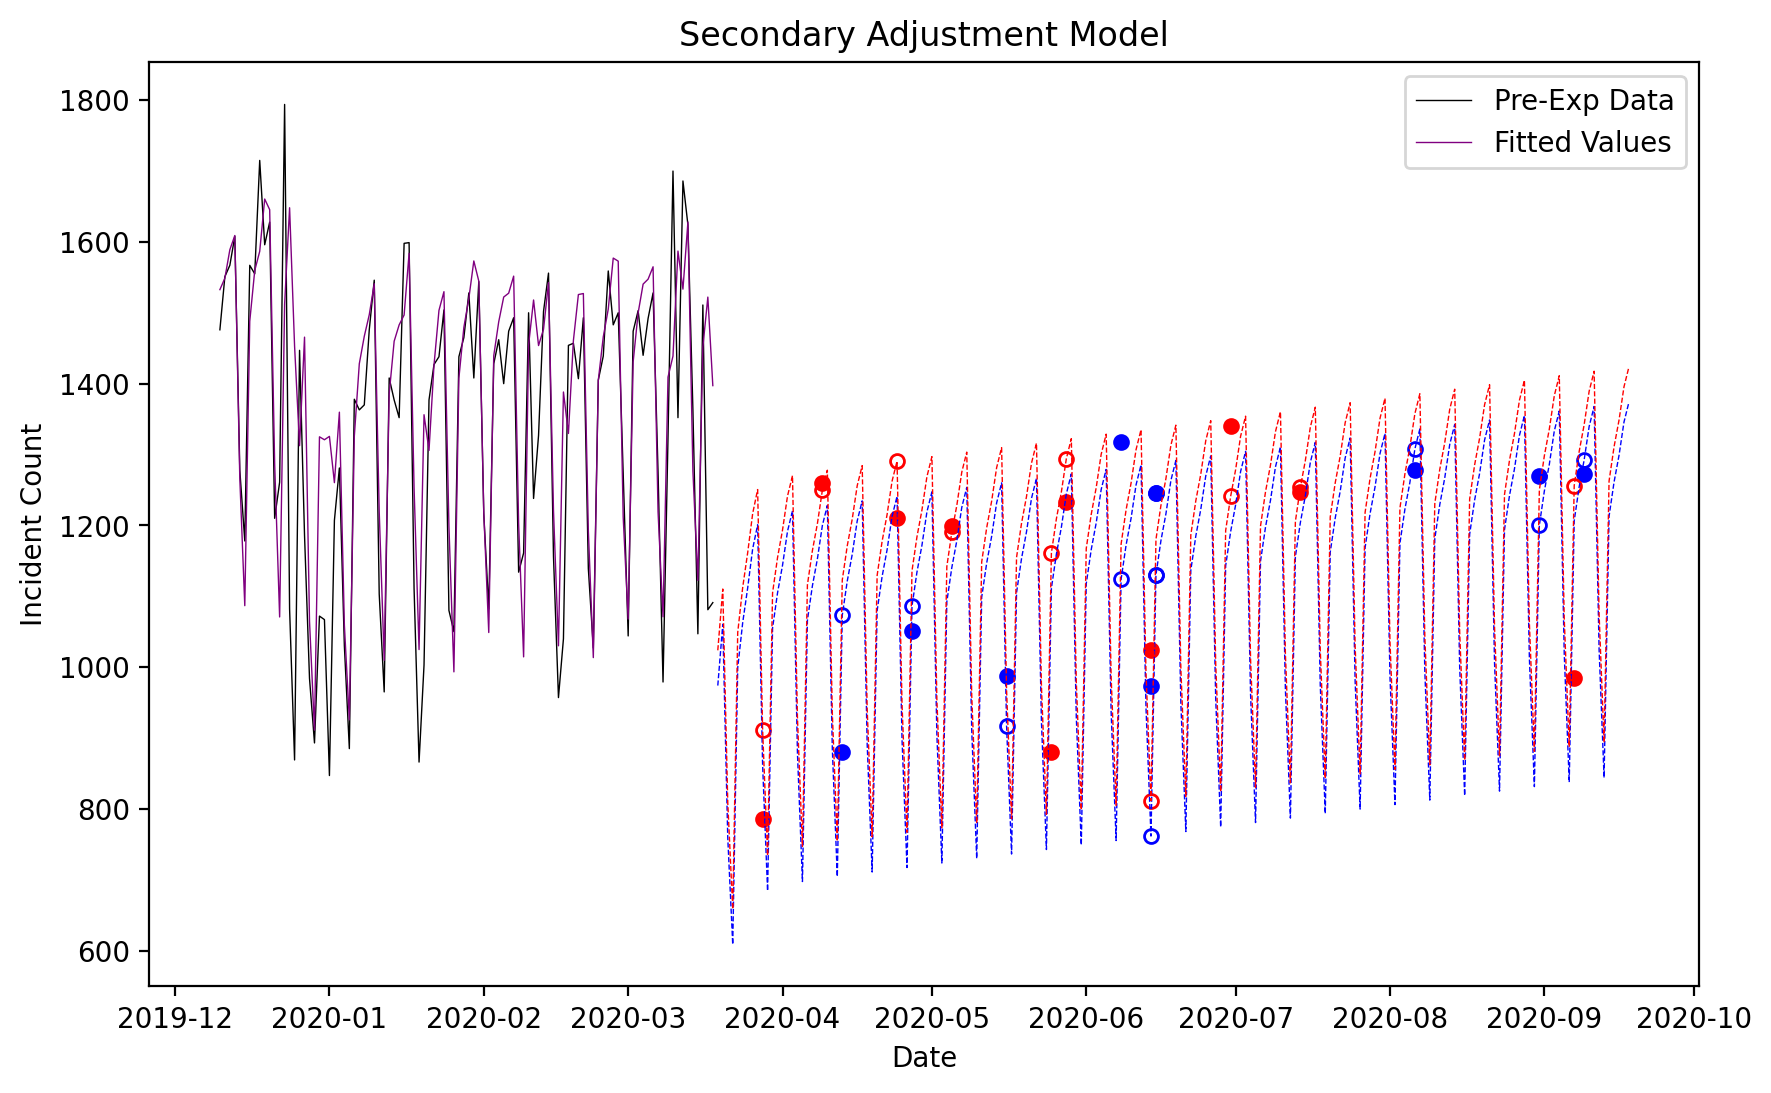

In [7]:
# simulate experiment by randomly assigning treatment to some data points
np.random.seed(0)
# treatment effect - say increase of 50 incidents
test_len = len(test_df)
# convert date in test data to integer, with minimum date being 0 - this is for regression and secondary adjustment later
clean_test_df = traffic_preprocess(test_df.copy())
n = 10
te = 50
# randomly assign treatment
control_df, control_idx, treatment_df, treatment_idx = generate_exp_data(clean_test_df, te, n) # indices of dfs not reset - doesn't matter i think?
#print(pred, pred[control_idx], pred[treatment_idx])

# generate counterfactuals with constant model
const_c = np.full(len(control_df),treatment_df['y'].mean())
const_t = np.full(len(treatment_df), control_df['y'].mean())
# counterfactuals over entire test data
const_c_all = np.full(len(clean_test_df), treatment_df['y'].mean())
const_t_all = np.full(len(clean_test_df), control_df['y'].mean())

# generate counterfactuals with regression model
y_1 = to_matrix(treatment_df['y'])
yc_1 = y_1 - y_1.mean()
y_0 = to_matrix(control_df['y'])
yc_0 = y_0 - y_0.mean()
x_0 = to_matrix(control_df.drop(columns = ['y']))
xc_0 = x_0 - np.mean(x_0, axis=0)
x_1 = to_matrix(treatment_df.drop(columns = ['y']))
xc_1 = x_1 - np.mean(x_1, axis=0)
#print(y_1, y_0, x_1, x_0)
# calculate the beta coefficients
treatxvar = xc_1.T @ xc_1
controlxvar = xc_0.T @ xc_0
treatxcov = xc_1.T @ yc_1
controlxcov = xc_0.T @ yc_0
beta = np.linalg.inv(treatxvar + controlxvar) @ (treatxcov + controlxcov)
# calculate the average treatment effect and standard error
xbar_1 = to_matrix(np.mean(x_1, axis=0)) # np.mean reduces the dimension so we need to turn it back to matrix
xbar_0 = to_matrix(np.mean(x_0, axis=0))
alpha_1 = np.mean(y_1) - xbar_1.T @ beta
alpha_0 = np.mean(y_0) - xbar_0.T @ beta
reg_c = alpha_1 + x_0 @ beta
reg_t = alpha_0 + x_1 @ beta
# counterfactuals over entire test data
reg_c_all = alpha_1 + to_matrix(clean_test_df.drop(columns = ['y'])) @ beta
reg_t_all = alpha_0 + to_matrix(clean_test_df.drop(columns = ['y'])) @ beta

# generate counterfactuals with prediction model
y_1 = treatment_df['y']
y_0 = control_df['y']
# get prediction for the instance of control and treatment data
control_pred = pred[control_idx].reset_index(drop=True)
treatment_pred = pred[treatment_idx].reset_index(drop=True)
alpha_1 = np.mean(y_1 - treatment_pred)
alpha_0 = np.mean(y_0 - control_pred)
pred_c = control_pred + alpha_1
pred_t = treatment_pred + alpha_0
# counterfactuals over entire test data
pred_c_all = pred + alpha_1
pred_t_all = pred + alpha_0

# generate counterfactuals with secondary adjustment model
y_1 = to_matrix(treatment_df['y'] - treatment_pred)
yc_1 = y_1 - y_1.mean()
y_0 = to_matrix(control_df['y'] - control_pred)
yc_0 = y_0 - y_0.mean()
x_0 = to_matrix(control_df.drop(columns = ['y']))
xc_0 = x_0 - np.mean(x_0, axis=0)
x_1 = to_matrix(treatment_df.drop(columns = ['y']))
xc_1 = x_1 - np.mean(x_1, axis=0)
#print(x_1, x_0, y_1, y_0)
# calculate the beta coefficients
treatxvar = xc_1.T @ xc_1
controlxvar = xc_0.T @ xc_0
treatxcov = xc_1.T @ yc_1
controlxcov = xc_0.T @ yc_0
beta = np.linalg.inv(treatxvar + controlxvar) @ (treatxcov + controlxcov)
# calculate the average treatment effect and standard error
xbar_1 = to_matrix(np.mean(x_1, axis=0)) # np.mean reduces the dimension so we need to turn it back to matrix
xbar_0 = to_matrix(np.mean(x_0, axis=0))
alpha_1 = np.mean(y_1) - xbar_1.T @ beta
alpha_0 = np.mean(y_0) - xbar_0.T @ beta
#print(control_pred.shape, (x_0 @ beta).shape)
second_c = to_matrix(control_pred) + x_0 @ beta + alpha_1
second_t = to_matrix(treatment_pred) +  x_1 @ beta + alpha_0
# counterfactuals over entire test data
second_c_all = to_matrix(pred) + to_matrix(clean_test_df.drop(columns = ['y'])) @ beta + alpha_1
second_t_all = to_matrix(pred) + to_matrix(clean_test_df.drop(columns = ['y'])) @ beta + alpha_0

# make 4 subplots, one for each method. Each subplot should show a bit of pre-experiment data. The in-experiment data should be plotted with solid points,
# blue for control and red for treatment. The counterfactuals should be plotted with hollow points, blue for control and red for treatment.
plt.figure(figsize=(10, 6), dpi=dpi)
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'][control_idx], control_df['y'], 'o', color='blue', markersize = 5)
plt.plot(test_df['x'][treatment_idx], treatment_df['y'], 'o', color='red', markersize = 5)
plt.plot(test_df['x'][control_idx], const_c, 'o', color='blue', markersize = 5, fillstyle='none')
plt.plot(test_df['x'][treatment_idx], const_t, 'o', color='red', markersize = 5, fillstyle='none')
plt.plot(test_df['x'], const_c_all, color='blue', linewidth = 0.5, ls = '--')
plt.plot(test_df['x'], const_t_all, color='red', linewidth = 0.5, ls = '--')
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.title('Constant Model')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6), dpi=dpi)
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'][control_idx], control_df['y'], 'o', color='blue', markersize = 5)
plt.plot(test_df['x'][treatment_idx], treatment_df['y'], 'o', color='red', markersize = 5)
plt.plot(test_df['x'][control_idx], reg_c, 'o', color='blue', markersize = 5, fillstyle='none')
plt.plot(test_df['x'][treatment_idx], reg_t, 'o', color='red', markersize = 5, fillstyle='none')
plt.plot(test_df['x'], reg_c_all, color='blue', linewidth = 0.5, ls = '--')
plt.plot(test_df['x'], reg_t_all, color='red', linewidth = 0.5, ls = '--')
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.title('Regression Model')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6), dpi=dpi)
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'][control_idx], control_df['y'], 'o', color='blue', markersize = 5)
plt.plot(test_df['x'][treatment_idx], treatment_df['y'], 'o', color='red', markersize = 5)
plt.plot(test_df['x'][control_idx], pred_c, 'o', color='blue', markersize = 5, fillstyle='none')
plt.plot(test_df['x'][treatment_idx], pred_t, 'o', color='red', markersize = 5, fillstyle='none')
plt.plot(test_df['x'], pred_c_all, color='blue', linewidth = 0.5, ls = '--')
plt.plot(test_df['x'], pred_t_all, color='red', linewidth = 0.5, ls = '--')
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.title('Prediction Model')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6), dpi=dpi)
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'][control_idx], control_df['y'], 'o', color='blue', markersize = 5)
plt.plot(test_df['x'][treatment_idx], treatment_df['y'], 'o', color='red', markersize = 5)
plt.plot(test_df['x'][control_idx], second_c, 'o', color='blue', markersize = 5, fillstyle='none')
plt.plot(test_df['x'][treatment_idx], second_t, 'o', color='red', markersize = 5, fillstyle='none')
plt.plot(test_df['x'], second_c_all, color='blue', linewidth = 0.5, ls = '--')
plt.plot(test_df['x'], second_t_all, color='red', linewidth = 0.5, ls = '--')
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.title('Secondary Adjustment Model')
plt.legend()
plt.show()


In [16]:
# run simulation

# set seed for reproducibility
np.random.seed(0)

# simulation parameters
te_lst = [0, 20, 50, 100, 200]
n_lst = [100, 200, 500, 1000]
r = 10000
pred = opt_res.get_prediction(start=train_df.index[-1]+1, end=train_df.index[-1]+len(test_df)).predicted_mean.reset_index(drop=True)
test_df_clean = traffic_preprocess(test_df.copy()) # get rid of the date, convert to integer
# rejection threshold for 5% alpha
threshold = norm.ppf(0.975)

# save results here
# pre-determine size for efficiency
total = len(te_lst)*len(n_lst)*r
rows = np.zeros((total, 12))

# set up tqdm in the outer loop 
with tqdm(total=total, desc="Overall Progress") as pbar:
    idx = 0
    for te in te_lst: 
        for n in n_lst:
            for i in range(r):
                # randomly generate an instance of experiment data
                control_df, control_idx, treatment_df, treatment_idx = generate_exp_data(test_df_clean, te, n)

                # constant model
                ate, se = calculate_ate(control_df, treatment_df)
                rej = np.abs(ate) > threshold*se
                row = [ate, se, rej]

                # regression model
                ate, se = calculate_ate_reg(control_df, treatment_df)
                rej = np.abs(ate) > threshold*se
                row.extend([ate, se, rej])

                # prediction model
                #print(control_df, control_idx)
                ate, se = calculate_ate_pred(control_df, treatment_df, pred, control_idx, treatment_idx)
                rej = np.abs(ate) > threshold*se
                row.extend([ate, se, rej])

                # secondary adjustment model
                ate, se = calculate_ate_sec(control_df, treatment_df, pred, control_idx, treatment_idx)
                rej = np.abs(ate) > threshold*se
                row.extend([ate, se, rej])
                
                rows[idx, :] = row
                idx += 1
                pbar.update(1)

# convert to dataframe
colnames = ['Constant ATE', 'Constant SE', 'Constant Rej', 
            'Regression ATE', 'Regression SE', 'Regression Rej',
            'Prediction ATE', 'Prediction SE', 'Prediction Rej',
            'Secondary ATE', 'Secondary SE', 'Secondary Rej']
results = pd.DataFrame(rows, columns=colnames)

            


Overall Progress: 100%|██████████| 200000/200000 [04:00<00:00, 832.14it/s]


In [17]:
# add columns for the simulation parameters
results['te'] = np.repeat(te_lst, len(n_lst)*r)
results['n'] = np.tile(np.repeat(n_lst, r), len(te_lst))
results.iloc[-100:]

Constant ATE  Constant SE  Constant Rej  Regression ATE  \
199900       198.498     8.912157           1.0      201.567194   
199901       195.216     8.858881           1.0      194.821030   
199902       198.957     9.007251           1.0      201.152348   
199903       205.131     9.029221           1.0      203.626010   
199904       208.232     8.966698           1.0      210.105081   
...              ...          ...           ...             ...   
199995       202.068     8.788588           1.0      201.774221   
199996       207.272     9.085107           1.0      207.675022   
199997       208.664     8.642670           1.0      213.097005   
199998       195.269     8.985181           1.0      192.325827   
199999       178.897     8.770971           1.0      184.765963   

        Regression SE  Regression Rej  Prediction ATE  Prediction SE  \
199900       8.095031             1.0      202.221022       7.852339   
199901       8.025862             1.0      193.637845       7.715388   
199902       8.155523             1.0      196.901439       7.879237   
199903       8.183154             1.0      193.725809       8.011834   
199904       8.107676             1.0      197.704966       7.776018   
...               ...             ...             ...            ...   
199995       8.030801             1.0      198.486772       7.740666   
199996       8.421896             1.0      194.870344       7.898678   
199997       7.935526             1.0      201.210308       7.844945   
199998       8.091312             1.0      186.939878       7.818011   
199999       7.857730             1.0      184.589392       7.760647   

        Prediction Rej  Secondary ATE  Secondary SE  Secondary Rej   te     n  
199900             1.0     205.100024      7.035119            1.0  200  1000  
199901             1.0     193.295684      7.002228            1.0  200  1000  
199902             1.0     198.960344      7.020477            1.0  200  1000  
199903             1.0     192.327157      7.188610            1.0  200  1000  
199904             1.0     199.439440      6.924602            1.0  200  1000  
...                ...            ...           ...            ...  ...   ...  
199995             1.0     198.206771      6.957003            1.0  200  1000  
199996             1.0     195.251033      7.217468            1.0  200  1000  
199997             1.0     205.803369      7.001412            1.0  200  1000  
199998             1.0     184.365406      7.035848            1.0  200  1000  
199999             1.0     189.970688      6.893530            1.0  200  1000  

[100 rows x 14 columns]

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


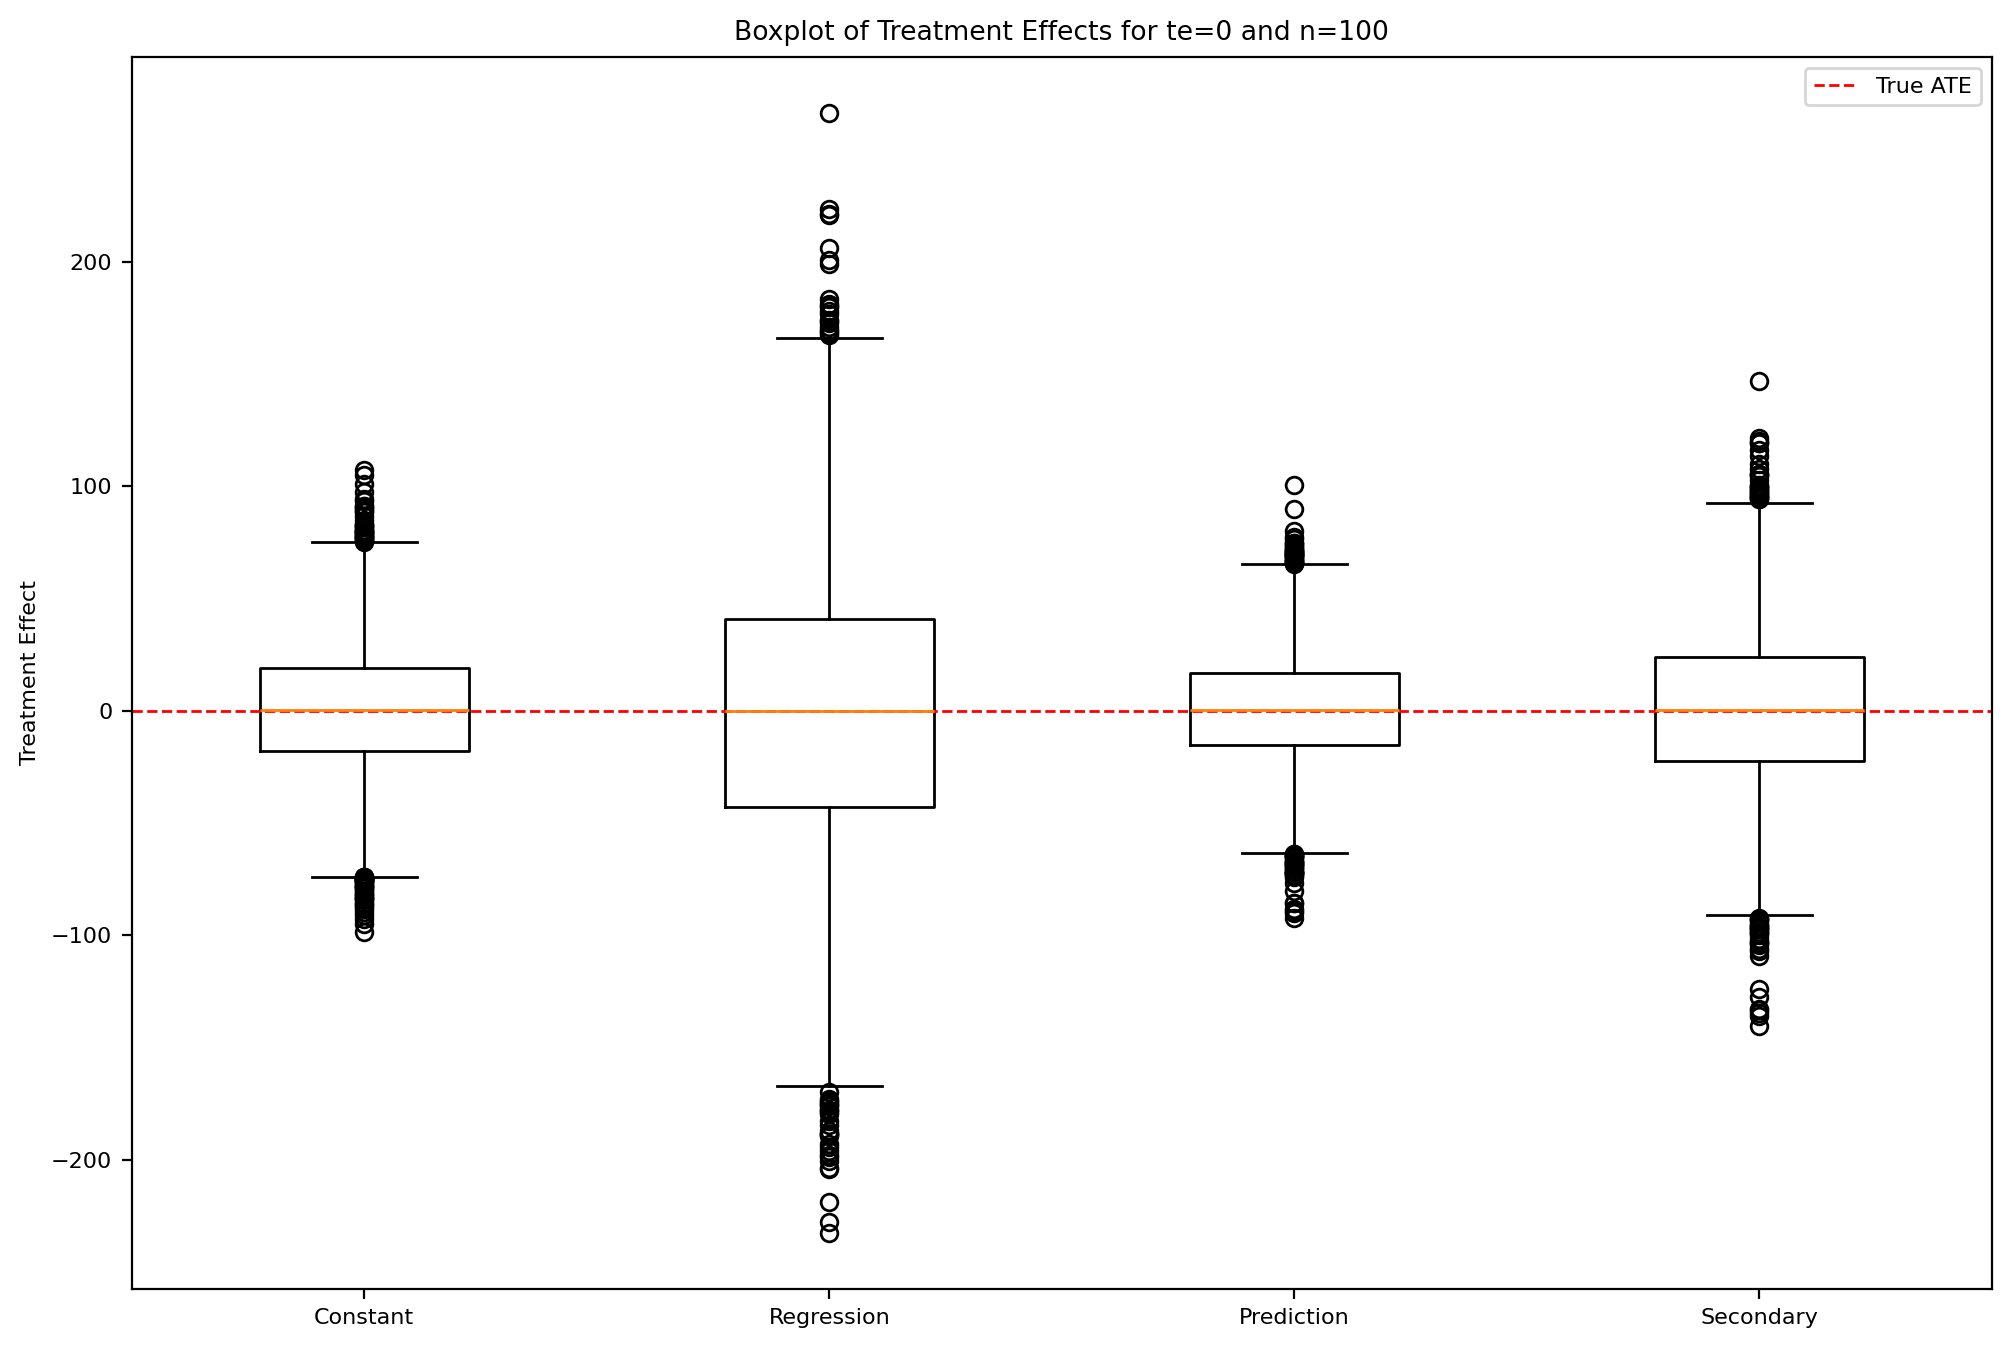

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


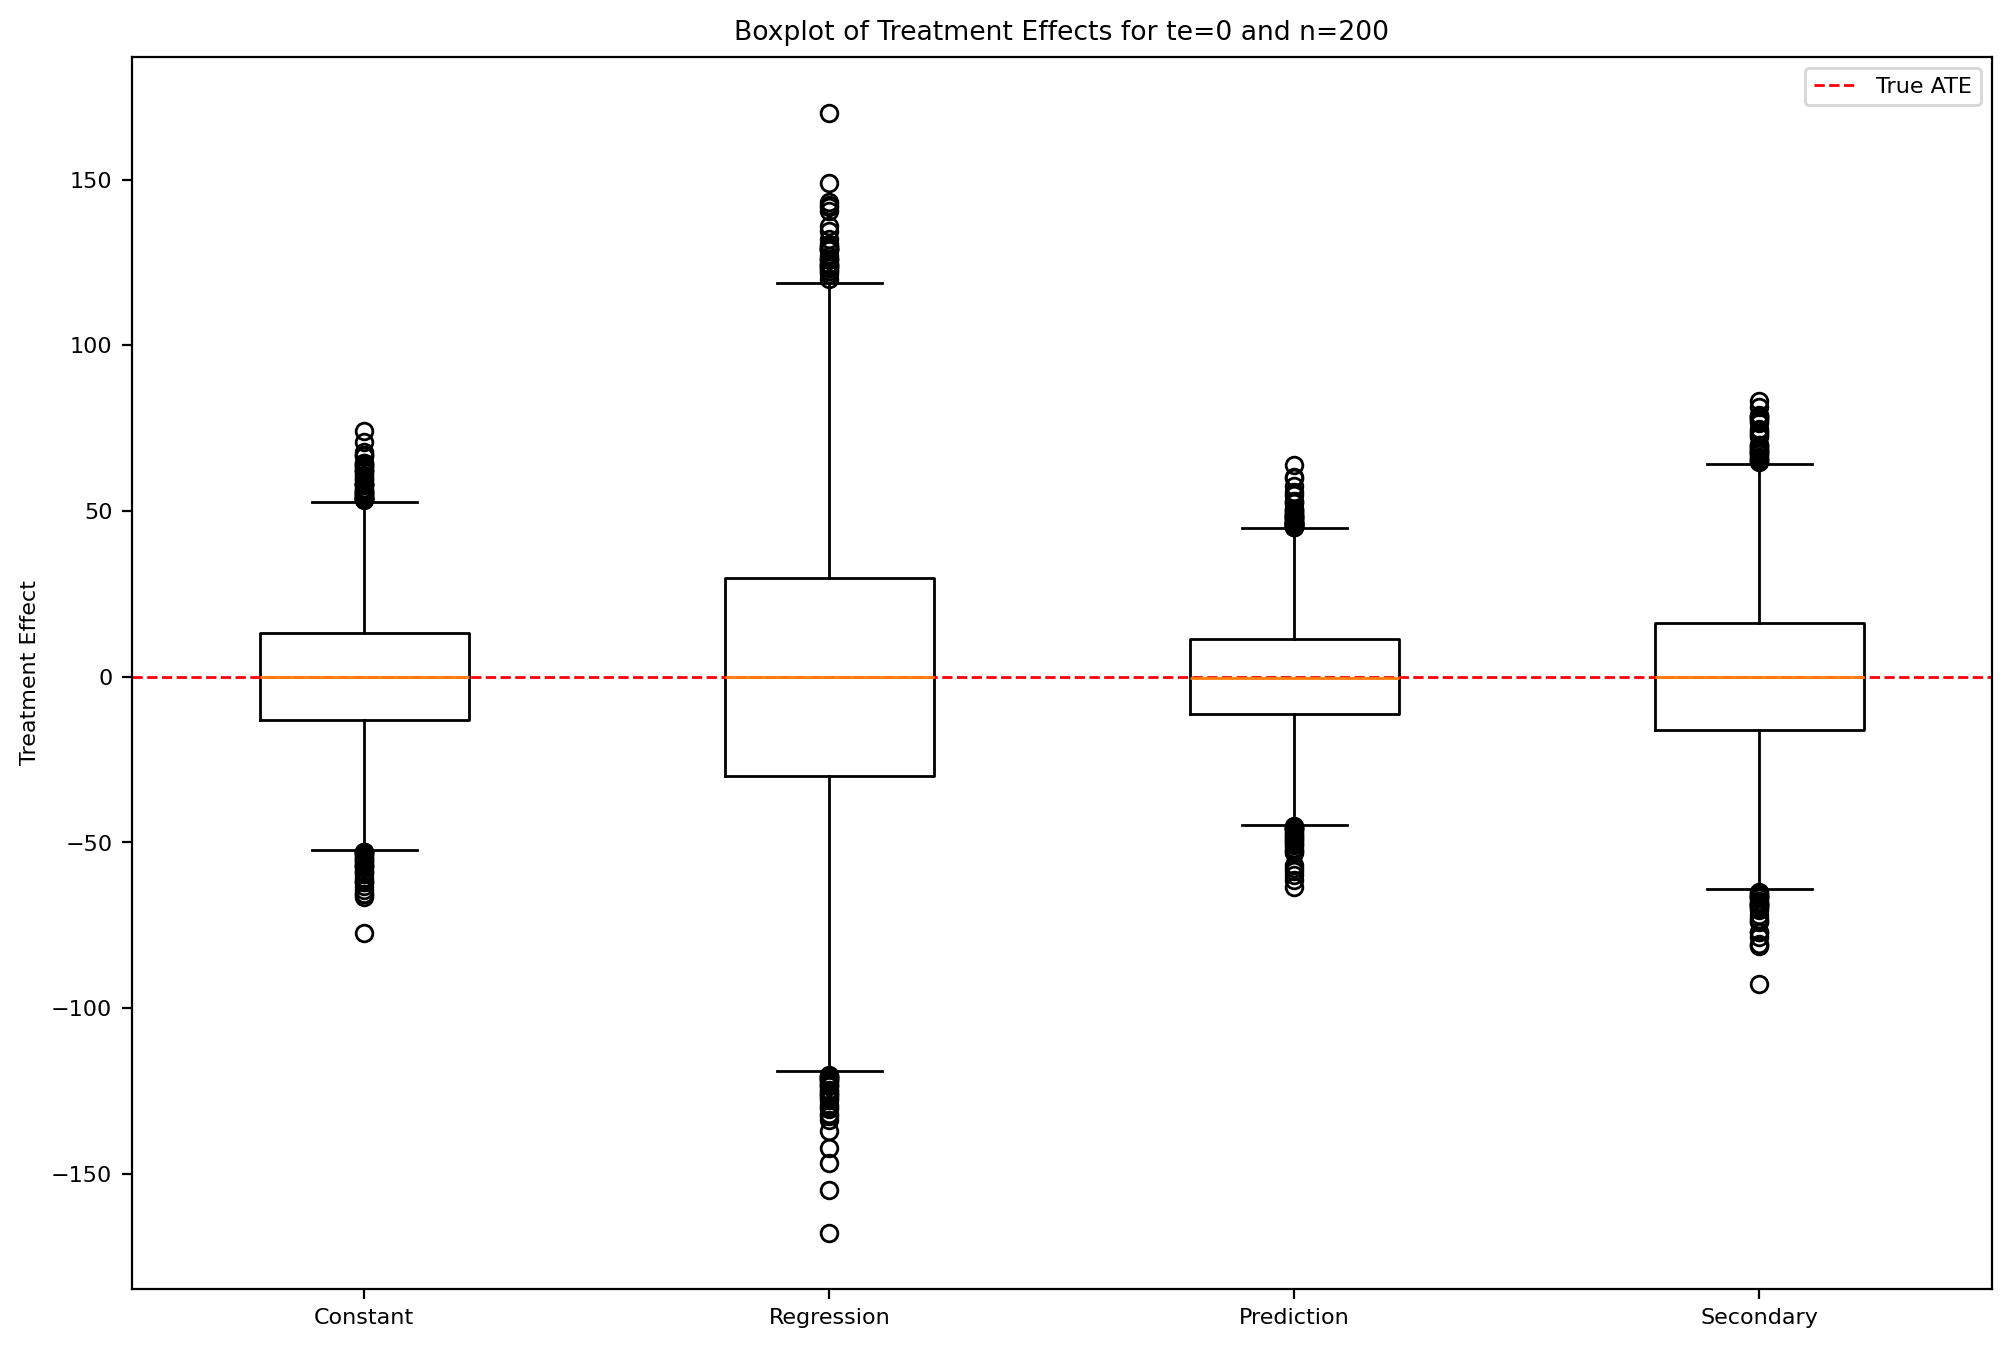

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


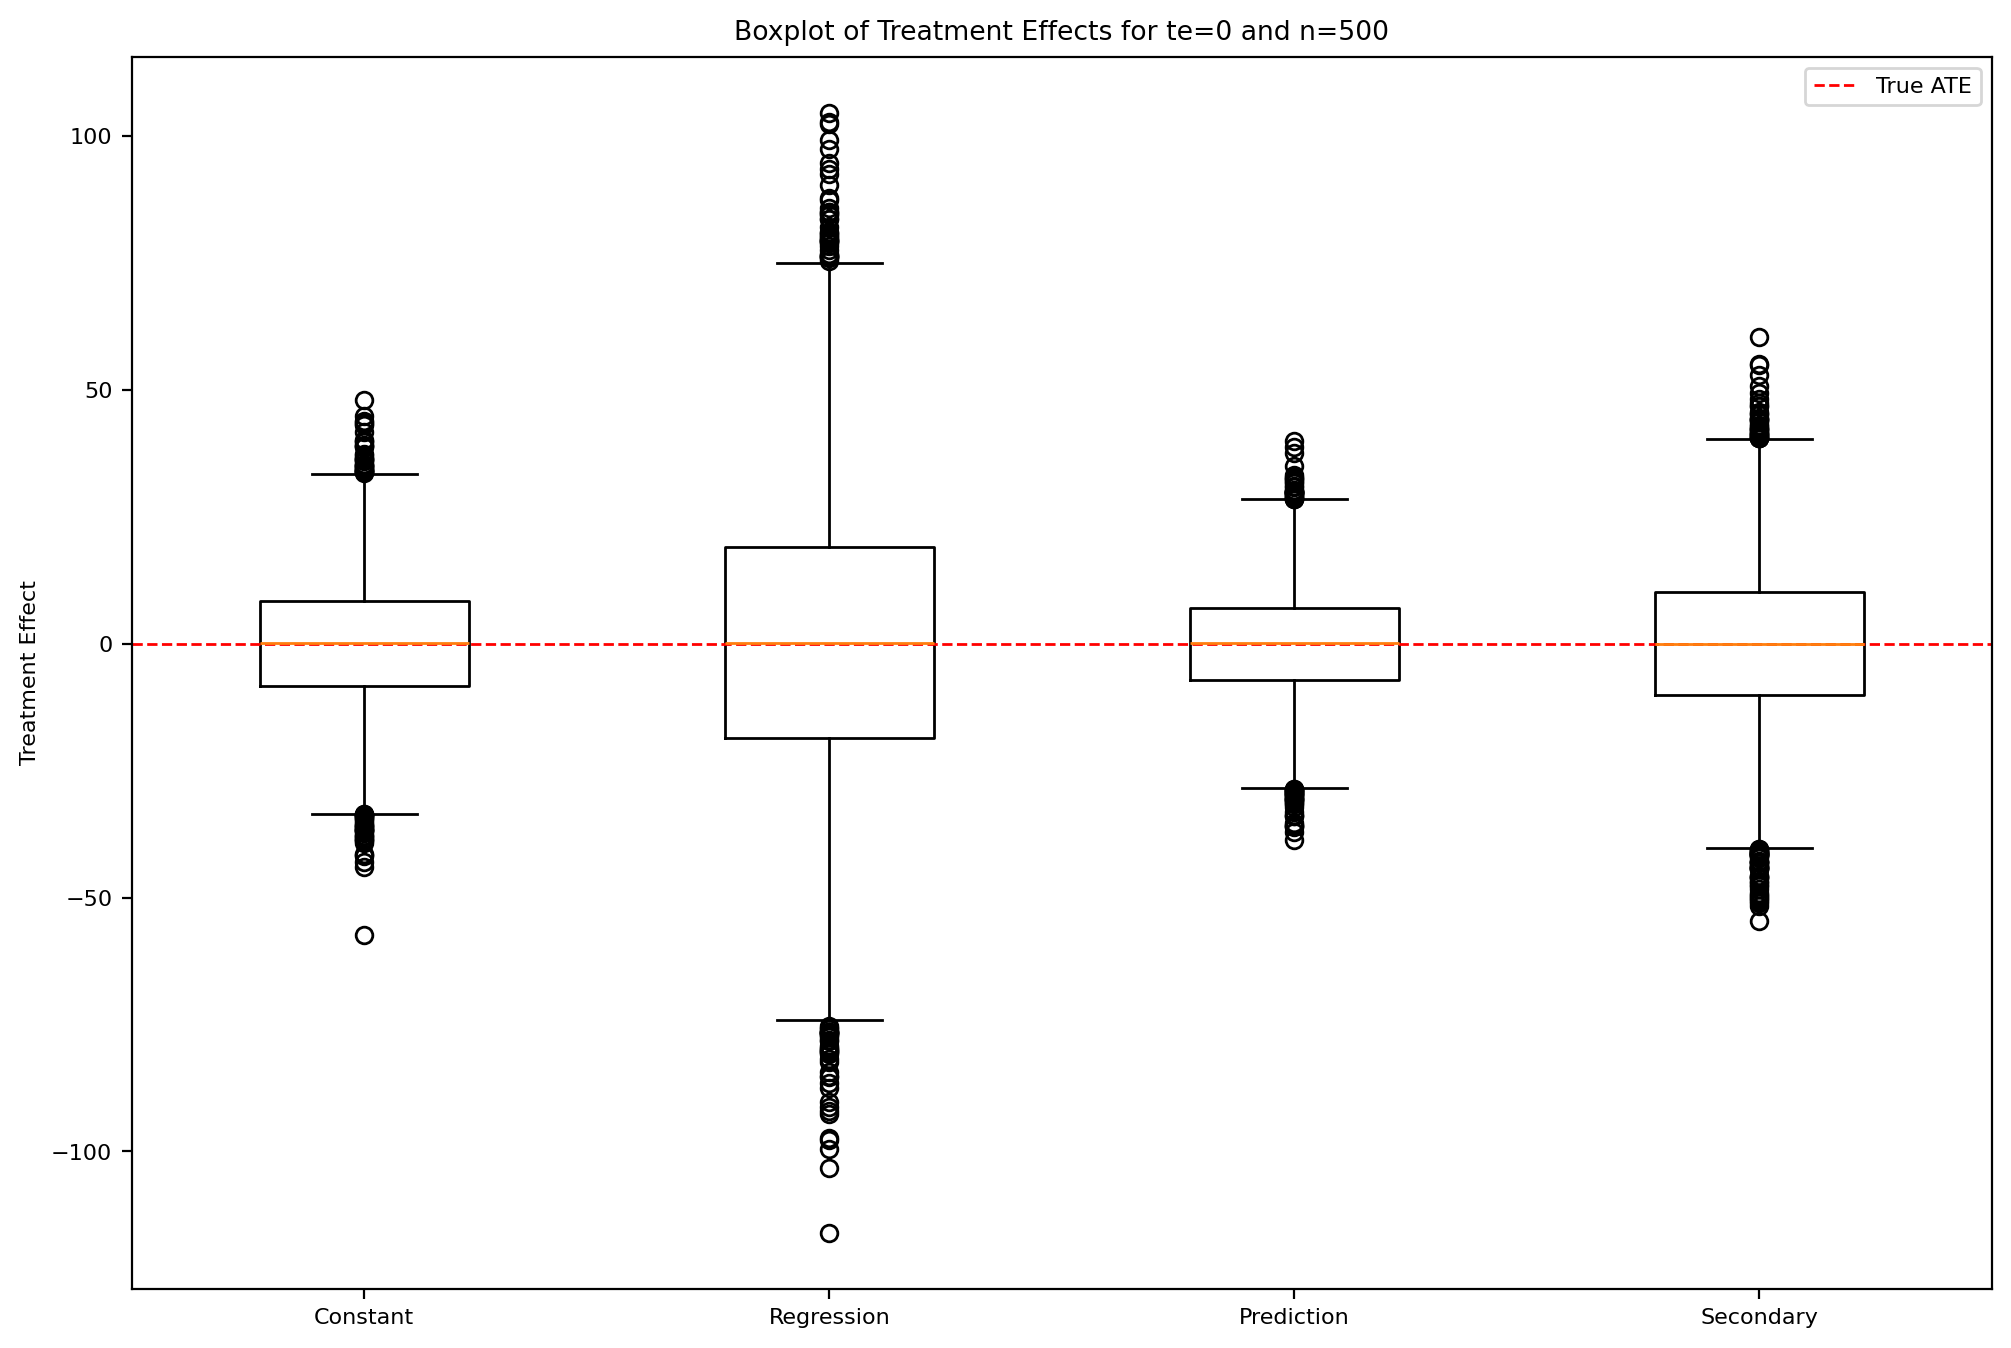

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


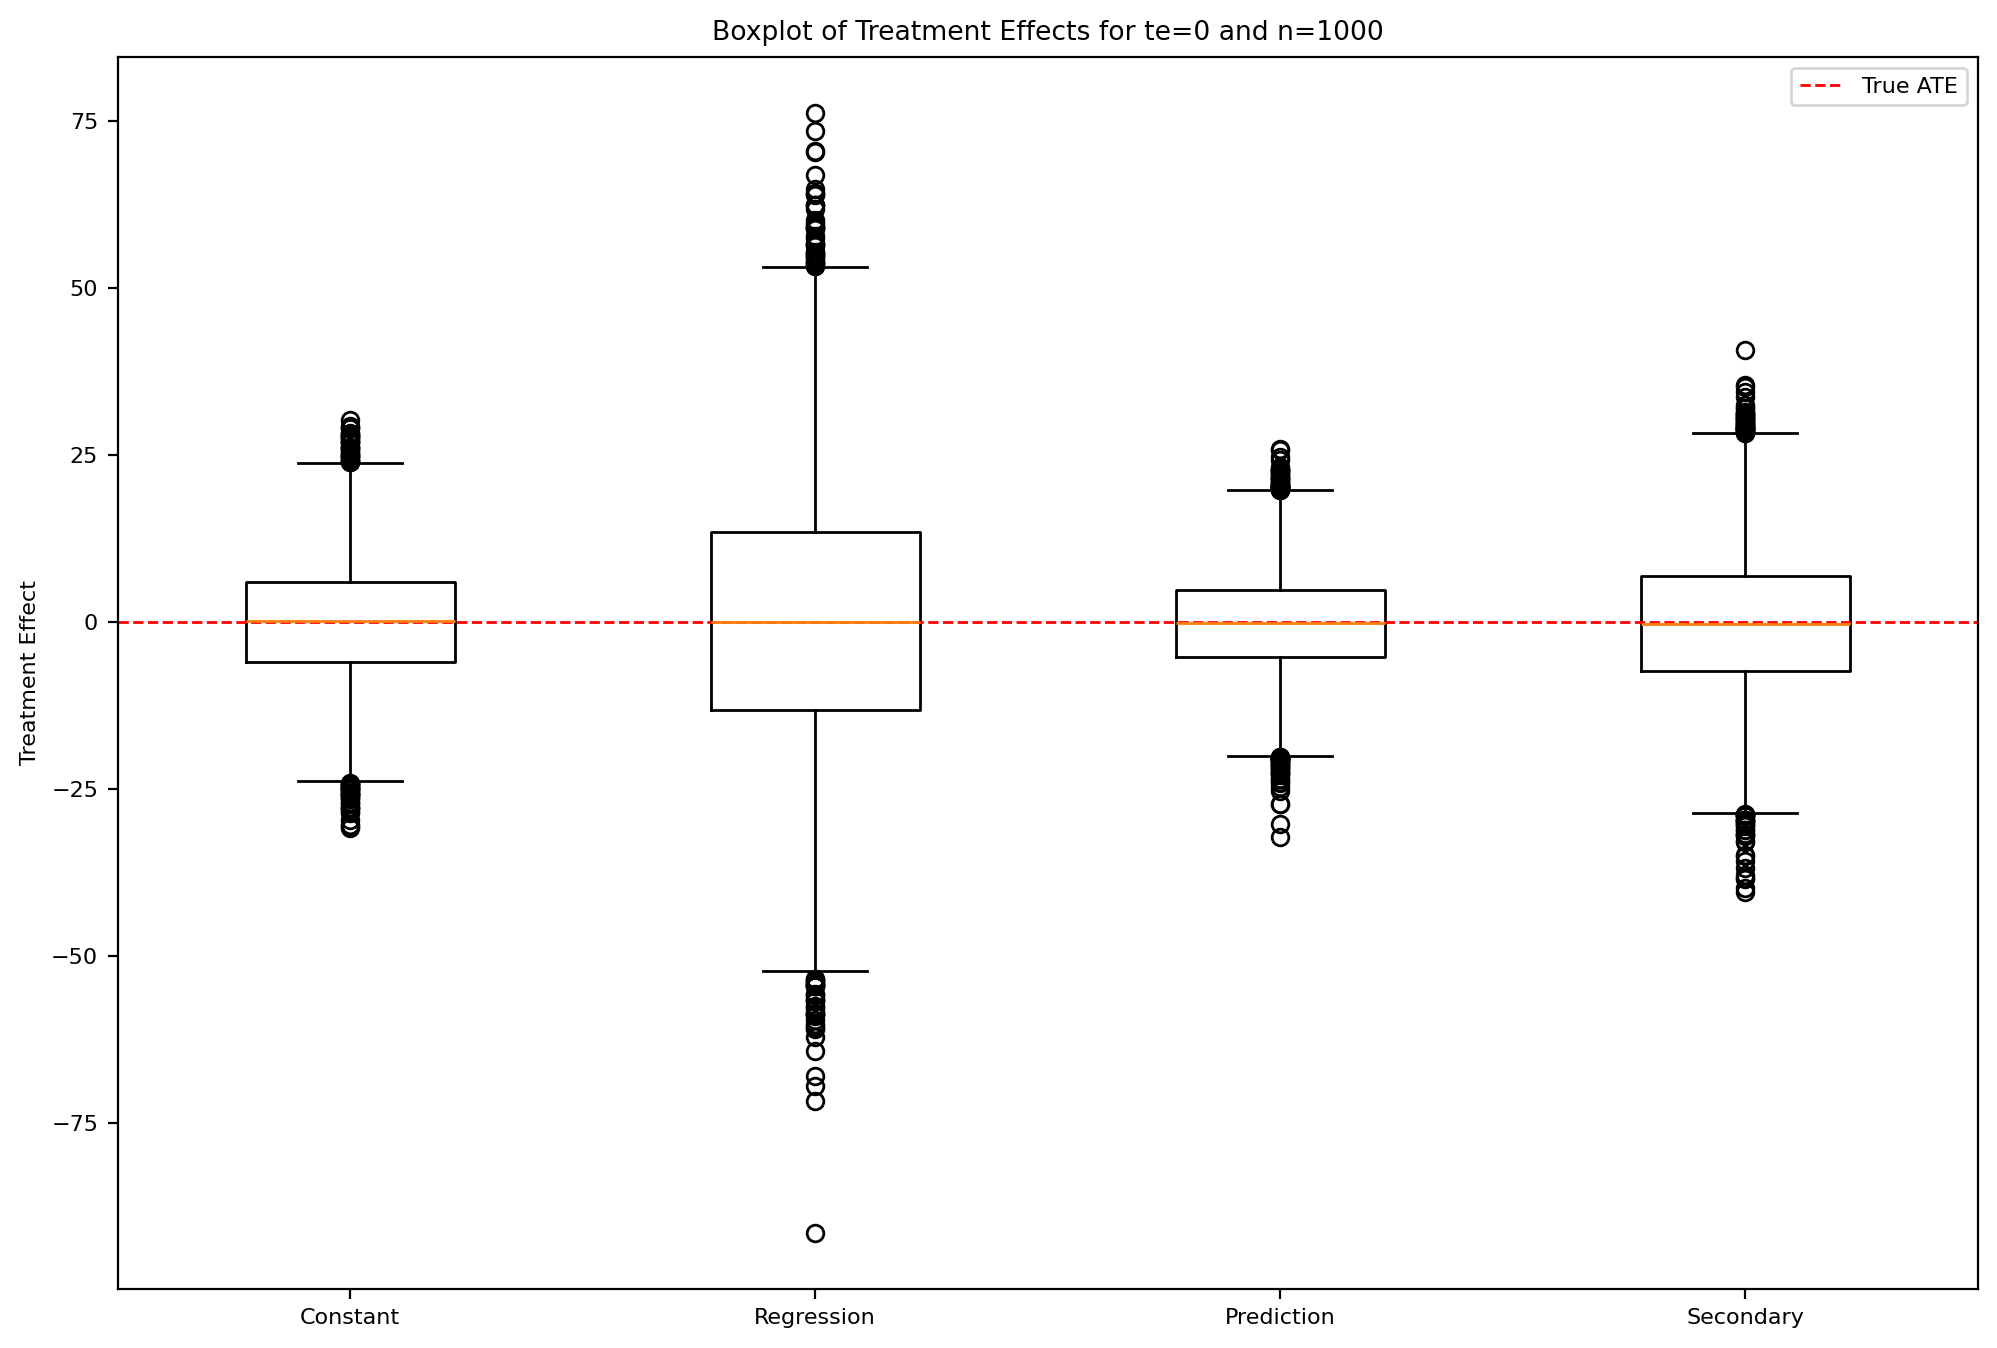

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


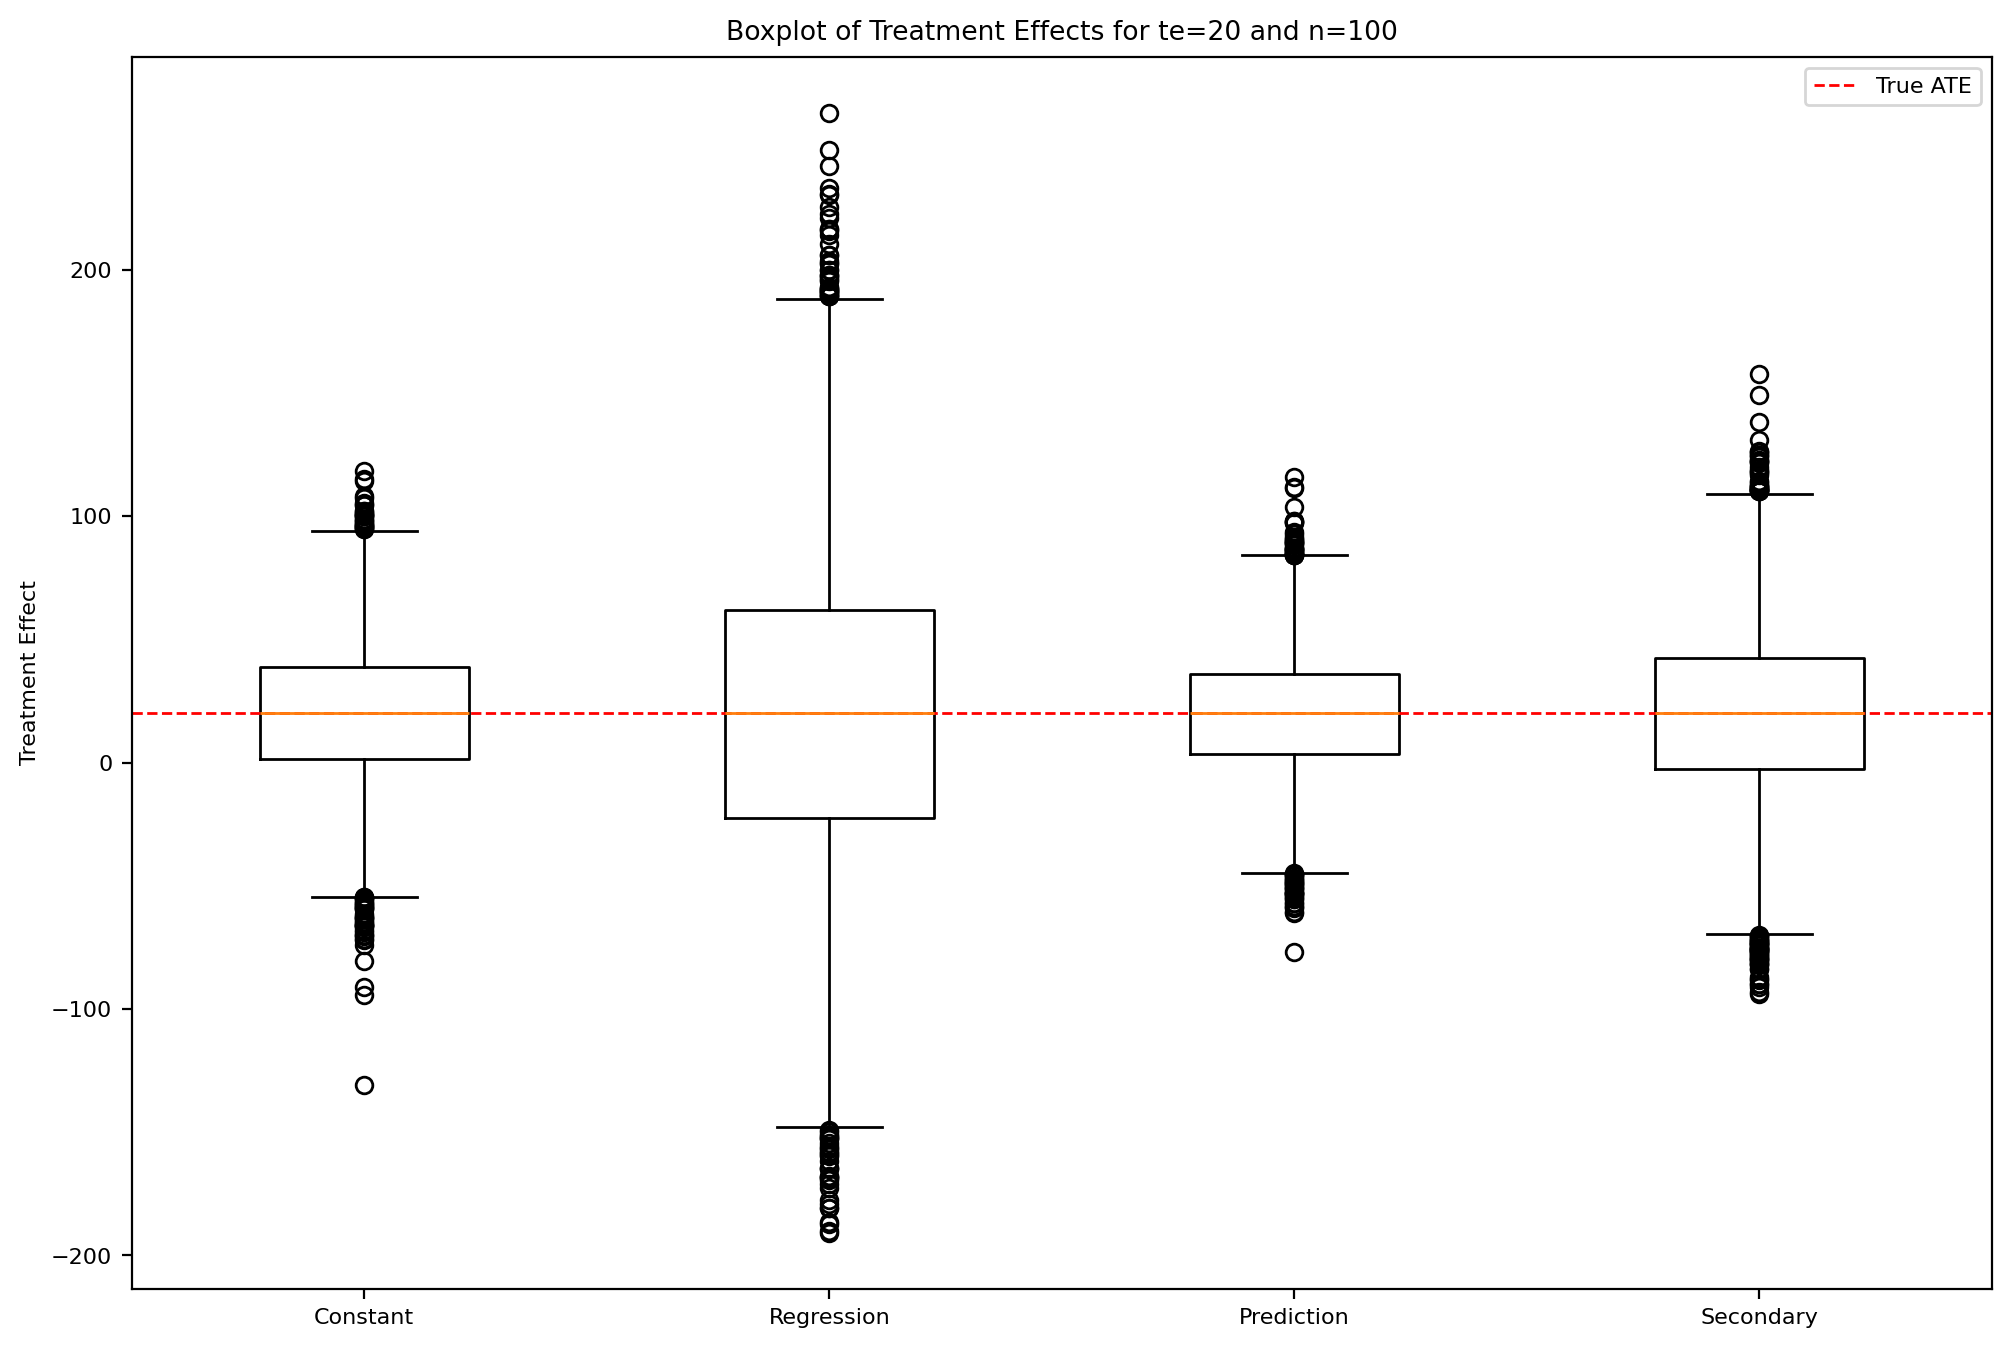

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


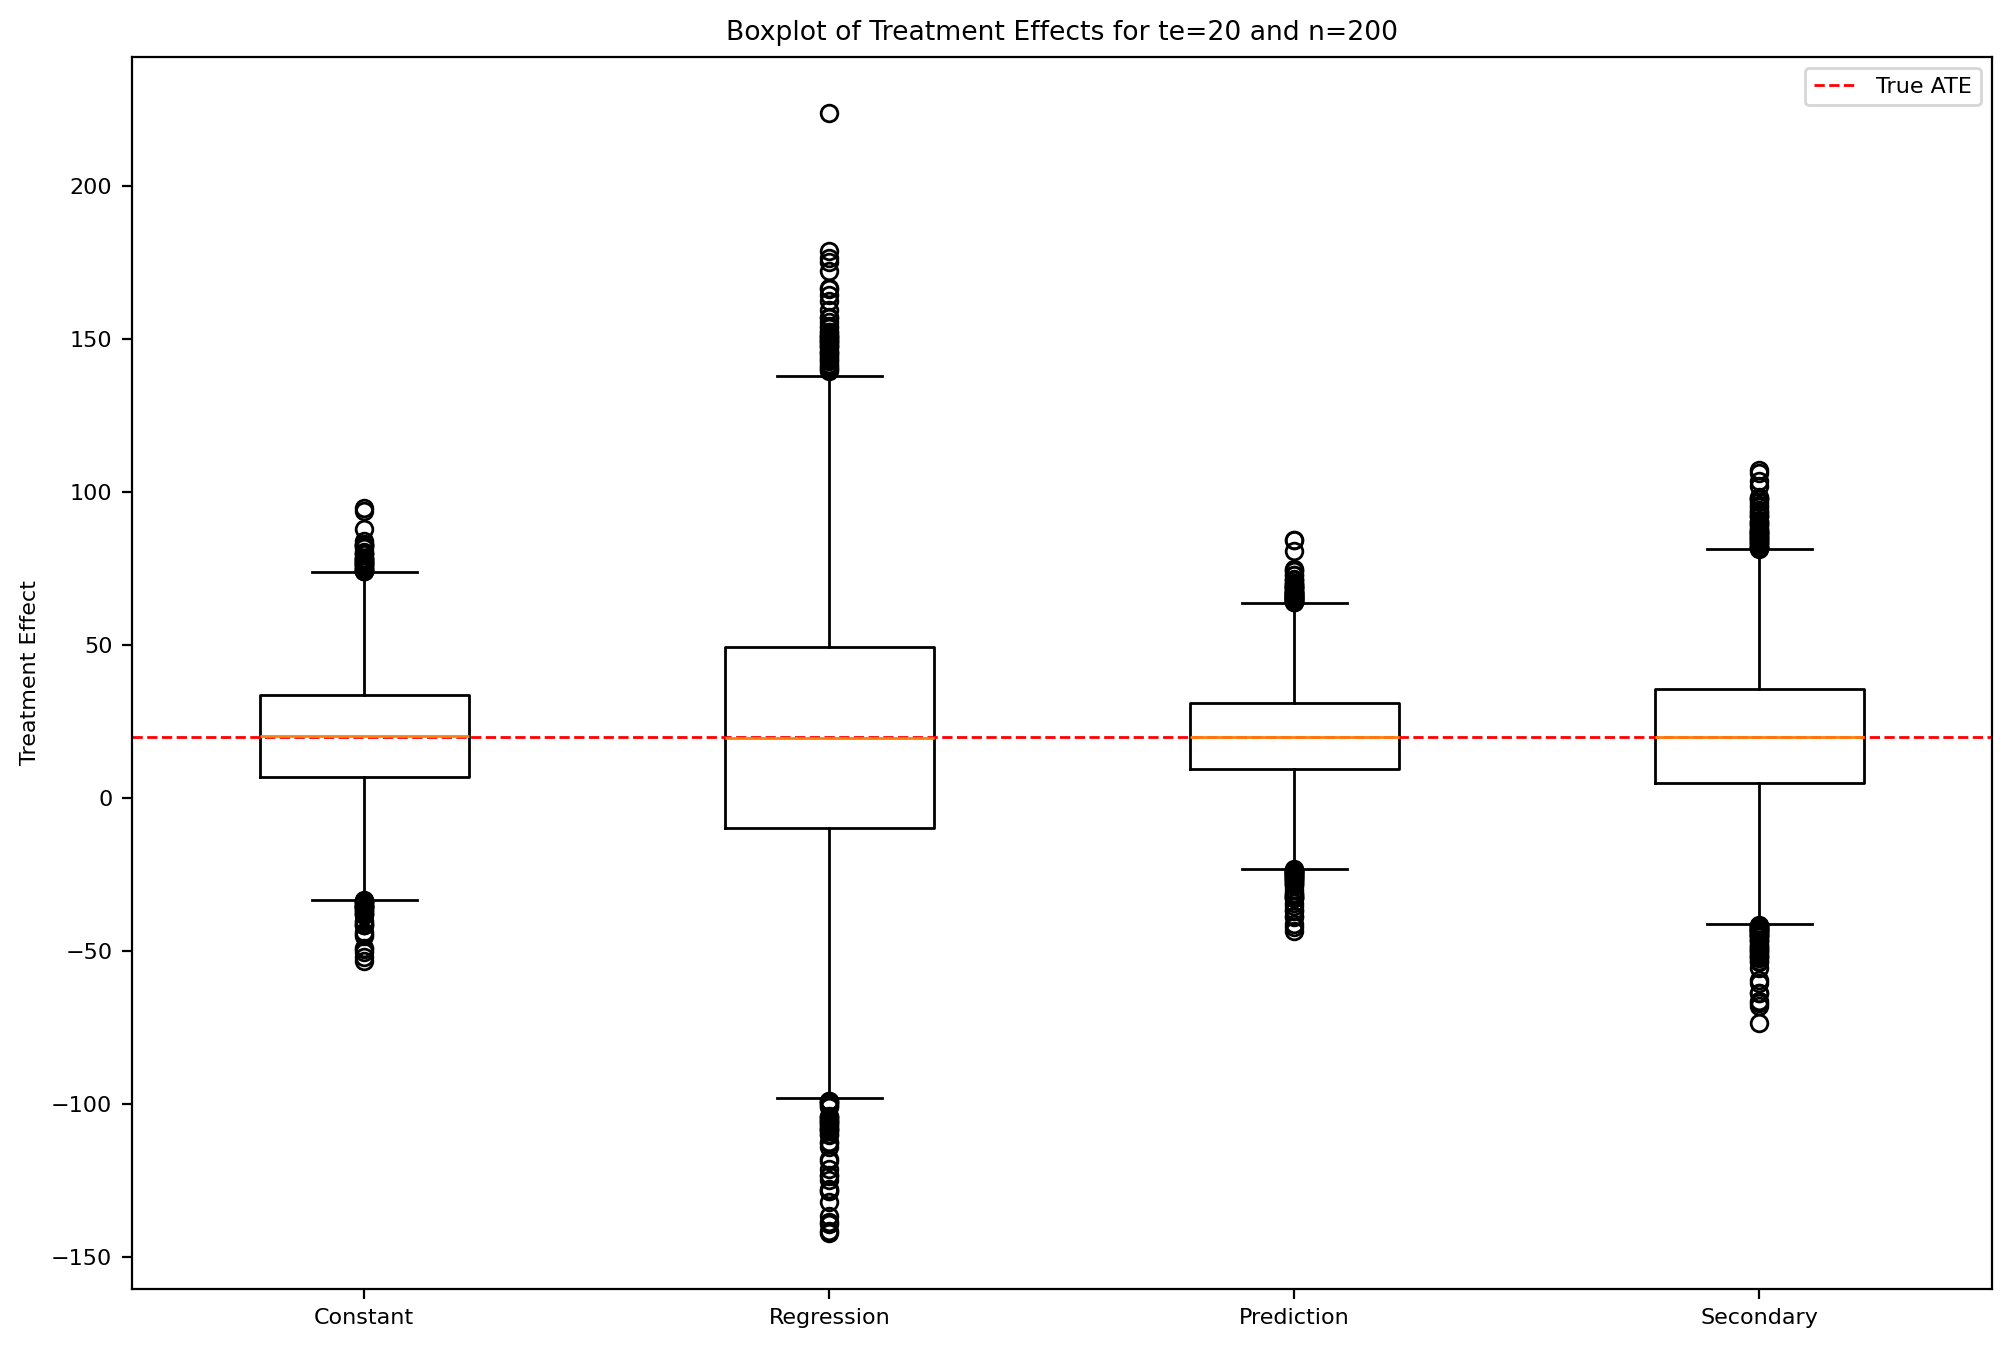

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


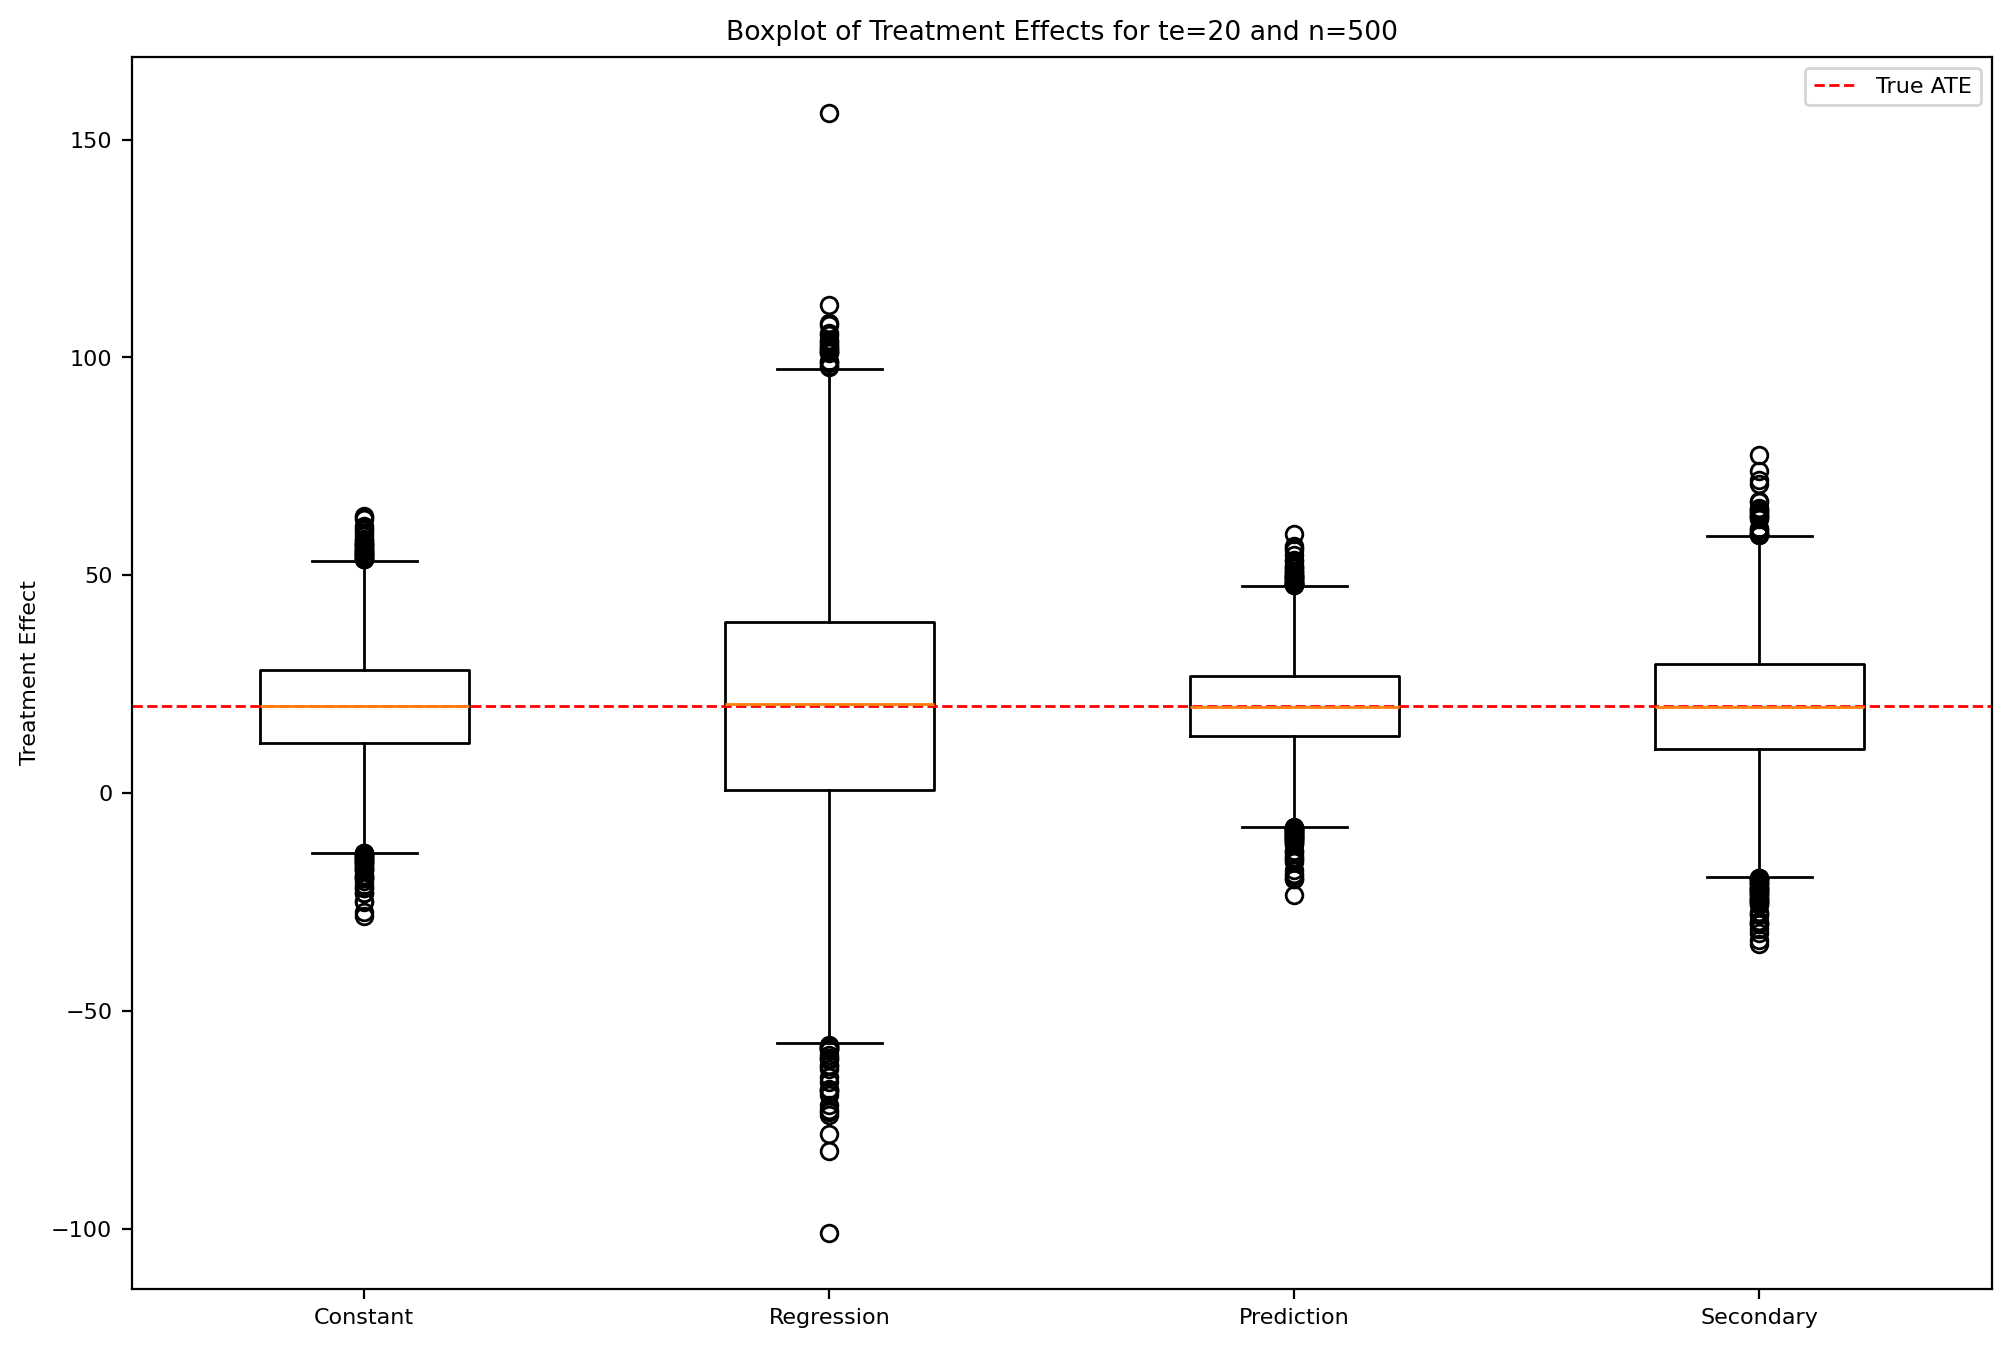

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


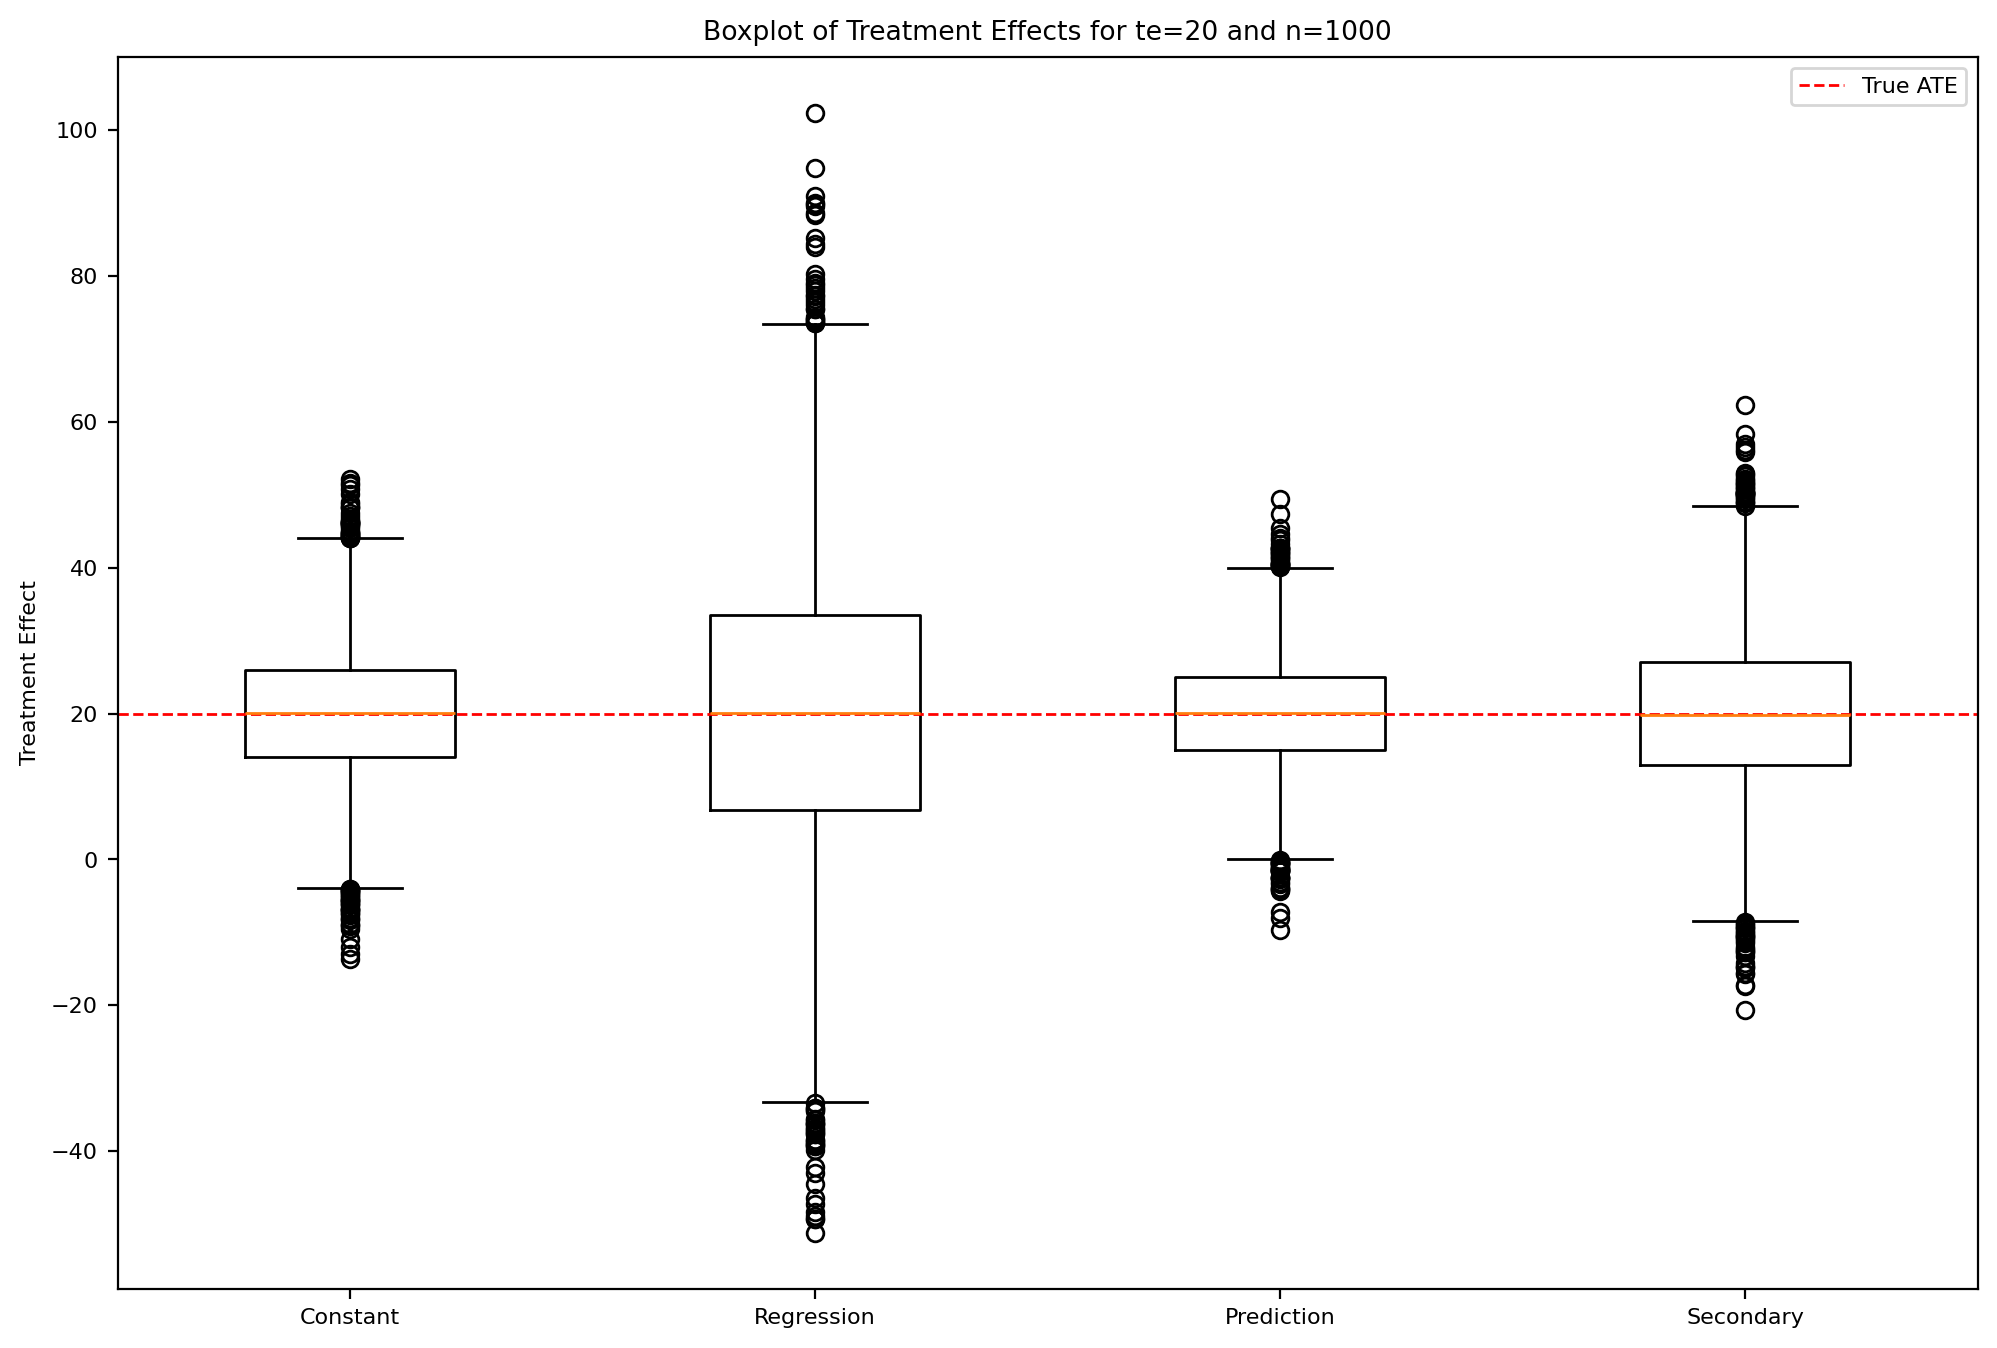

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


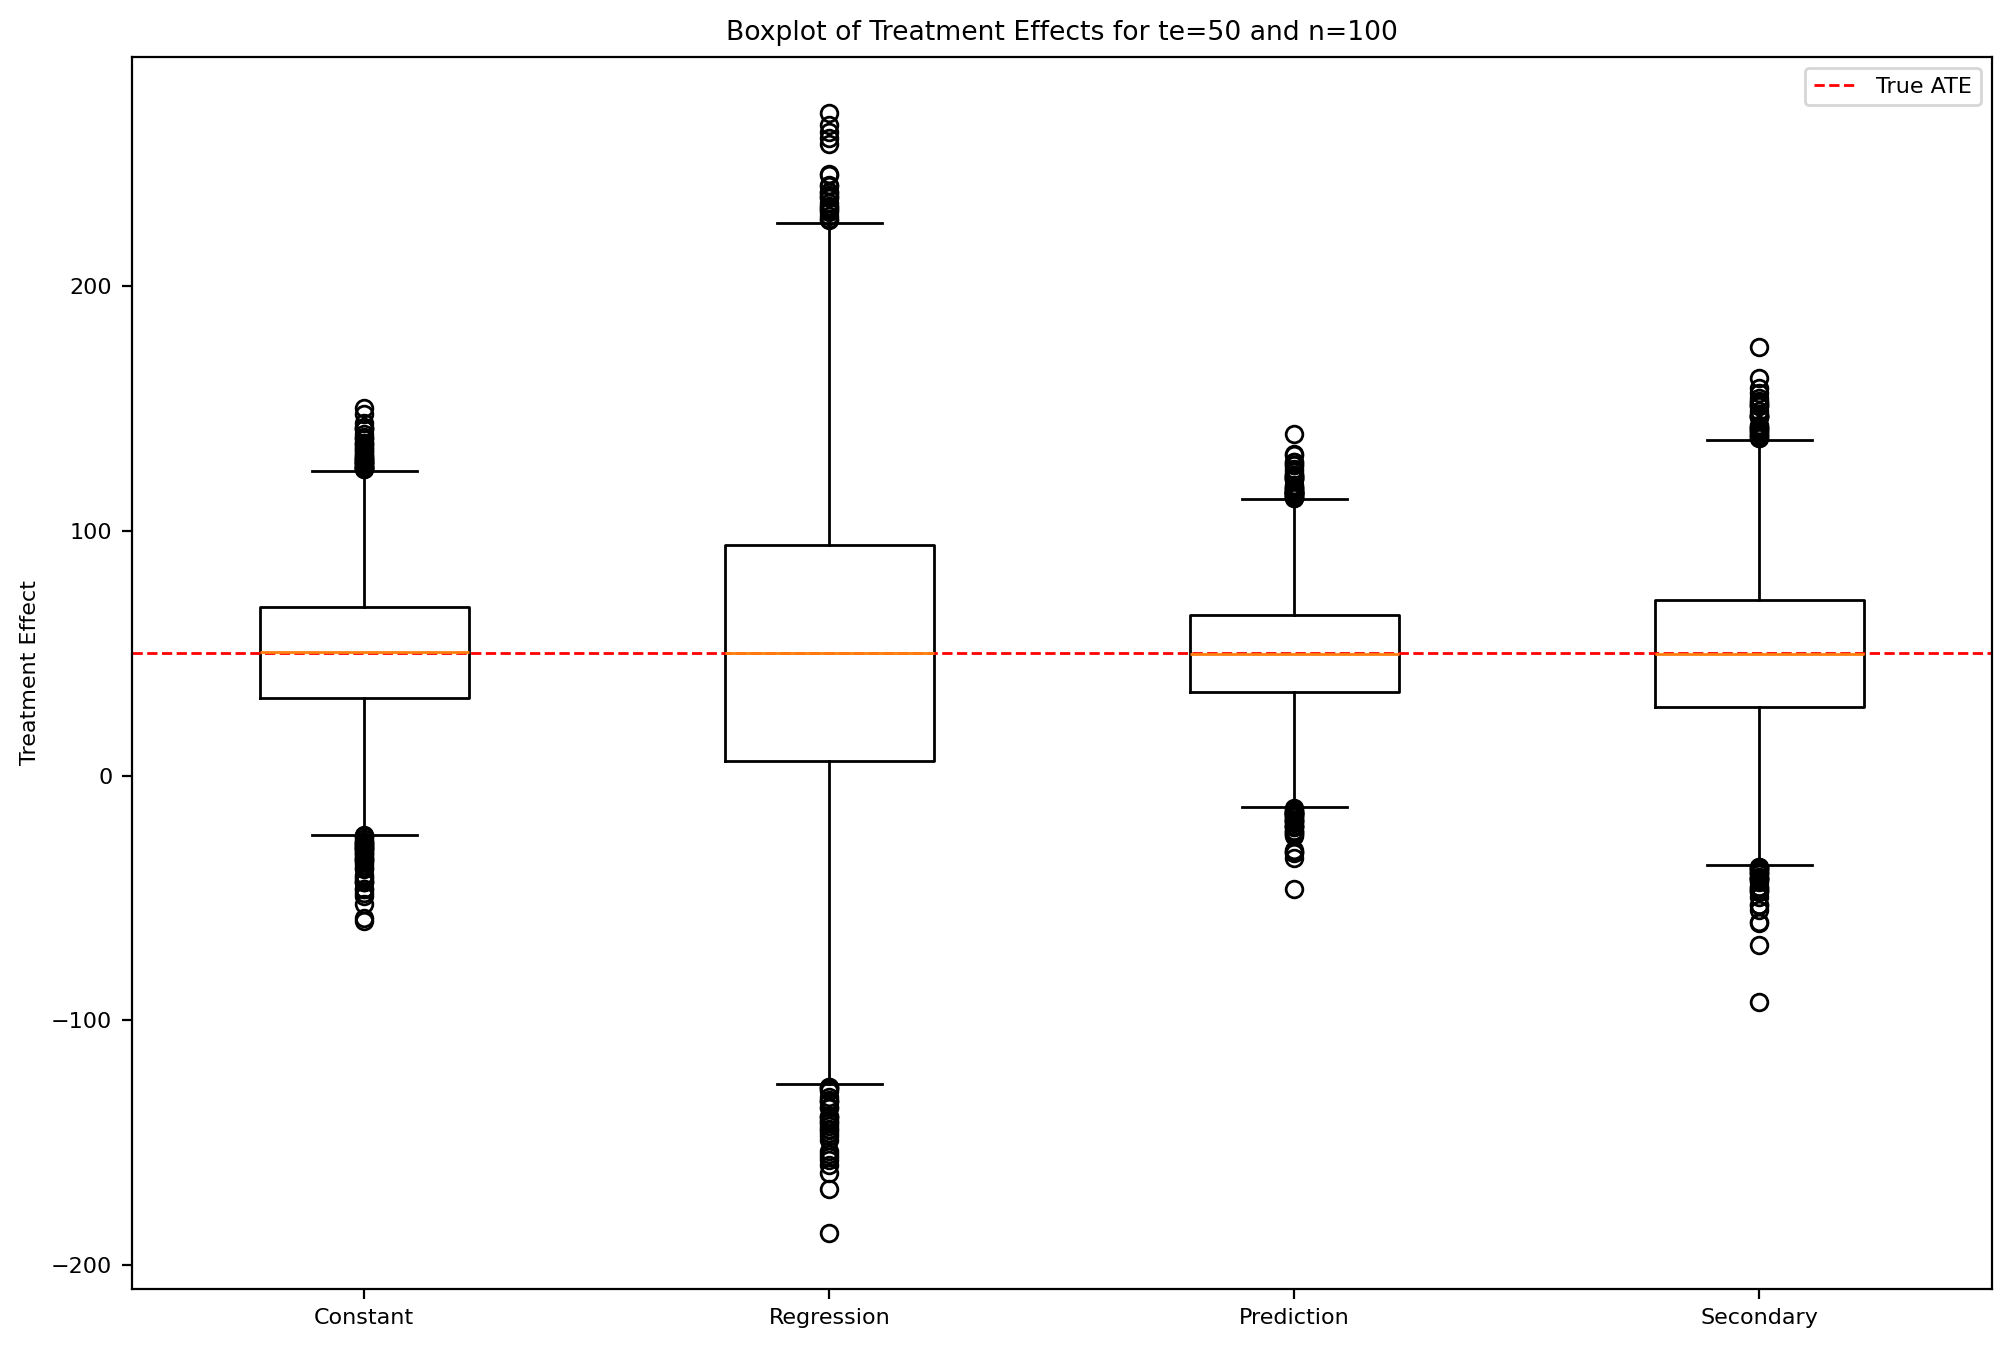

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


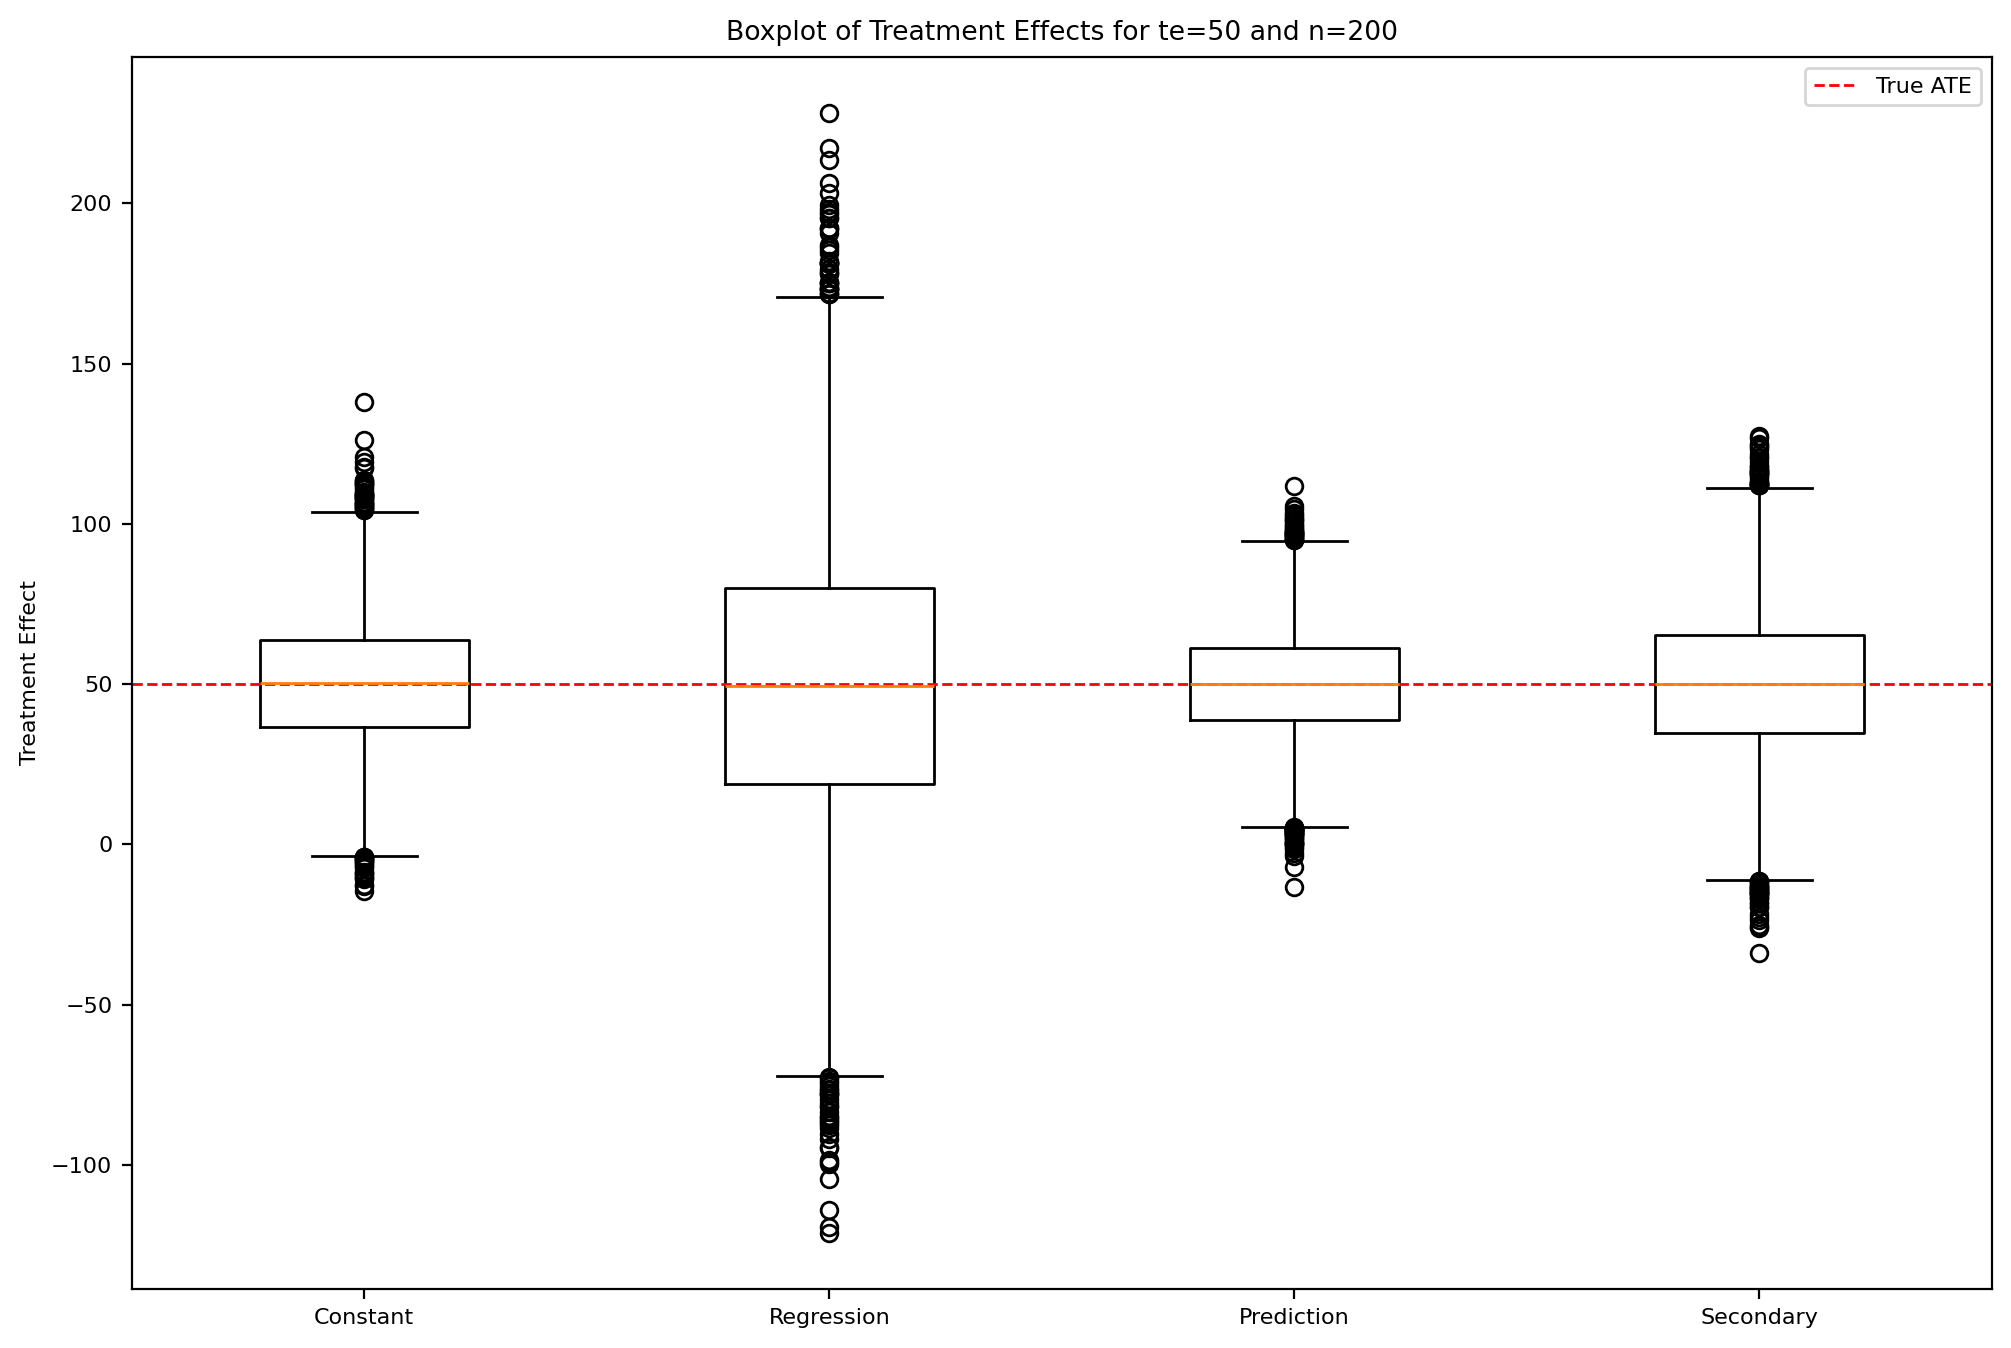

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


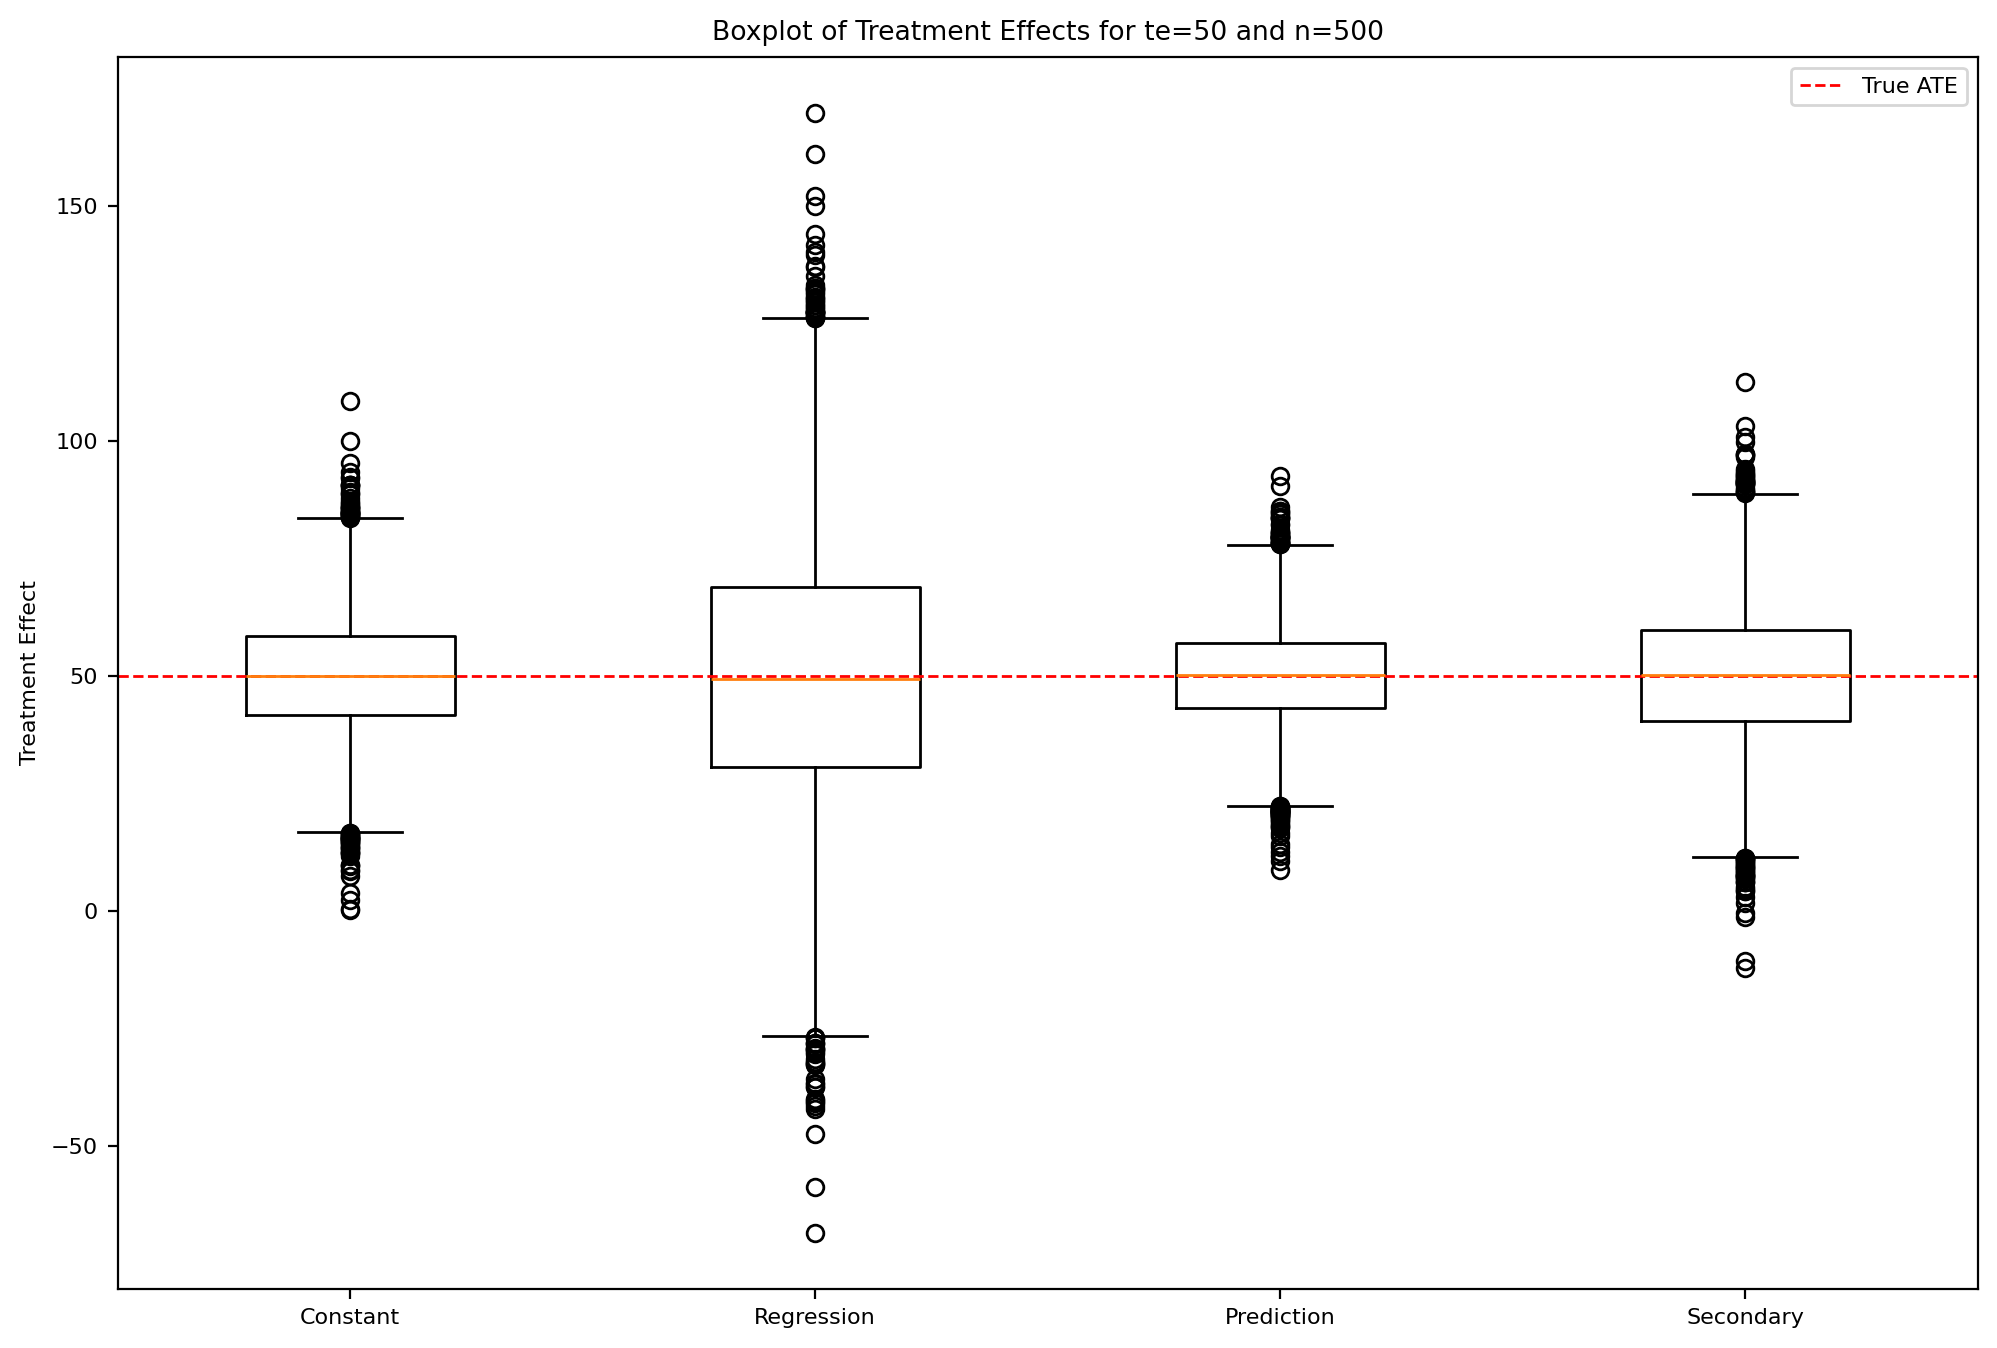

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


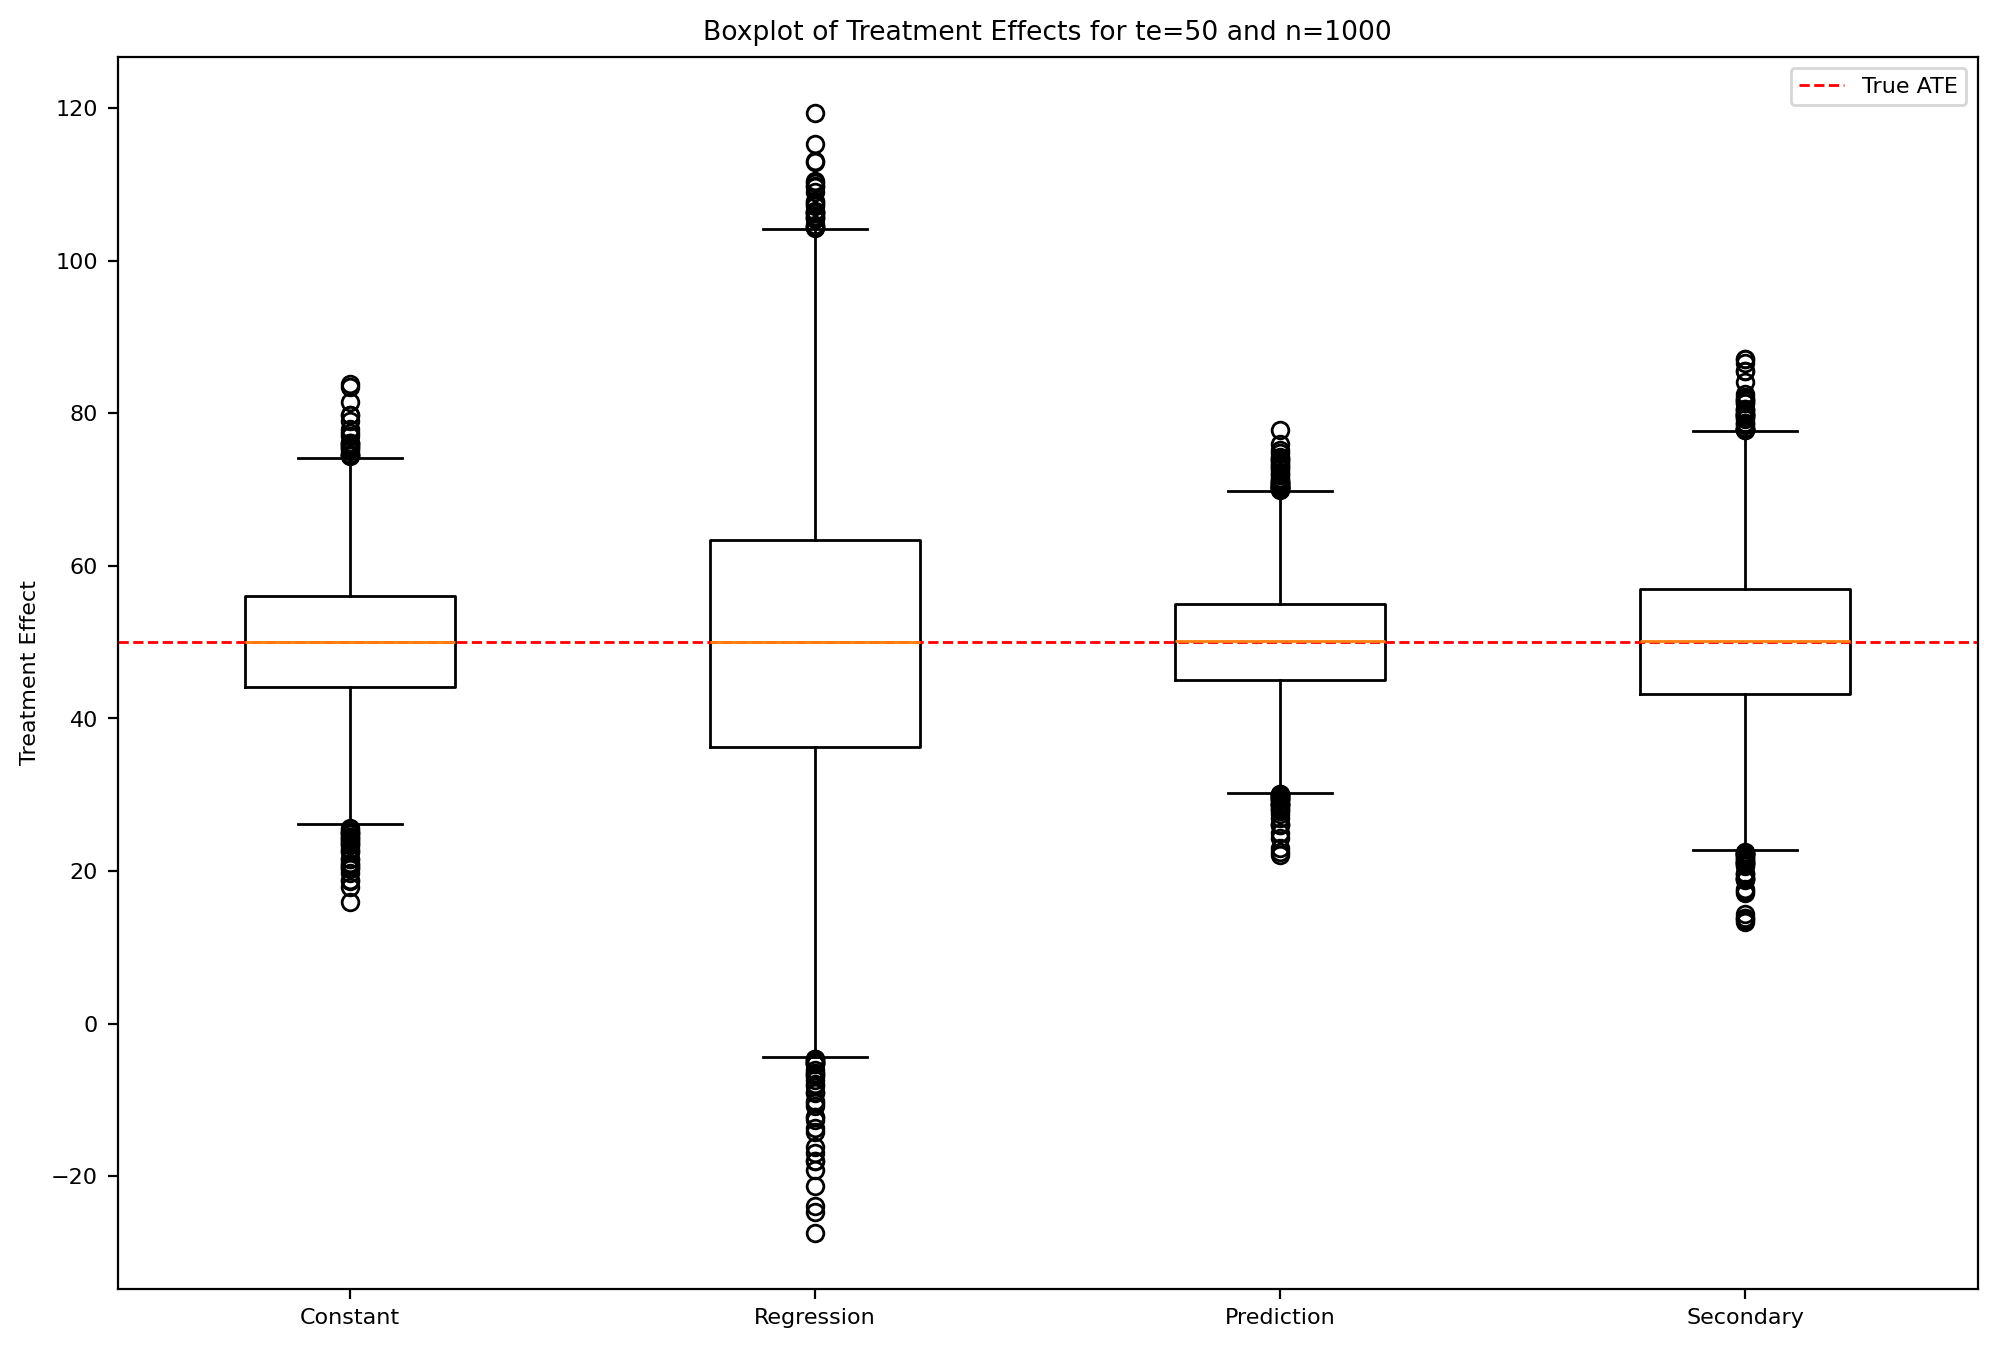

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


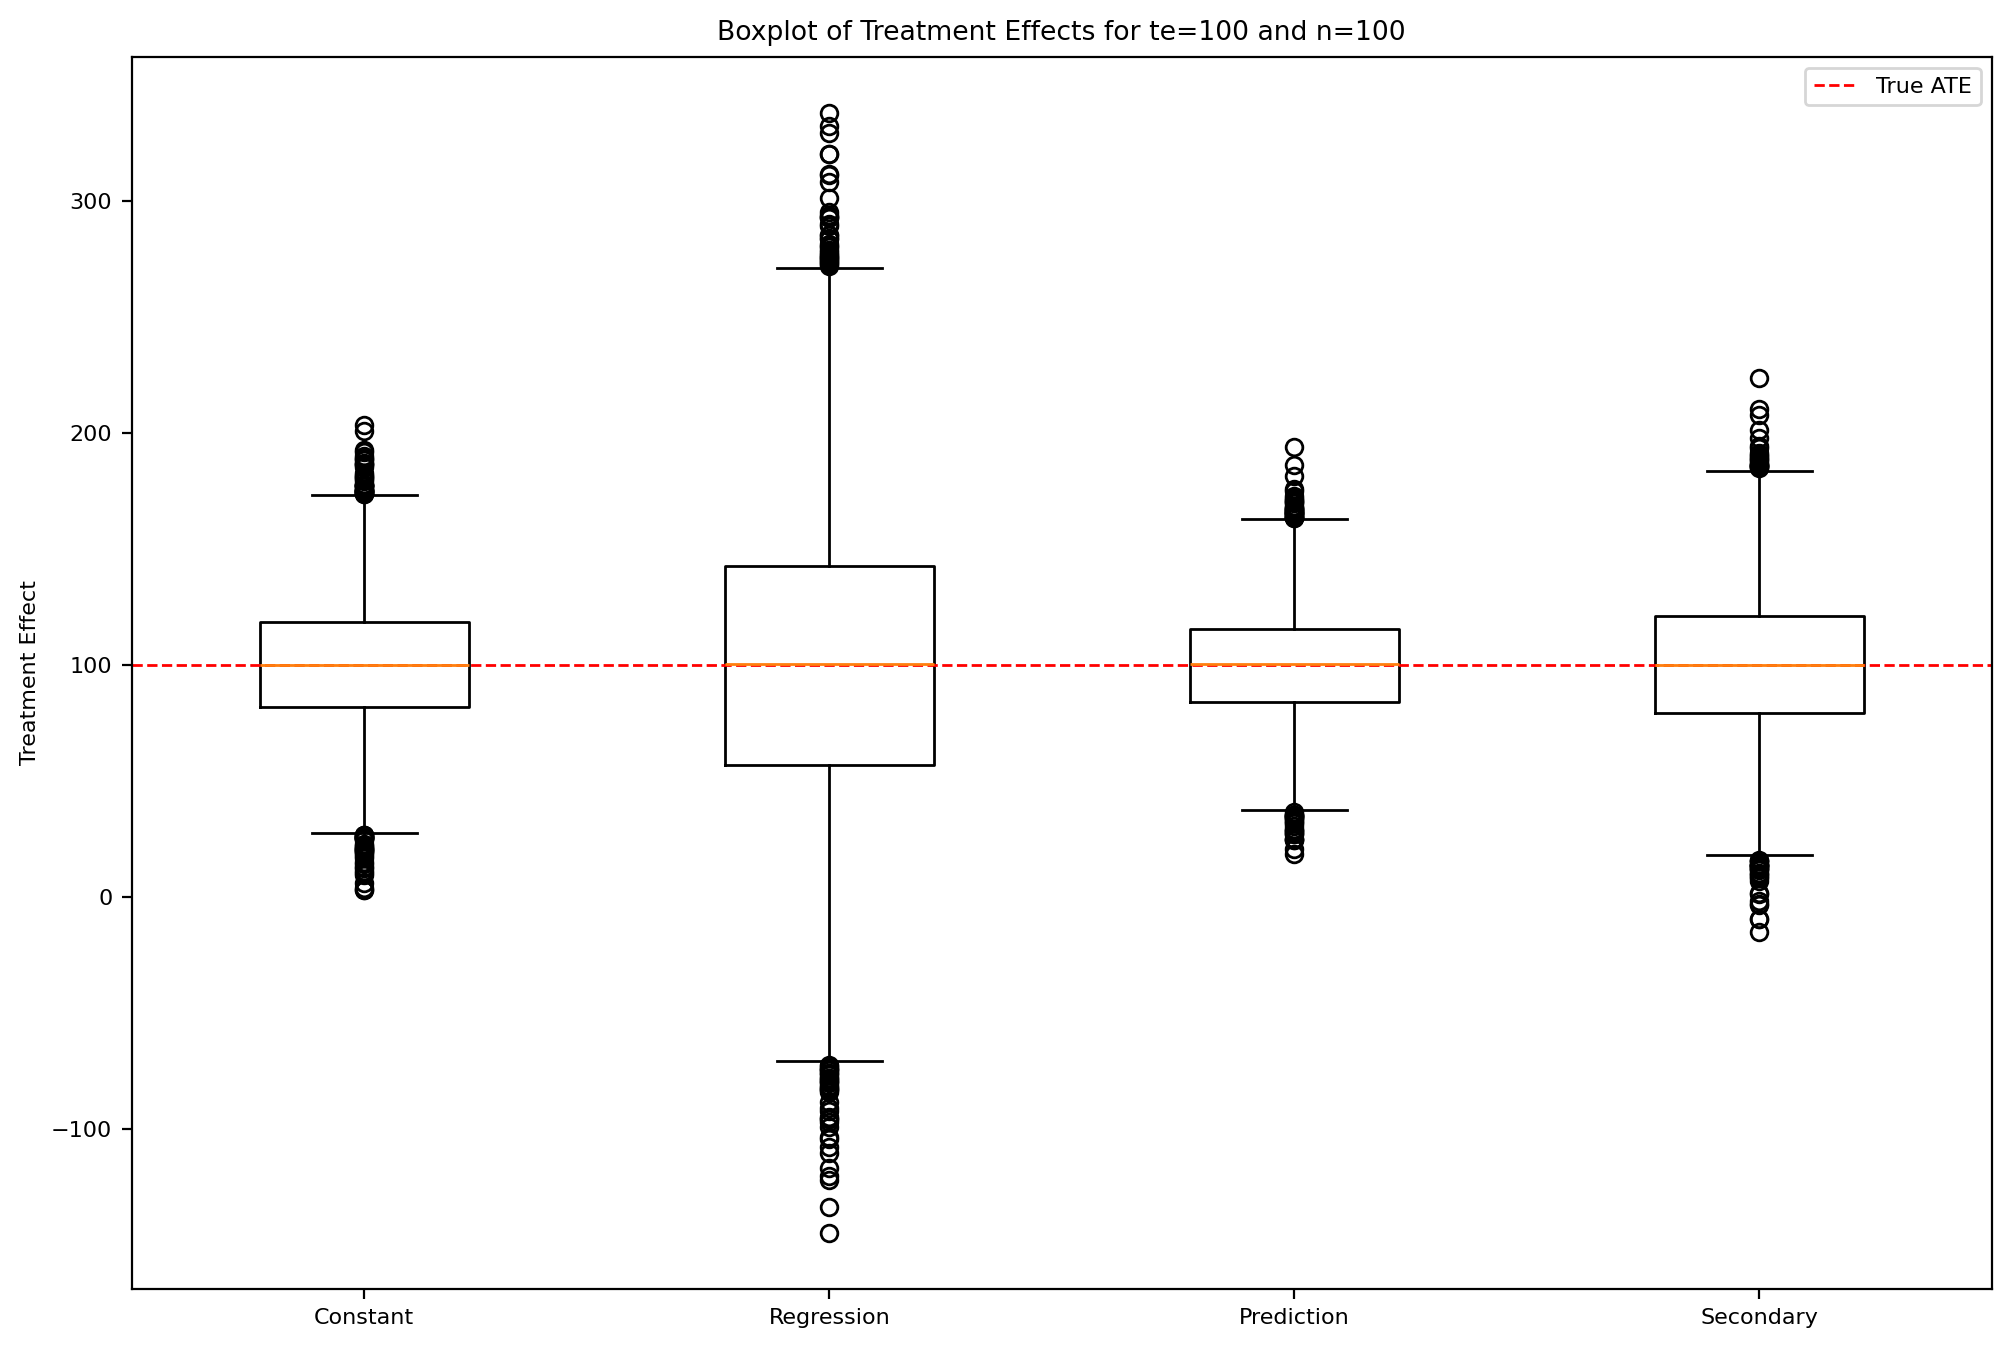

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


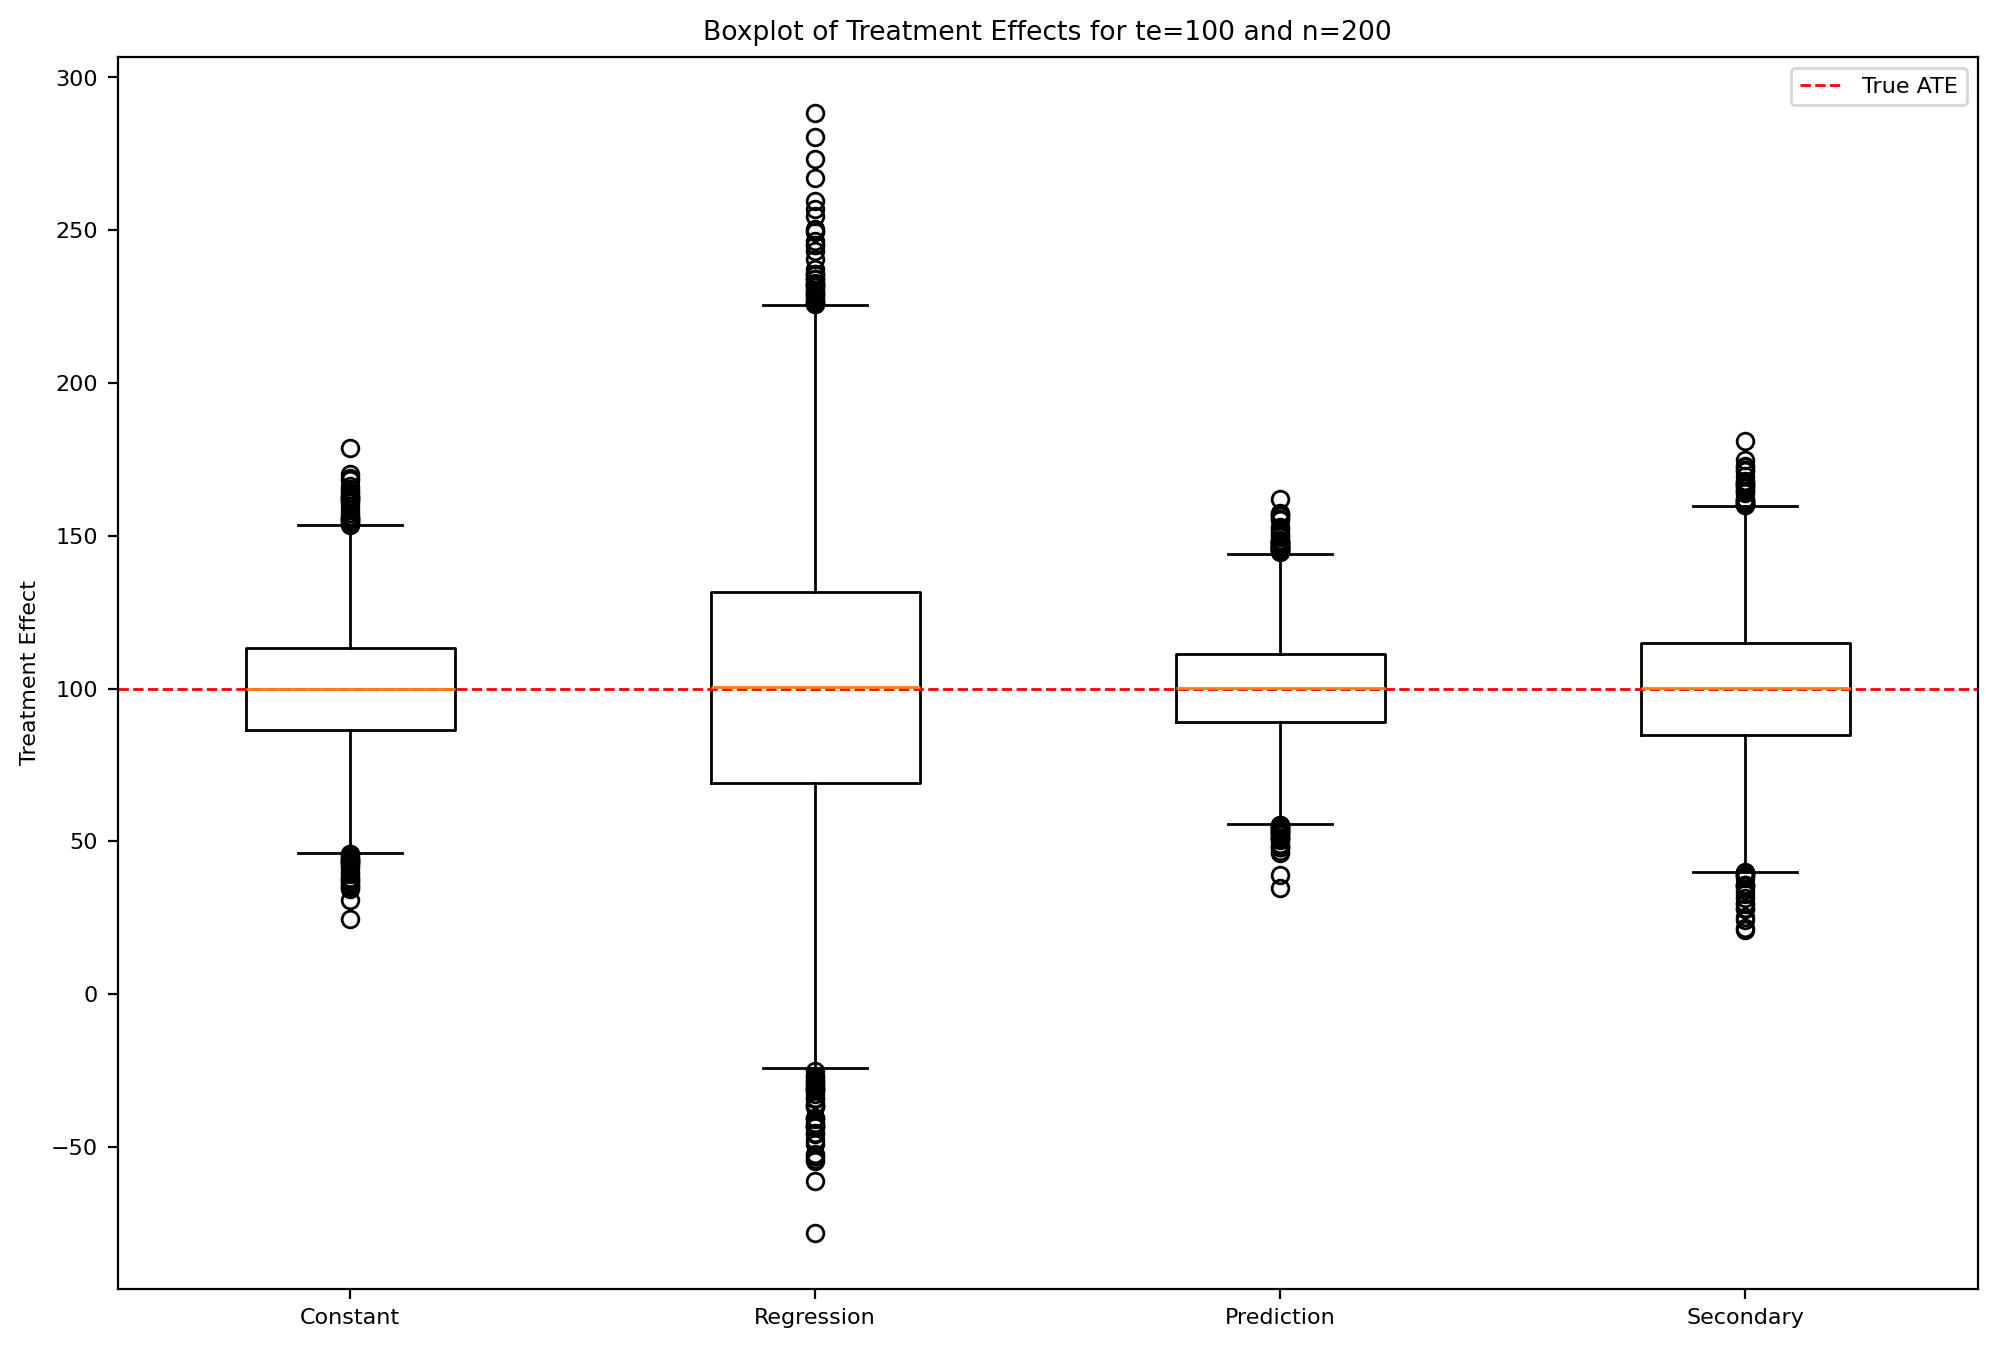

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


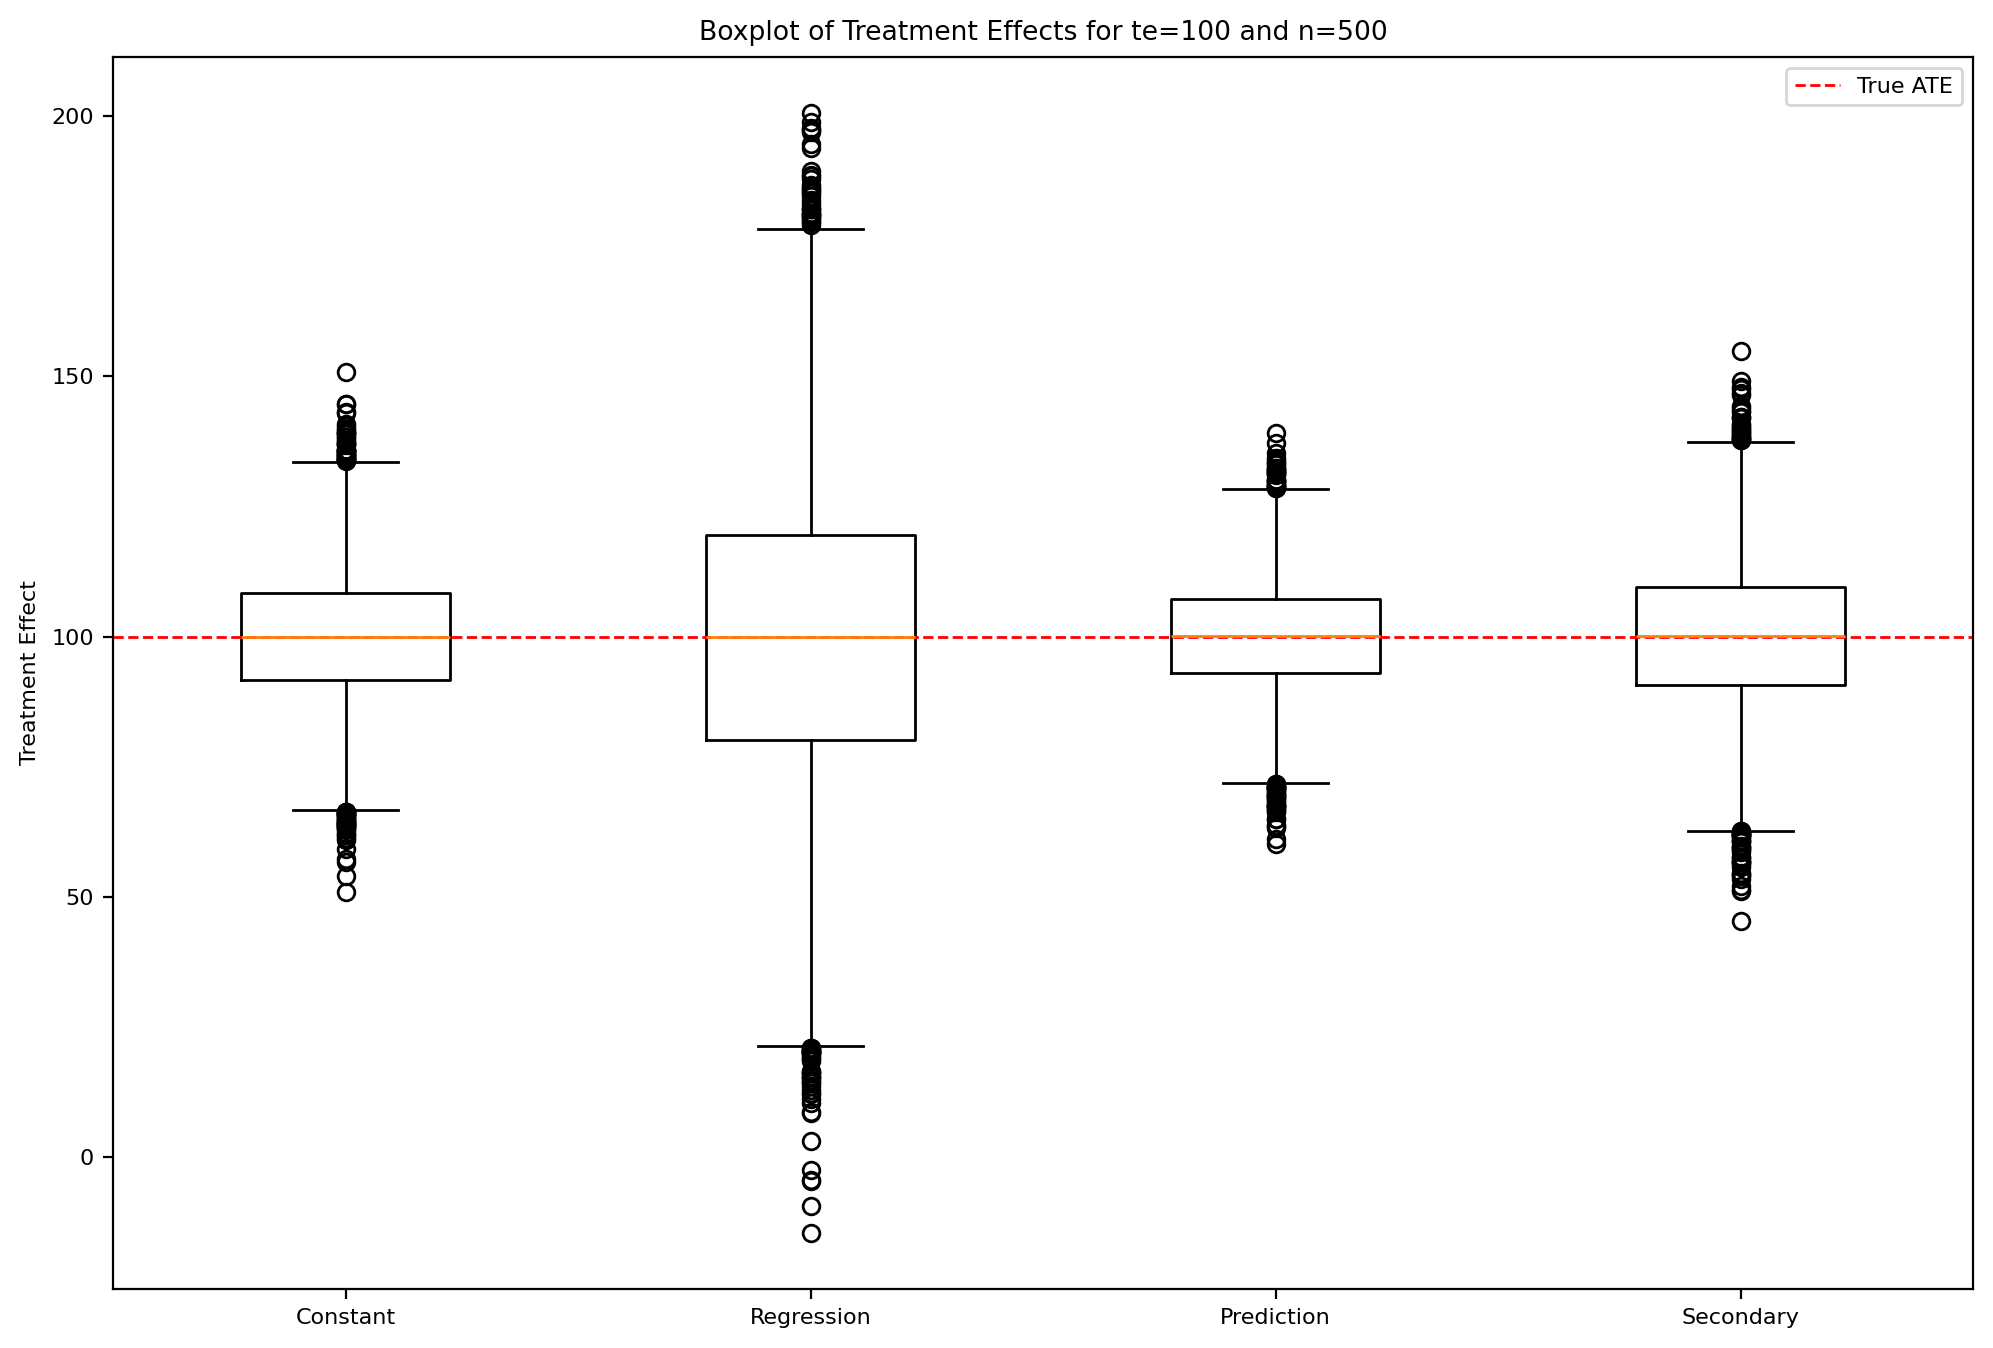

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


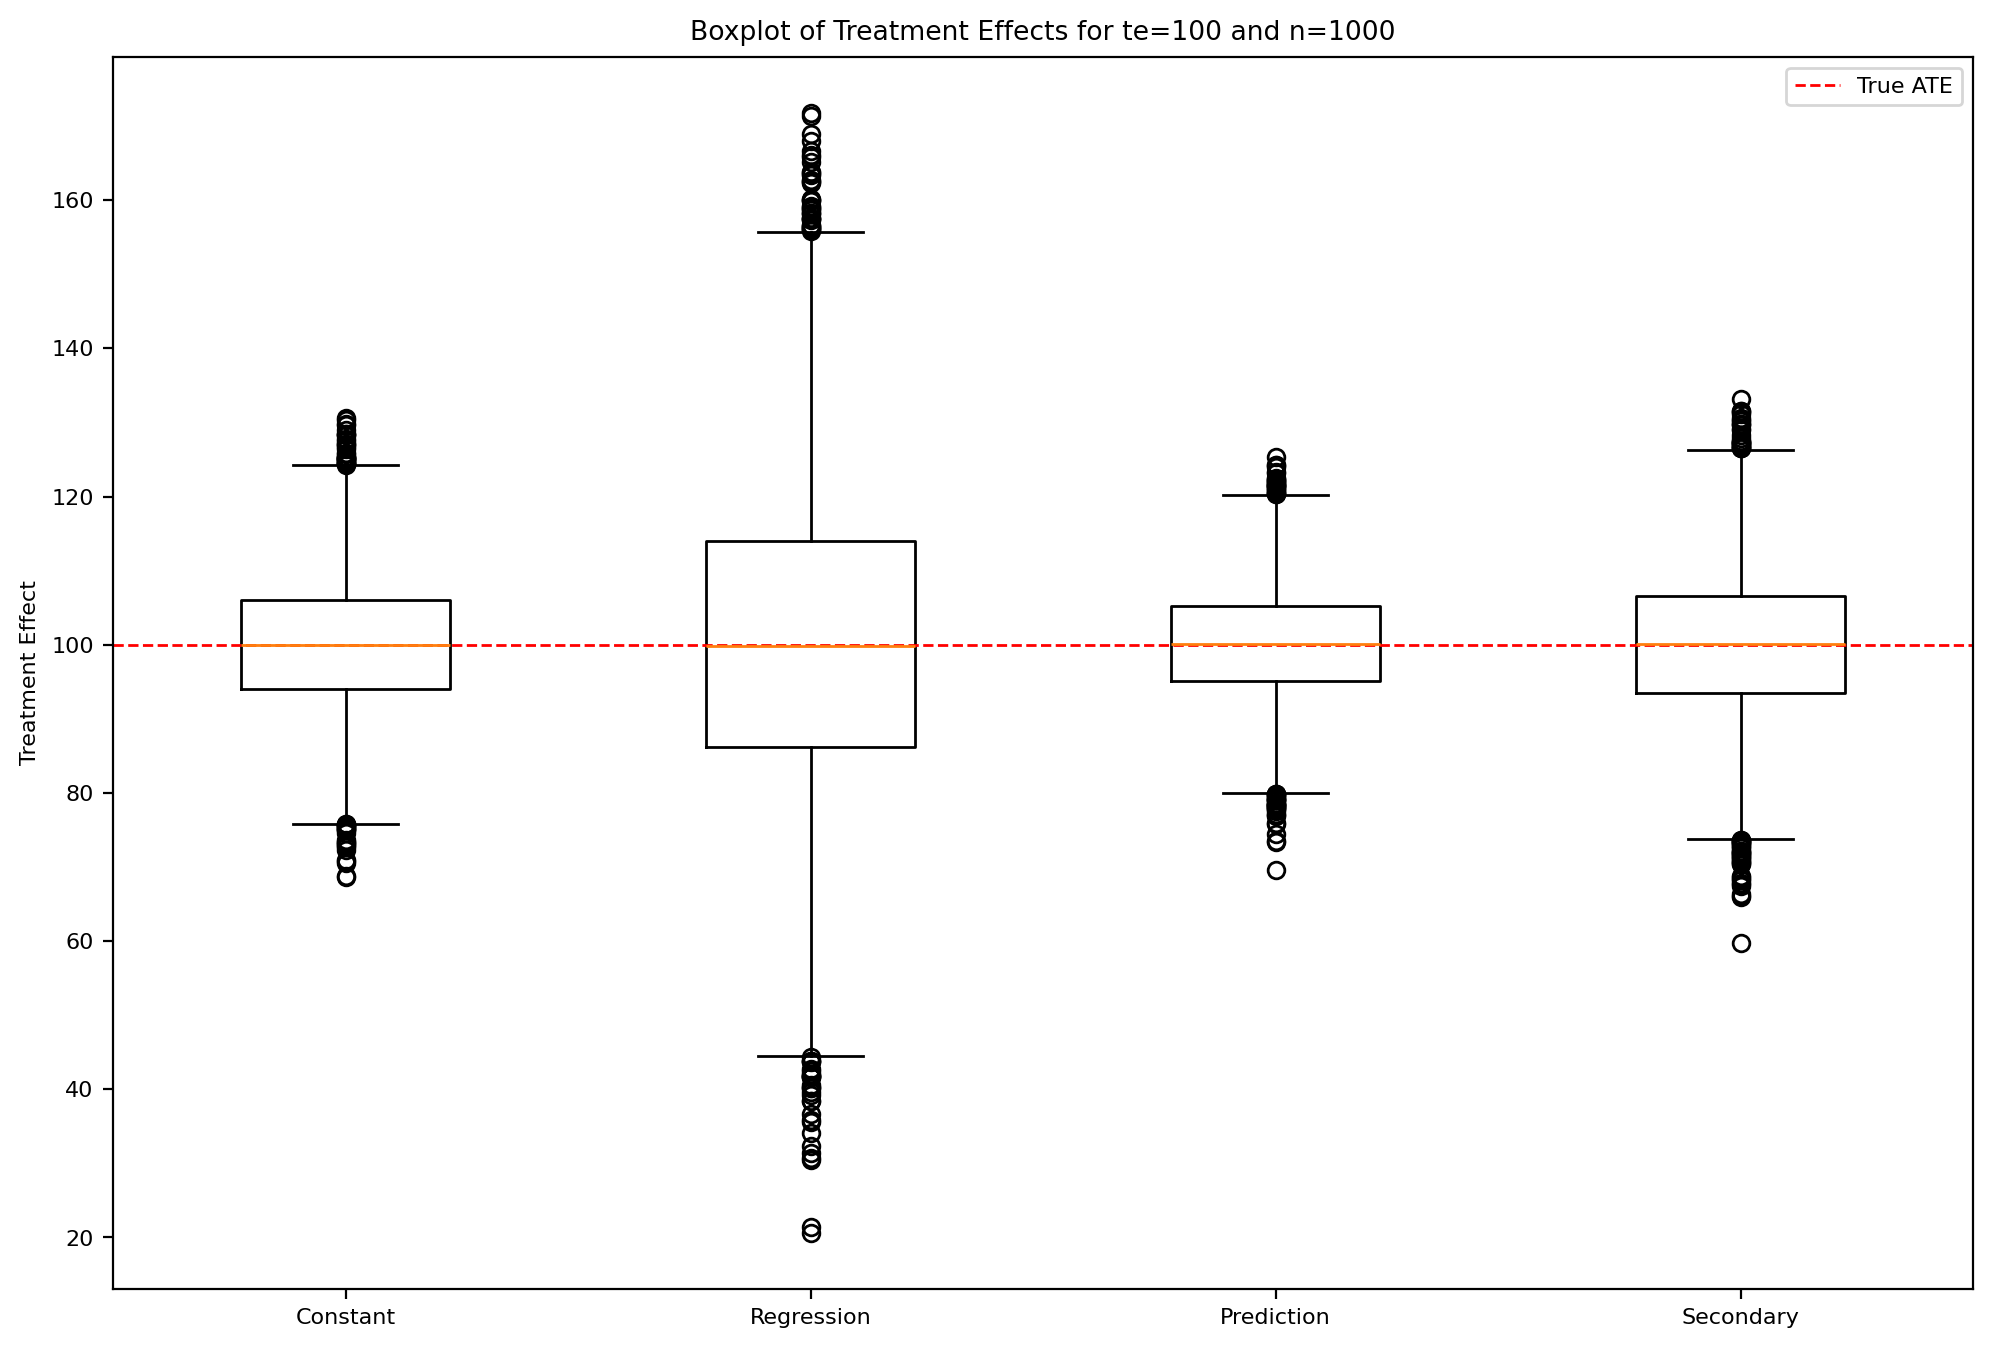

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


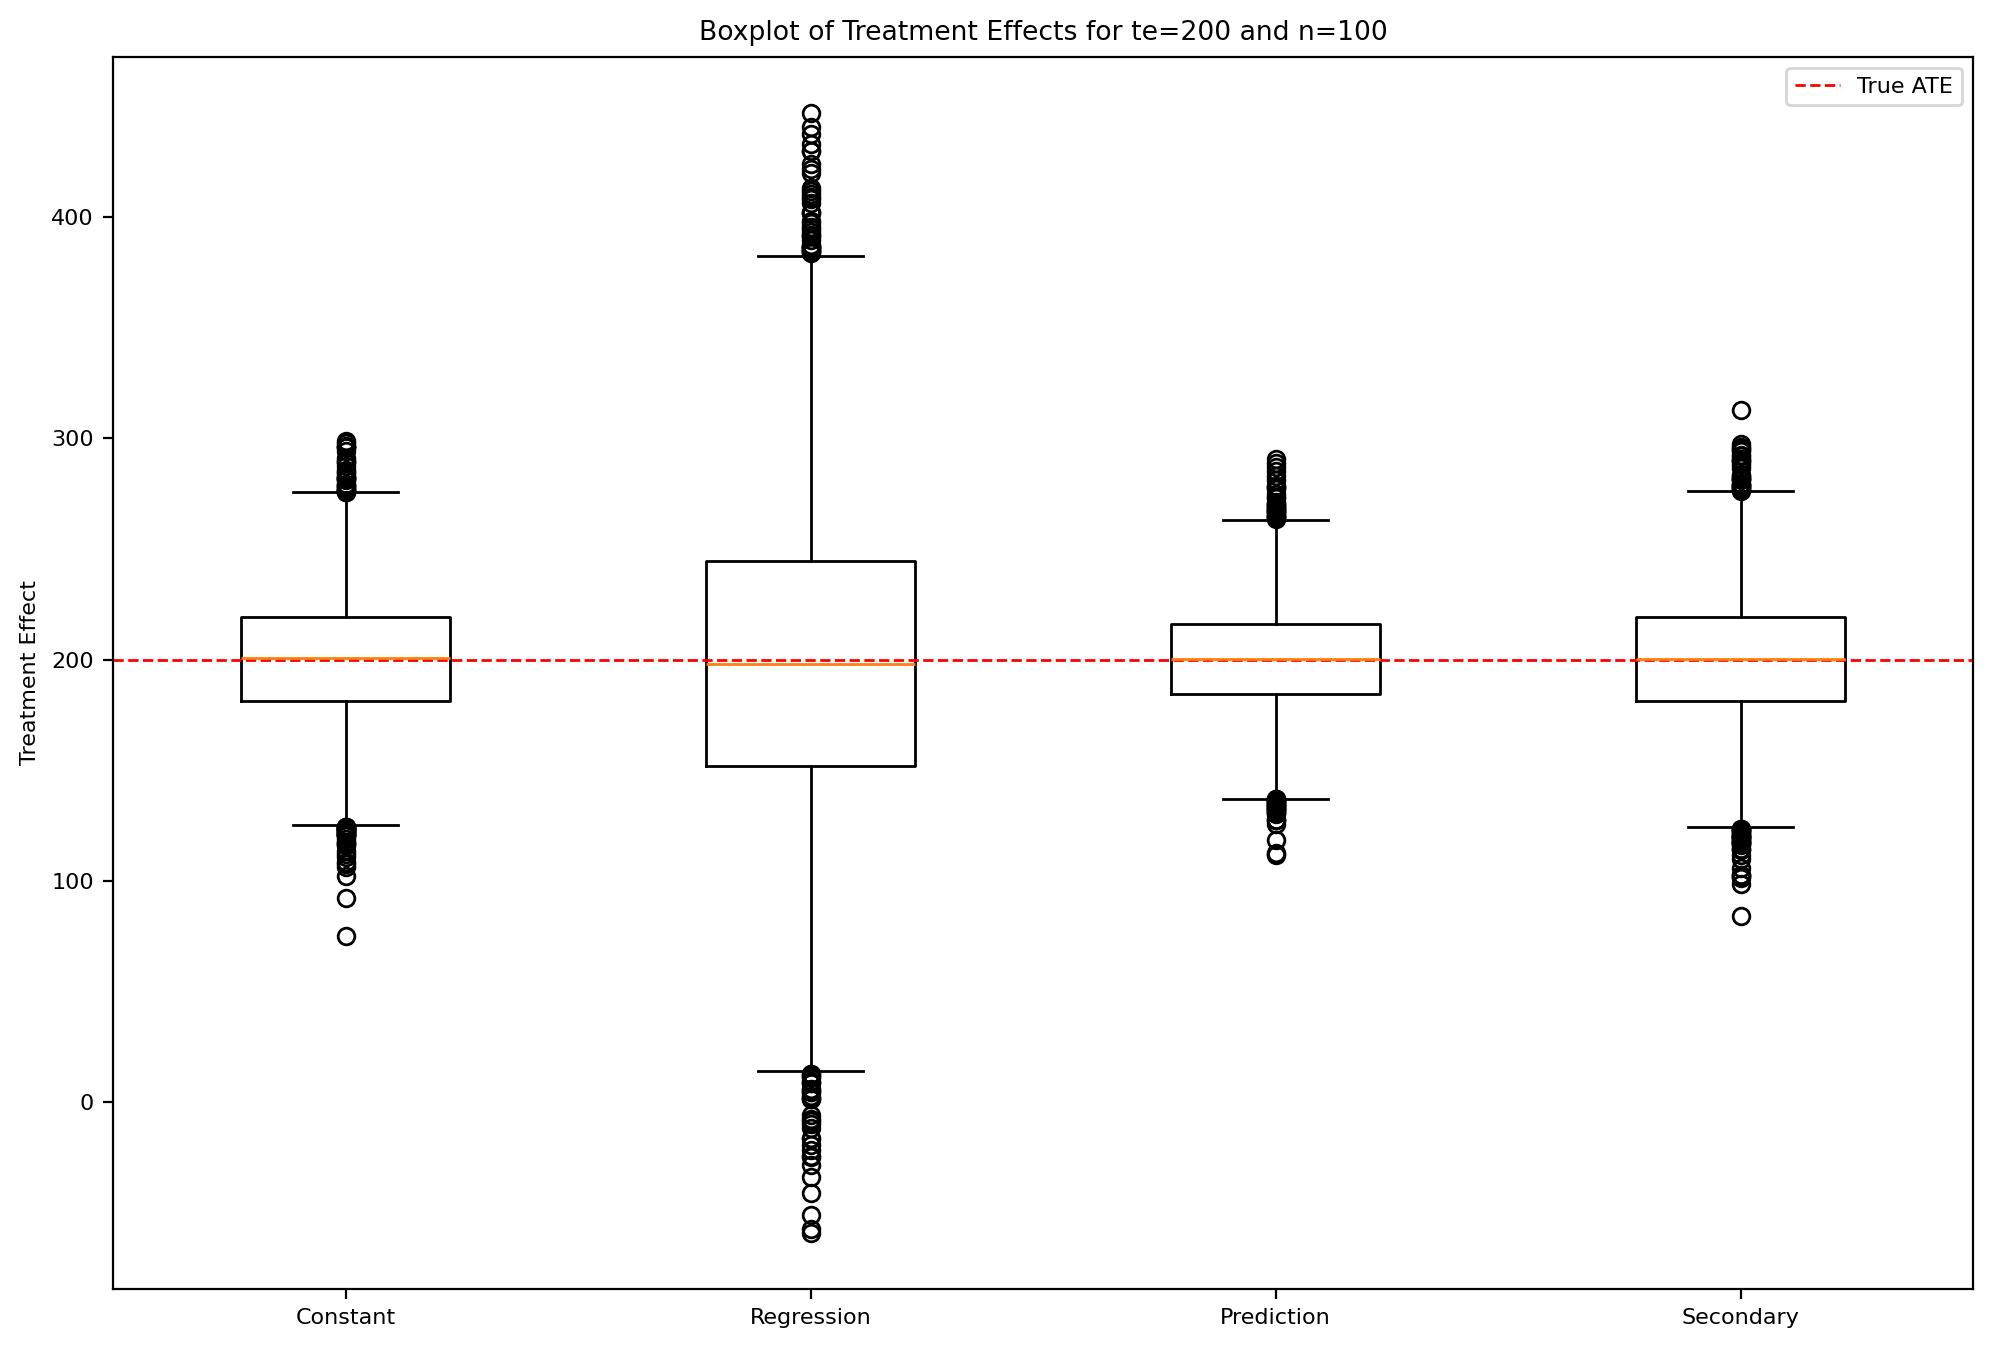

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


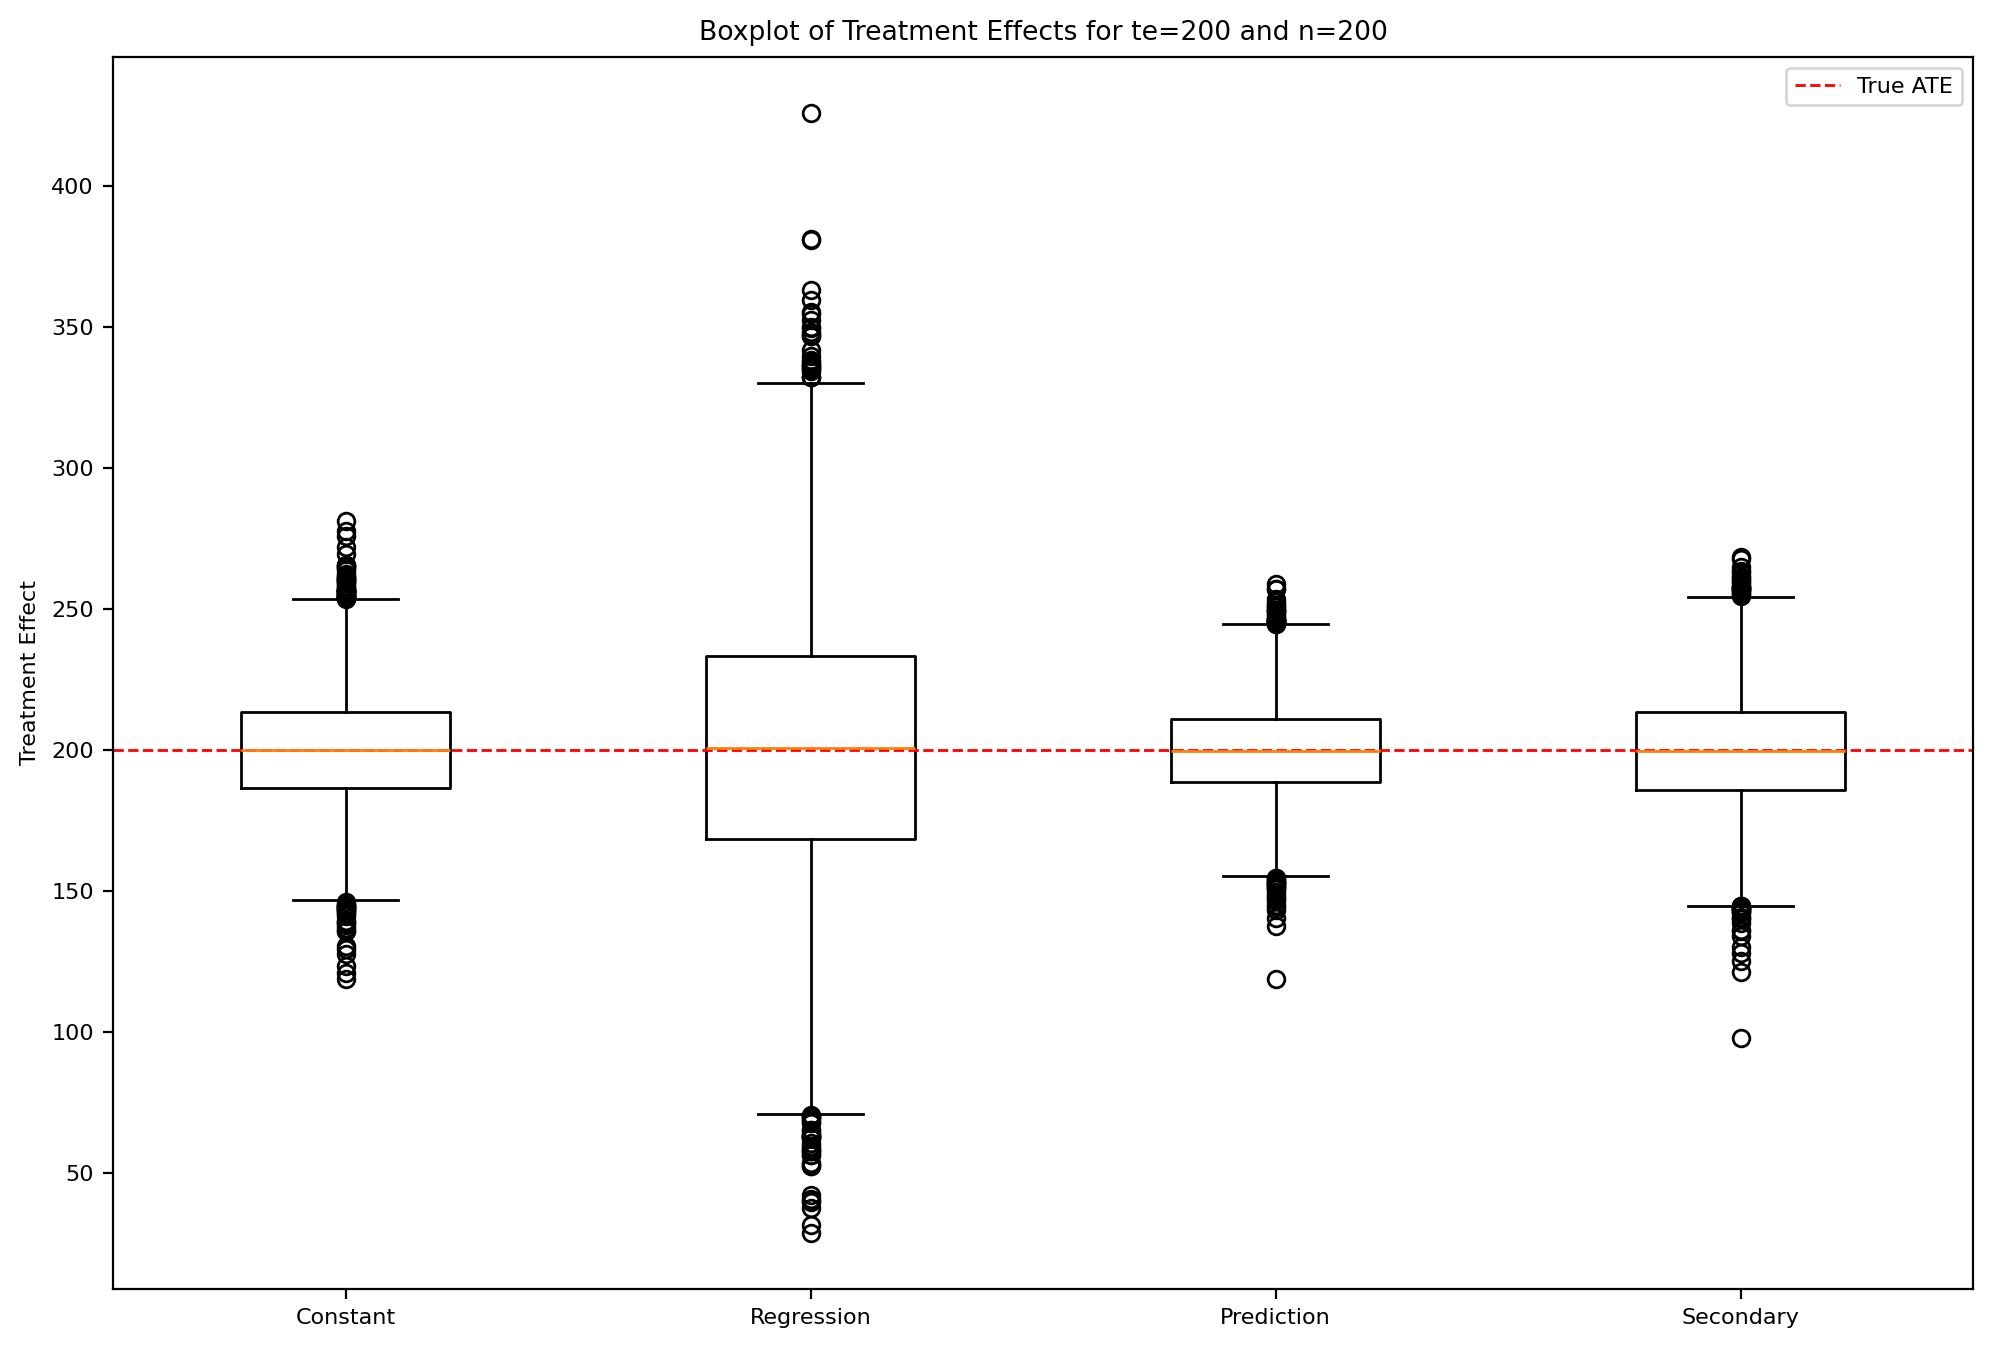

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


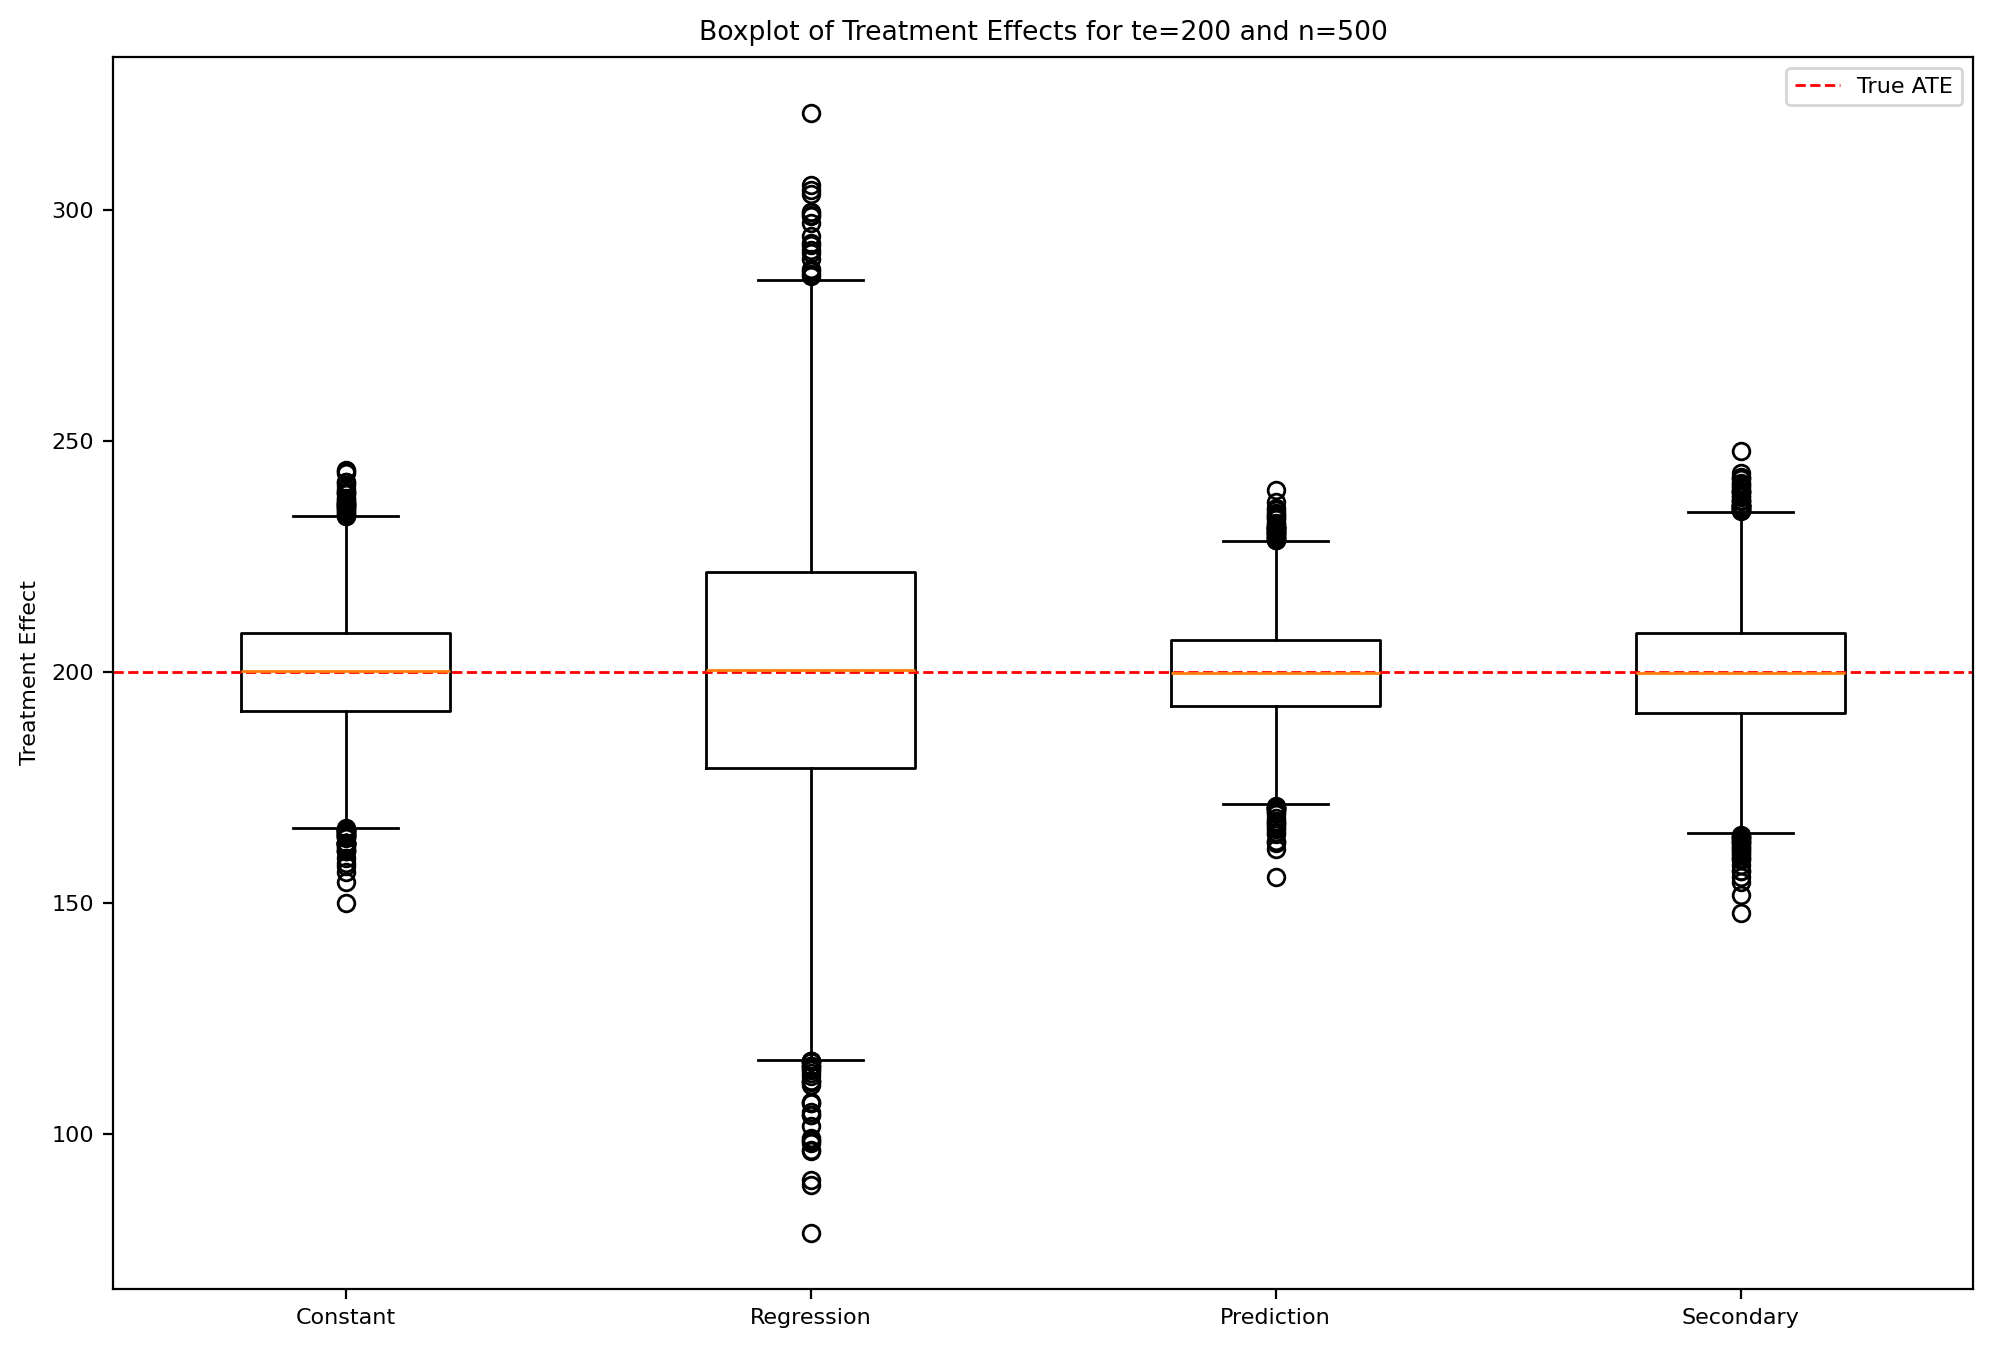

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


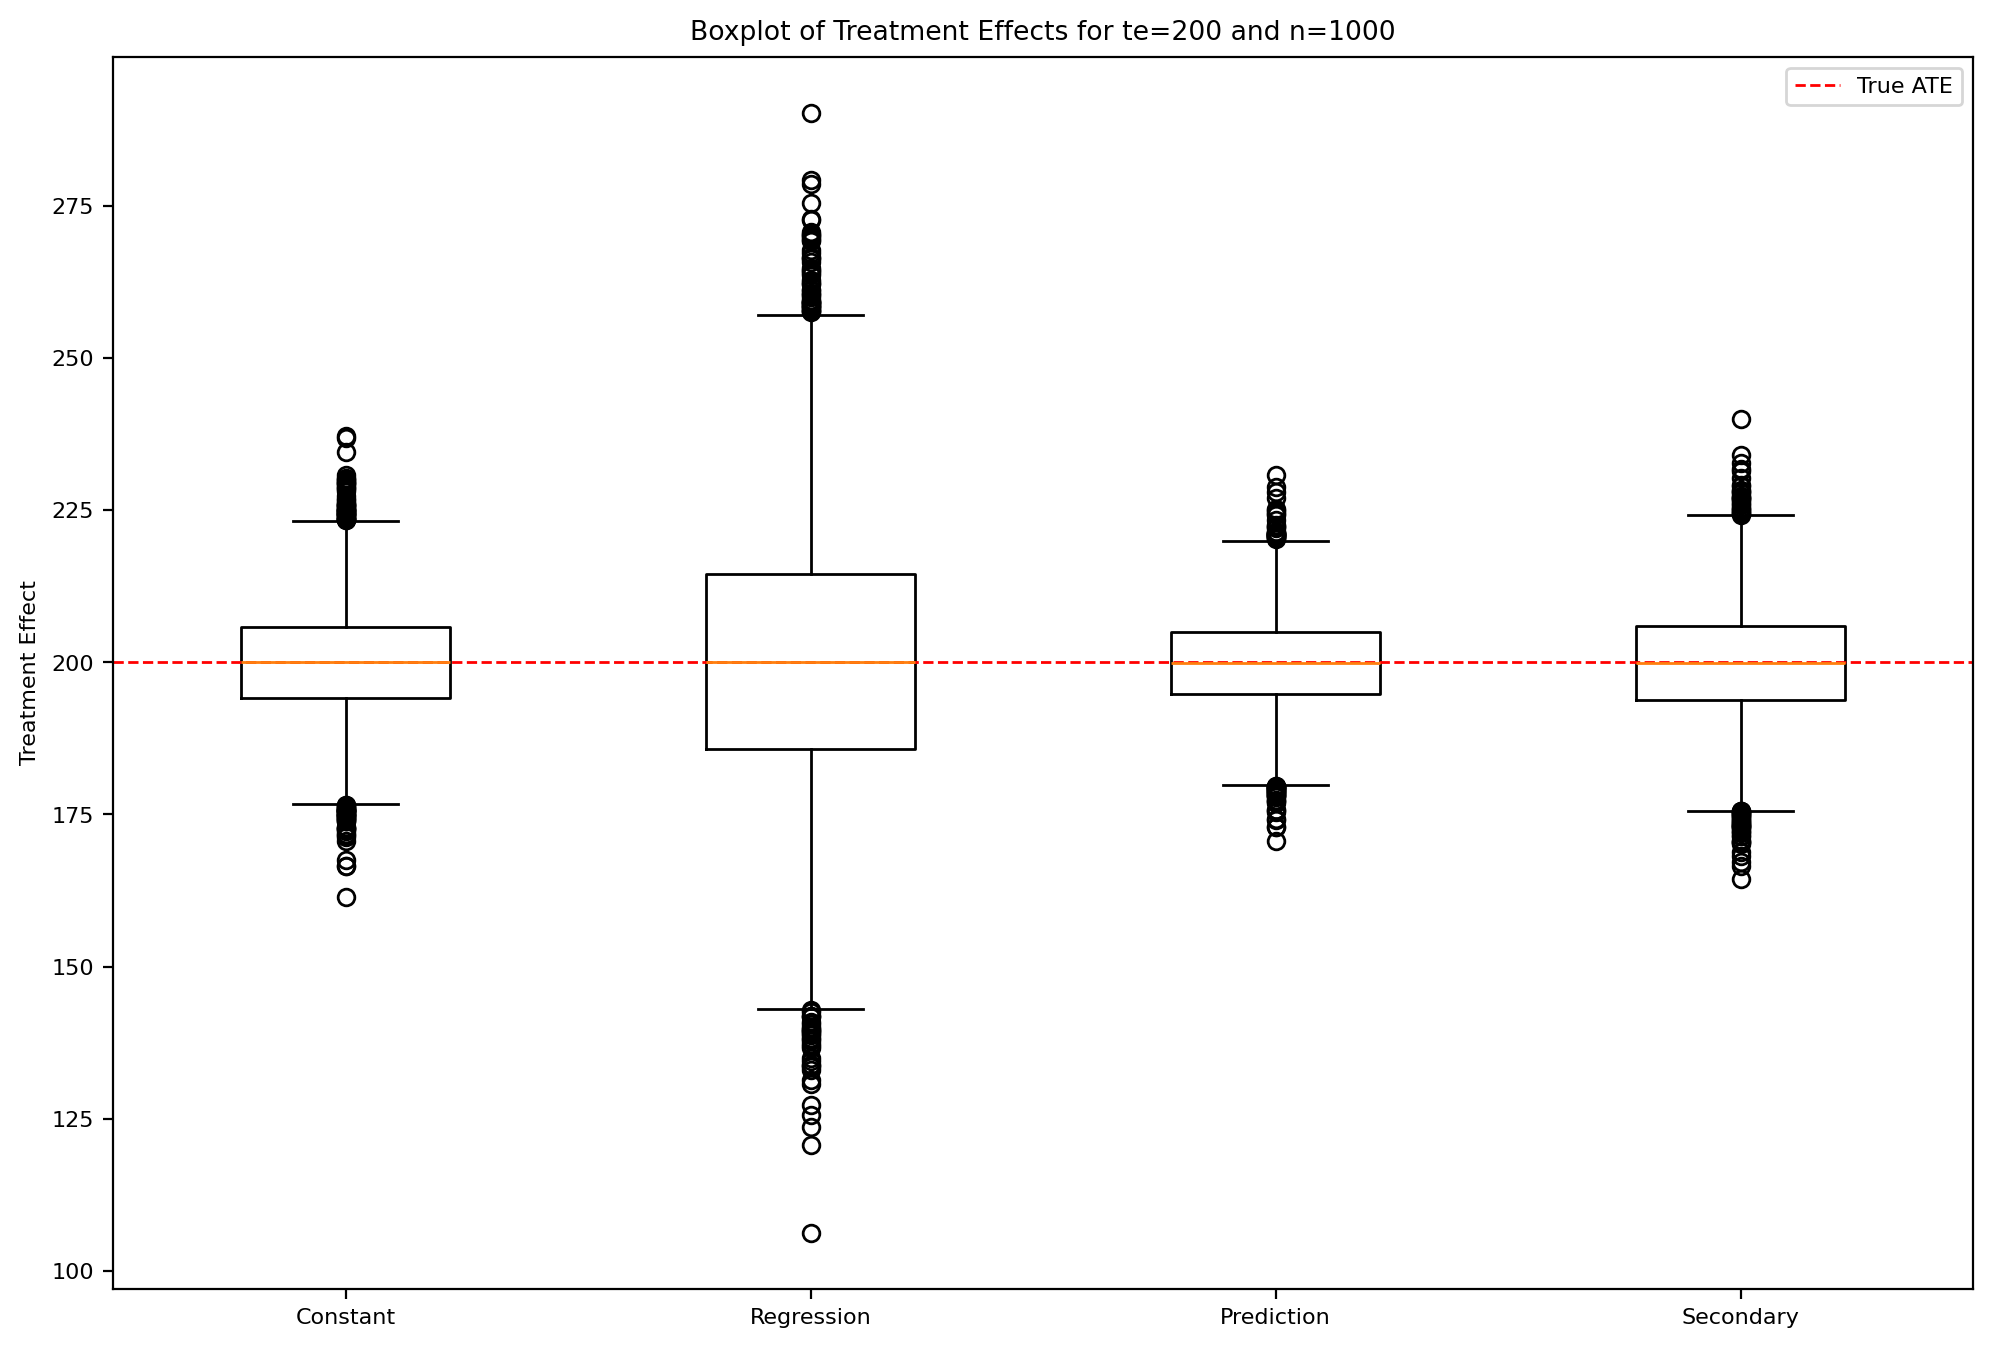

In [44]:
# Create boxplots for each combination of te and n
for te in te_lst:
    for n in n_lst:
        # Filter the results for the current combination of te and n
        subset = results.iloc[(idx - total):(idx - total + r)]
        
        # Create a new figure
        plt.figure(figsize=(12, 8), dpi=dpi)
        
        # Create boxplots for each method
        plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],
                    labels=['Constant', 'Regression', 'Prediction', 'Secondary'])
        
        # Add a horizontal line for the true treatment effect
        plt.axhline(y=te, color='r', linestyle='--', linewidth=1, label='True ATE')
        
        # Add title and labels
        plt.title(f'Boxplot of Treatment Effects for te={te} and n={n}')
        plt.ylabel('Treatment Effect')
        plt.legend()
        
        # Show the plot
        plt.show()
        # Update the index for the next subset
        idx += r

In [24]:
# summarize the results dataframe
# first average the treatment effect estimate for each n and te and method combination
summary = results.groupby(['te', 'n']).mean().reset_index()
# also add a column for standard deviation of treatment effect estimates for each n and te and method combination
summary['Constant SD'] = results.groupby(['te', 'n'])['Constant ATE'].std().values
summary['Regression SD'] = results.groupby(['te', 'n'])['Regression ATE'].std().values
summary['Prediction SD'] = results.groupby(['te', 'n'])['Prediction ATE'].std().values
summary['Secondary SD'] = results.groupby(['te', 'n'])['Secondary ATE'].std().values
# add columns denoting bias of each method 
# if te is 0, set bias to be the absolute difference between the estimate and 0
# otherwise, set bias to be the relative difference between the estimate and te
summary['Constant Bias'] = np.where(summary['te'] == 0, np.abs(summary['Constant ATE']), np.abs((summary['Constant ATE'] - summary['te'])/summary['te']))
summary['Regression Bias'] = np.where(summary['te'] == 0, np.abs(summary['Regression ATE']), np.abs((summary['Regression ATE'] - summary['te'])/summary['te']))
summary['Prediction Bias'] = np.where(summary['te'] == 0, np.abs(summary['Prediction ATE']), np.abs((summary['Prediction ATE'] - summary['te'])/summary['te']))
summary['Secondary Bias'] = np.where(summary['te'] == 0, np.abs(summary['Secondary ATE']), np.abs((summary['Secondary ATE'] - summary['te'])/summary['te']))
print(summary)

     te     n  Constant ATE  Constant SE  Constant Rej  Regression ATE  \
0     0   100      0.307369    28.284194        0.0534        0.197941   
1     0   200     -0.033757    20.023032        0.0494        0.003132   
2     0   500      0.015670    12.665441        0.0504       -0.043501   
3     0  1000      0.048898     8.955616        0.0462        0.036407   
4    20   100     20.233615    28.303318        0.1127       20.100998   
5    20   200     19.891289    20.016980        0.1674       19.811511   
6    20   500     19.924083    12.665254        0.3521       19.965187   
7    20  1000     19.917260     8.955688        0.6022       19.914636   
8    50   100     50.149239    28.289741        0.4301       49.920716   
9    50   200     49.772997    20.024201        0.6996       49.771768   
10   50   500     49.854035    12.667496        0.9740       49.836434   
11   50  1000     50.020002     8.957624        0.9998       50.082298   
12  100   100    100.285024    28.2753

In [39]:
latex_table = r"""
\begin{table*}
\centering
\begin{tabular}[t]{llrrrrrrrr}
\toprule
\multicolumn{2}{c}{} & \multicolumn{4}{c}{Bias} & \multicolumn{4}{c}{Rejection Proportion of $H_0: \tau = 0$} \\
\cmidrule(l{3pt}r{3pt}){1-2}\cmidrule(l{3pt}r{3pt}){3-6} \cmidrule(l{3pt}r{3pt}){7-10}
 $n$ & $\tau$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ \\
\midrule
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
\hspace{1em}100&0 & {100_0_tau_c} & {100_0_tau_r} & {100_0_tau_p} & {100_0_tau_s} & {100_0_rej_c} & {100_0_rej_r} & {100_0_rej_p} & {100_0_rej_s}\\
\hspace{1em}&20 & {100_20_tau_c} & {100_20_tau_r} & {100_20_tau_p} & {100_20_tau_s} & {100_20_rej_c} & {100_20_rej_r} & {100_20_rej_p} & {100_20_rej_s}\\
\hspace{1em}&50 & {100_50_tau_c} & {100_50_tau_r} & {100_50_tau_p} & {100_50_tau_s} & {100_50_rej_c} & {100_50_rej_r} & {100_50_rej_p} & {100_50_rej_s}\\
\hspace{1em}&100 & {100_100_tau_c} & {100_100_tau_r} & {100_100_tau_p} & {100_100_tau_s} & {100_100_rej_c} & {100_100_rej_r} & {100_100_rej_p} & {100_100_rej_s}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
\hspace{1em}200&0 & {200_0_tau_c} & {200_0_tau_r} & {200_0_tau_p} & {200_0_tau_s} & {200_0_rej_c} & {200_0_rej_r} & {200_0_rej_p} & {200_0_rej_s}\\
\hspace{1em}&20 & {200_20_tau_c} & {200_20_tau_r} & {200_20_tau_p} & {200_20_tau_s} & {200_20_rej_c} & {200_20_rej_r} & {200_20_rej_p} & {200_20_rej_s}\\
\hspace{1em}&50 & {200_50_tau_c} & {200_50_tau_r} & {200_50_tau_p} & {200_50_tau_s} & {200_50_rej_c} & {200_50_rej_r} & {200_50_rej_p} & {200_50_rej_s}\\
\hspace{1em}&100 & {200_100_tau_c} & {200_100_tau_r} & {200_100_tau_p} & {200_100_tau_s} & {200_100_rej_c} & {200_100_rej_r} & {200_100_rej_p} & {200_100_rej_s}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
\hspace{1em}500&0 & {500_0_tau_c} & {500_0_tau_r} & {500_0_tau_p} & {500_0_tau_s} & {500_0_rej_c} & {500_0_rej_r} & {500_0_rej_p} & {500_0_rej_s}\\
\hspace{1em}&20 & {500_20_tau_c} & {500_20_tau_r} & {500_20_tau_p} & {500_20_tau_s} & {500_20_rej_c} & {500_20_rej_r} & {500_20_rej_p} & {500_20_rej_s}\\
\hspace{1em}&50 & {500_50_tau_c} & {500_50_tau_r} & {500_50_tau_p} & {500_50_tau_s} & {500_50_rej_c} & {500_50_rej_r} & {500_50_rej_p} & {500_50_rej_s}\\
\hspace{1em}&100 & {500_100_tau_c} & {500_100_tau_r} & {500_100_tau_p} & {500_100_tau_s} & {500_100_rej_c} & {500_100_rej_r} & {500_100_rej_p} & {500_100_rej_s}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
\hspace{1em}1000&0 & {1000_0_tau_c} & {1000_0_tau_r} & {1000_0_tau_p} & {1000_0_tau_s} & {1000_0_rej_c} & {1000_0_rej_r} & {1000_0_rej_p} & {1000_0_rej_s}\\
\hspace{1em}&20 & {1000_20_tau_c} & {1000_20_tau_r} & {1000_20_tau_p} & {1000_20_tau_s} & {1000_20_rej_c} & {1000_20_rej_r} & {1000_20_rej_p} & {1000_20_rej_s}\\
\hspace{1em}&50 & {1000_50_tau_c} & {1000_50_tau_r} & {1000_50_tau_p} & {1000_50_tau_s} & {1000_50_rej_c} & {1000_50_rej_r} & {1000_50_rej_p} & {1000_50_rej_s}\\
\hspace{1em}&100 & {1000_100_tau_c} & {1000_100_tau_r} & {1000_100_tau_p} & {1000_100_tau_s} & {1000_100_rej_c} & {1000_100_rej_r} & {1000_100_rej_p} & {1000_100_rej_s}\\
\bottomrule
\end{tabular}
\caption{Results for the Highway Incidents (HI) dataset. Bias is given as the relative bias to the true treatment effect $\tau$, except when $\tau = 0$ where the average treatment effect estimate is given instead. Rejection proportion denote the proportion of the 10,000 simulation in which $H_0$ was rejected at significance level $\alpha = 0.05$.}
\label{tab: Q1}
\end{table*}
"""


for te in te_lst:
    factor = 1 if te == 0 else 100
    for n in n_lst:
        subset = summary[(summary['te'] == te) & (summary['n'] == n)]
        bias_constant = subset['Constant Bias'].values[0] * factor
        bias_regression = subset['Regression Bias'].values[0] * factor
        bias_prediction = subset['Prediction Bias'].values[0] * factor
        bias_secondary = subset['Secondary Bias'].values[0] * factor
        rej_constant = subset['Constant Rej'].values[0] * 100
        rej_regression = subset['Regression Rej'].values[0] * 100
        rej_prediction = subset['Prediction Rej'].values[0] * 100
        rej_secondary = subset['Secondary Rej'].values[0] * 100
        
        if te == 0:
            latex_table = latex_table.replace(f"{n}_{te}_tau_c", f"{bias_constant:.4f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_r", f"{bias_regression:.4f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_p", f"{bias_prediction:.4f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_s", f"{bias_secondary:.4f}")
        else:
            latex_table = latex_table.replace(f"{n}_{te}_tau_c", f"{bias_constant:.4f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_r", f"{bias_regression:.4f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_p", f"{bias_prediction:.4f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_s", f"{bias_secondary:.4f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_c", f"{rej_constant:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_r", f"{rej_regression:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_p", f"{rej_prediction:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_s", f"{rej_secondary:.2f}\%")
        
  
print(latex_table)





\begin{table*}
\centering
\begin{tabular}[t]{llrrrrrrrr}
\toprule
\multicolumn{2}{c}{} & \multicolumn{4}{c}{Bias} & \multicolumn{4}{c}{Rejection Proportion of $H_0: \tau = 0$} \\
\cmidrule(l{3pt}r{3pt}){1-2}\cmidrule(l{3pt}r{3pt}){3-6} \cmidrule(l{3pt}r{3pt}){7-10}
 $n$ & $\tau$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ \\
\midrule
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
\hspace{1em}100&0 & {0.3074} & {0.1979} & {0.0775} & {0.0401} & {5.34\%} & {5.37\%} & {5.09\%} & {5.02\%}\\
\hspace{1em}&20 & {1.1681\%} & {0.5050\%} & {1.6105\%} & {0.8826\%} & {11.27\%} & {12.80\%} & {13.23\%} & {15.05\%}\\
\hspace{1em}&50 & {0.2985\%} & {0.1586\%} & {0.7775\%} & {0.3662\%} & {43.01\%} & {49.20\%} & {52.79\%} & {60.95\%}\\
\hspace{1em}&100 & {0.2850\%} & {0.4026\%} & {0.2247\%} & {0.1087\%} & {94.84\%} & {97.40\%} & {97.77\%} & {99.18\%}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
\hspace{1em}200&0 & {0.0338} & {0.0031} & {0.2885} & {0.2456} & {4

In [33]:
# Define the LaTeX table structure
latex_table = r"""
\begin{table*}
\centering
\begin{tabular}[t]{lrrrrrrrr}
\toprule
\multicolumn{1}{c}{Sample Size (n) /} & \multicolumn{4}{c}{Bias} & \multicolumn{4}{c}{Proportion Rejecting $H_0: \tau = 0$} \\
\cmidrule(l{3pt}r{3pt}){2-5} \cmidrule(l{3pt}r{3pt}){6-9}
 Treatment Effect ($\tau$) & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ \\
\midrule
\addlinespace[0.3em]
\multicolumn{9}{l}{n = 100}\\
\hspace{1em}$\tau = 0$ & {0_100_tau_c} & {0_100_tau_r} & {0_100_tau_p} & {0_100_tau_s} & 0.0301 & 0.0252 & 0 & 0\\
\hspace{1em}$\tau = 20$ & {20_100_tau_c} & {20_100_tau_r} & {20_100_tau_p} & {20_100_tau_s} & 0.0301 & 0.0252 & 0 & 0\\
\hspace{1em}$\tau = 50$ & {50_100_tau_c} & {50_100_tau_r} & {50_100_tau_p} & {50_100_tau_s} & 0.0301 & 0.0252 & 0 & 0\\
\hspace{1em}$\tau = 100$ & {100_100_tau_c} & {100_100_tau_r} & {100_100_tau_p} & {100_100_tau_s} & 0.0301 & 0.0253 & 0 & 0\\
\addlinespace[0.3em]
\multicolumn{9}{l}{n = 200}\\
\hspace{1em}$\tau = 0$ & {0_200_tau_c} & {0_200_tau_r} & {0_200_tau_p} & {0_200_tau_s} & 0.0230 & 0.0239 & 0 & 0\\
\hspace{1em}$\tau = 20$ & {20_200_tau_c} & {20_200_tau_r} & {20_200_tau_p} & {20_200_tau_s} & 0.0230 & 0.0230 & 0 & 0\\
\hspace{1em}$\tau = 50$ & {50_200_tau_c} & {50_200_tau_r} & {50_200_tau_p} & {50_200_tau_s} & 0.0230 & 0.0230 & 0 & 0\\
\hspace{1em}$\tau = 100$ & {100_200_tau_c} & {100_200_tau_r} & {100_200_tau_p} & {100_200_tau_s} & 0.0230 & 0.0237 & 0 & 0\\
\addlinespace[0.3em]
\multicolumn{9}{l}{n = 500}\\
\hspace{1em}$\tau = 0$ & {0_500_tau_c} & {0_500_tau_r} & {0_500_tau_p} & {0_500_tau_s} & 0.0230 & 0.0239 & 0 & 0\\
\hspace{1em}$\tau = 20$ & {20_500_tau_c} & {20_500_tau_r} & {20_500_tau_p} & {20_500_tau_s} & 0.0230 & 0.0229 & 0 & 0\\
\hspace{1em}$\tau = 50$ & {50_500_tau_c} & {50_500_tau_r} & {50_500_tau_p} & {50_500_tau_s} & 0.0230 & 0.0230 & 0 & 0\\
\hspace{1em}$\tau = 100$ & {100_500_tau_c} & {100_500_tau_r} & {100_500_tau_p} & {100_500_tau_s} & 0.0230 & 0.0237 & 0 & 0\\
\addlinespace[0.3em]
\multicolumn{9}{l}{n = 1000}\\
\hspace{1em}$\tau = 0$ & {0_1000_tau_c} & {0_1000_tau_r} & {0_1000_tau_p} & {0_1000_tau_s} & 0.0190 & 0.0239 & 0 & 0\\
\hspace{1em}$\tau = 20$ & {20_1000_tau_c} & {20_1000_tau_r} & {20_1000_tau_p} & {20_1000_tau_s} & 0.0190 & 0.0237 & 0 & 0\\
\hspace{1em}$\tau = 50$ & {50_1000_tau_c} & {50_1000_tau_r} & {50_1000_tau_p} & {50_1000_tau_s} & 0.0190 & 0.0238 & 0 & 0\\
\hspace{1em}$\tau = 100$ & {100_1000_tau_c} & {100_1000_tau_r} & {100_1000_tau_p} & {100_1000_tau_s} & 0.0190 & 0.0190 & 0 & 0\\
\bottomrule
\end{tabular}
\caption{Table of percent relative bias and standard deviation (SD) of standardization (STND), IPW, and doubly robust (DR) estimation.}
\label{tab: Q1}
\end{table*}
"""

for te in te_lst:
    for n in n_lst:
        subset = results[(results['te'] == te) & (results['n'] == n)]
        bias_constant = ((subset['Constant ATE'].mean() - te) / te) * 100 if te != 0 else subset['Constant ATE'].mean()
        bias_regression = ((subset['Regression ATE'].mean() - te) / te) * 100 if te != 0 else subset['Regression ATE'].mean()
        bias_prediction = ((subset['Prediction ATE'].mean() - te) / te) * 100 if te != 0 else subset['Prediction ATE'].mean()
        bias_secondary = ((subset['Secondary ATE'].mean() - te) / te) * 100 if te != 0 else subset['Secondary ATE'].mean()
        
        latex_table = latex_table.replace(f"{te}_{n}_tau_c", f"{bias_constant:.4f}")
        latex_table = latex_table.replace(f"{te}_{n}_tau_r", f"{bias_regression:.4f}")
        latex_table = latex_table.replace(f"{te}_{n}_tau_p", f"{bias_prediction:.4f}")
        latex_table = latex_table.replace(f"{te}_{n}_tau_s", f"{bias_secondary:.4f}")


# Print the final LaTeX table
print(latex_table)


\begin{table*}
\centering
\begin{tabular}[t]{lrrrrrrrr}
\toprule
\multicolumn{1}{c}{Sample Size (n) /} & \multicolumn{4}{c}{Bias} & \multicolumn{4}{c}{Proportion Rejecting $H_0: \tau = 0$} \\
\cmidrule(l{3pt}r{3pt}){2-5} \cmidrule(l{3pt}r{3pt}){6-9}
 Treatment Effect ($\tau$) & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ \\
\midrule
\addlinespace[0.3em]
\multicolumn{9}{l}{n = 100}\\
\hspace{1em}$\tau = 0$ & {0.0838} & {0.7196} & {-0.1152} & {-0.2169} & 0.0301 & 0.0252 & 0 & 0\\
\hspace{1em}$\tau = 20$ & {20.0838} & {20.7196} & {2-0.1152} & {2-0.2169} & 0.0301 & 0.0252 & 0 & 0\\
\hspace{1em}$\tau = 50$ & {50.0838} & {50.7196} & {5-0.1152} & {5-0.2169} & 0.0301 & 0.0252 & 0 & 0\\
\hspace{1em}$\tau = 100$ & {100.0838} & {100.7196} & {10-0.1152} & {10-0.2169} & 0.0301 & 0.0253 & 0 & 0\\
\addlinespace[0.3em]
\multicolumn{9}{l}{n = 200}\\
\hspace{1em}$\tau = 0$ & {0.0102} & {-0.0026} & {0.1294} & {0.1309} & 0.0230 & 0.0239 & 0 & 0\\
\hspace{1em}$\ta